In [89]:
import pandas as pd
from pandas.io import gbq
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager as fm

%matplotlib inline
rc('font', family='DejaVu Sans')

pd.set_option('display.max_column',40)

In [3]:
PROJECT_ID='your_project_id'
train_tables = ["train_activity", "train_guild", "train_label", "train_party", "train_payment", "train_trade"]
test_tables = ["test_activity", "test_guild", "test_party", "test_payment", "test_trade"]
# test_activity의 40000개를 예측하면 됨

In [49]:
def select_all_columns(table, limit=5):
    if table == 'train_party':
      query = '''
              SELECT party_start_week, party_start_day, CAST(party_start_time AS STRING) as party_start_time, party_end_week, party_end_day, CAST(party_end_time AS STRING) as party_end_time, hashed
              FROM `nc_new.{table}`
              LIMIT {limit}
              '''
    else:
      query = '''
              SELECT *
              FROM `nc_new.{table}`
              LIMIT {limit}
              '''
    query = query.format(table=table, limit=limit)
    df = gbq.read_gbq(query = query, project_id=PROJECT_ID, dialect='standard', 
                      verbose=False, configuration = {'query': {'useQueryCache': True}})
    return df

In [22]:
def select_count(table, column):
    query = '''
        SELECT {column}, COUNT(acc_id) AS total, COUNT(DISTINCT acc_id) AS user
        FROM `nc_new.{table}`
        GROUP BY {column}
        '''
    query = query.format(column=column, table=table)
    df = gbq.read_gbq(query = query, project_id=PROJECT_ID, dialect='standard', 
                      verbose=False,configuration = {'query': {'useQueryCache': True}})
    return df

In [86]:
def select_count_top10(table, column):
    query = '''
        SELECT {column}, COUNT(acc_id) AS total, COUNT(DISTINCT acc_id) AS user
        FROM `nc_new.{table}`
        GROUP BY {column}
        ORDER BY total DESC
        LIMIT 10
        '''
    query = query.format(column=column, table=table)
    df = gbq.read_gbq(query = query, project_id=PROJECT_ID, dialect='standard',
                      verbose=False,configuration = {'query': {'useQueryCache': True}})
    return df

In [1]:
select_all_columns("train_activity")

In [2]:
select_all_columns("train_guild")

In [3]:
select_all_columns("train_label")

In [4]:
select_all_columns("train_payment")

In [5]:
select_all_columns("train_party")

In [52]:
%%time
df = select_count("train_activity", "wk, cnt_dt")

CPU times: user 49.3 ms, sys: 4.04 ms, total: 53.4 ms
Wall time: 1.18 s


In [54]:
df.head()

,wk,cnt_dt,total,user
0,1,1,2734,2734
1,1,6,4432,4432
2,1,7,11850,11850
3,1,5,3930,3930
4,1,2,3383,3383


In [55]:
df.pivot_table(values="user", index="wk", columns="cnt_dt")

cnt_dt,1,2,3,4,5,6,7
wk,,,,,,,
1,2734,3383,3141,4237,3930,4432,11850
2,10090,4375,3985,2859,3727,6257,11800
3,2784,5032,5818,4853,5920,9795,11920
4,4608,5978,5999,6684,7483,7537,13141
5,5673,4843,7133,5638,7696,7756,13846
6,7401,7362,5779,5678,5959,6233,12136
7,6378,6674,8981,6450,11042,8418,14895
8,13244,13878,14555,15274,15001,12066,15982


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


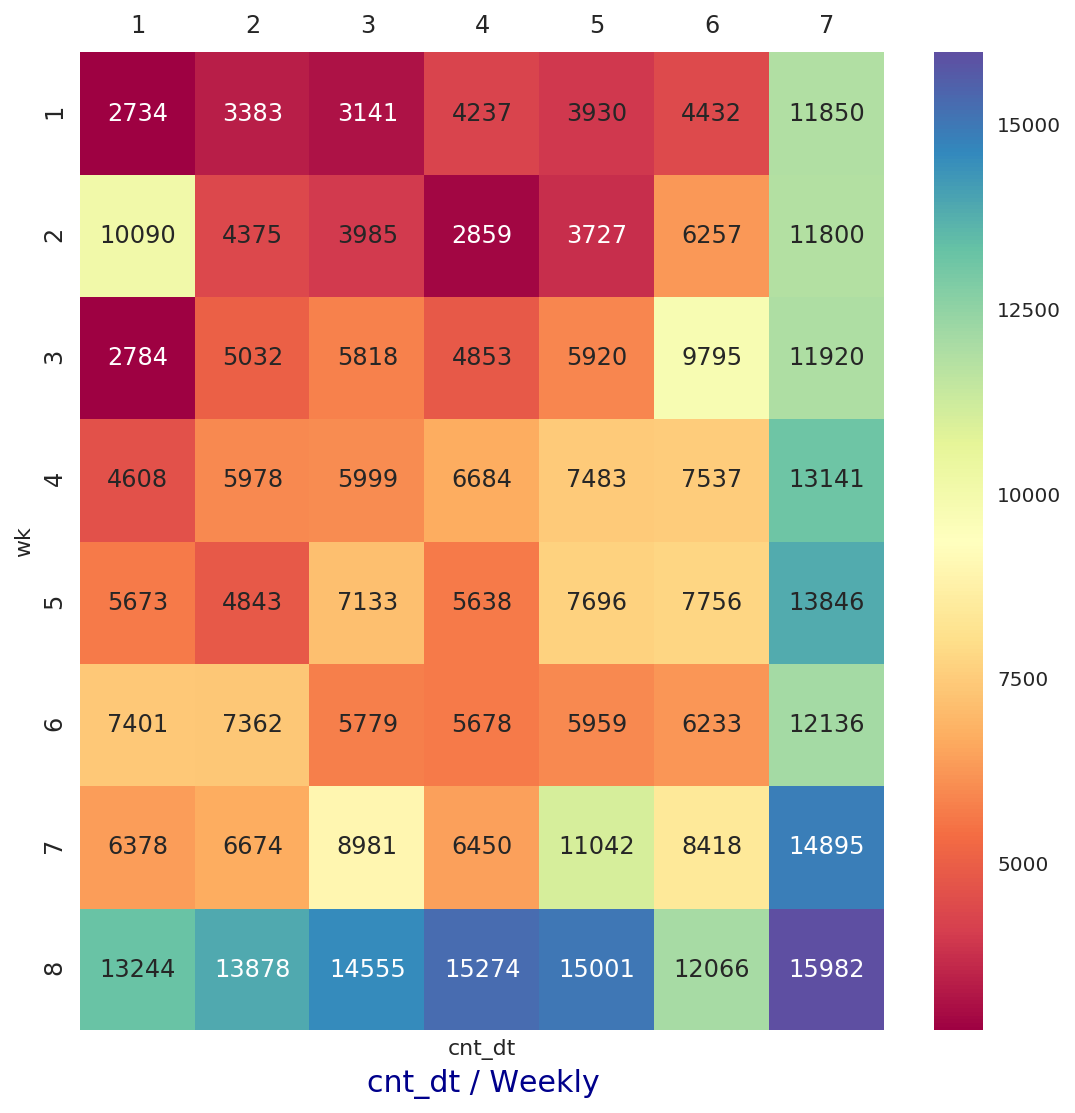

In [63]:
plt.figure(figsize=(9, 9))
sns.heatmap(df.pivot_table(values="user", index="wk", columns="cnt_dt"), \
            cmap=plt.cm.Spectral, annot=True, annot_kws={"size": 12}, fmt=".0f")
plt.gca().xaxis.tick_top() 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(2.5, -0.5, "cnt_dt / Weekly", fontsize=15, color='darkblue')
plt.show()

In [78]:
query = '''
        SELECT active_week, label, COUNT(DISTINCT user_id) as retain
        FROM (
            SELECT string_field_0 AS user_id, string_field_1 AS label, activity.wk AS active_week
            FROM `nc_new.train_label` AS label
            LEFT JOIN
                (SELECT wk, acc_id
                FROM `nc_new.train_activity` 
                GROUP BY wk, acc_id) AS activity
                ON label.string_field_0 = activity.acc_id
                GROUP BY 1,2,3)
        GROUP BY 1,2
        ORDER BY 1
        '''

In [80]:
%%time
retain_df = gbq.read_gbq(query = query, project_id=PROJECT_ID, dialect='standard', verbose=False, configuration = {'query': {'useQueryCache': True}})

CPU times: user 50.2 ms, sys: 2.01 ms, total: 52.2 ms
Wall time: 1.32 s


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


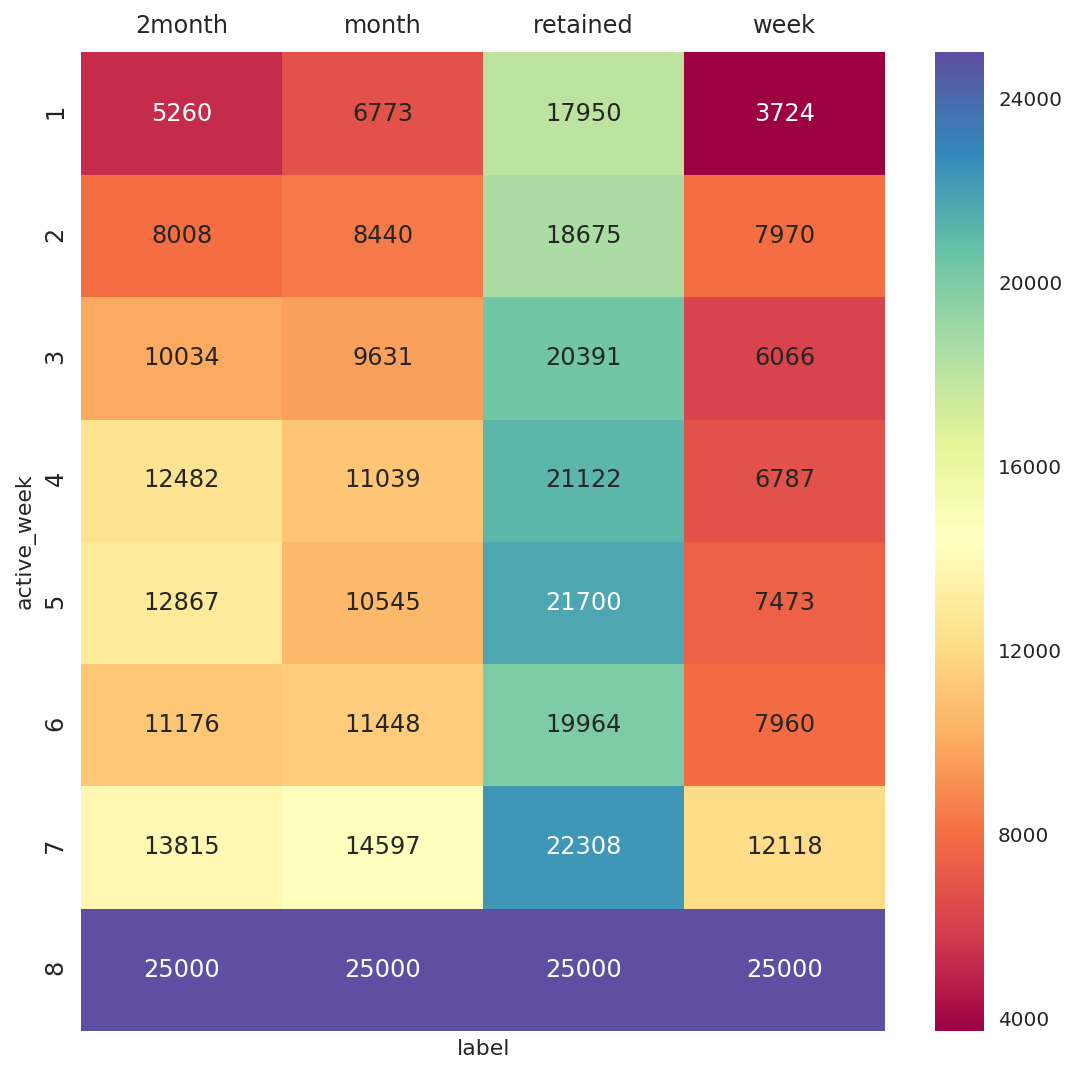

In [81]:
plt.figure(figsize=(9, 9))
sns.heatmap(retain_df.pivot_table(values="retain", index="active_week", columns="label"), \
            cmap=plt.cm.Spectral, annot=True, annot_kws={"size": 12}, fmt=".0f")
plt.gca().xaxis.tick_top() 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('')
plt.show()

## Visualize Train Activity Table 

In [82]:
train_activity_df = select_all_columns("train_activity")

In [83]:
train_activity_df.columns

Index(['wk', 'acc_id', 'cnt_dt', 'play_time', 'npc_exp', 'npc_hongmun',
       'quest_exp', 'quest_hongmun', 'item_hongmun', 'game_combat_time',
       'get_money', 'duel_cnt', 'duel_win', 'partybattle_cnt',
       'partybattle_win', 'cnt_enter_inzone_solo', 'cnt_enter_inzone_light',
       'cnt_enter_inzone_skilled', 'cnt_enter_inzone_normal', 'cnt_enter_raid',
       'cnt_enter_raid_light', 'cnt_enter_bam', 'cnt_clear_inzone_solo',
       'cnt_clear_inzone_light', 'cnt_clear_inzone_skilled',
       'cnt_clear_inzone_normal', 'cnt_clear_raid', 'cnt_clear_raid_light',
       'cnt_clear_bam', 'normal_chat', 'whisper_chat', 'district_chat',
       'party_chat', 'guild_chat', 'faction_chat', 'cnt_use_buffitem',
       'gathering_cnt', 'making_cnt'],
      dtype='object')

In [84]:
test_df = select_count("train_activity", "wk")[["wk","total"]]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


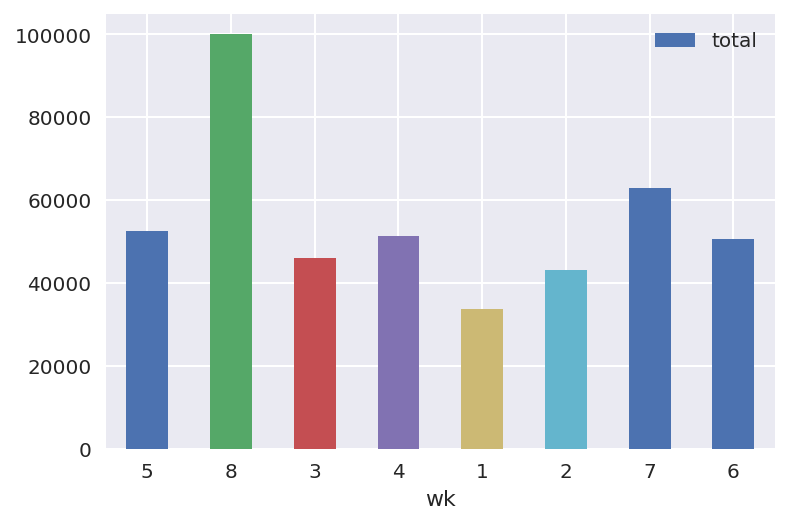

In [85]:
test_df.plot(x="wk", y="total", kind="bar", rot=0)

col :  wk


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


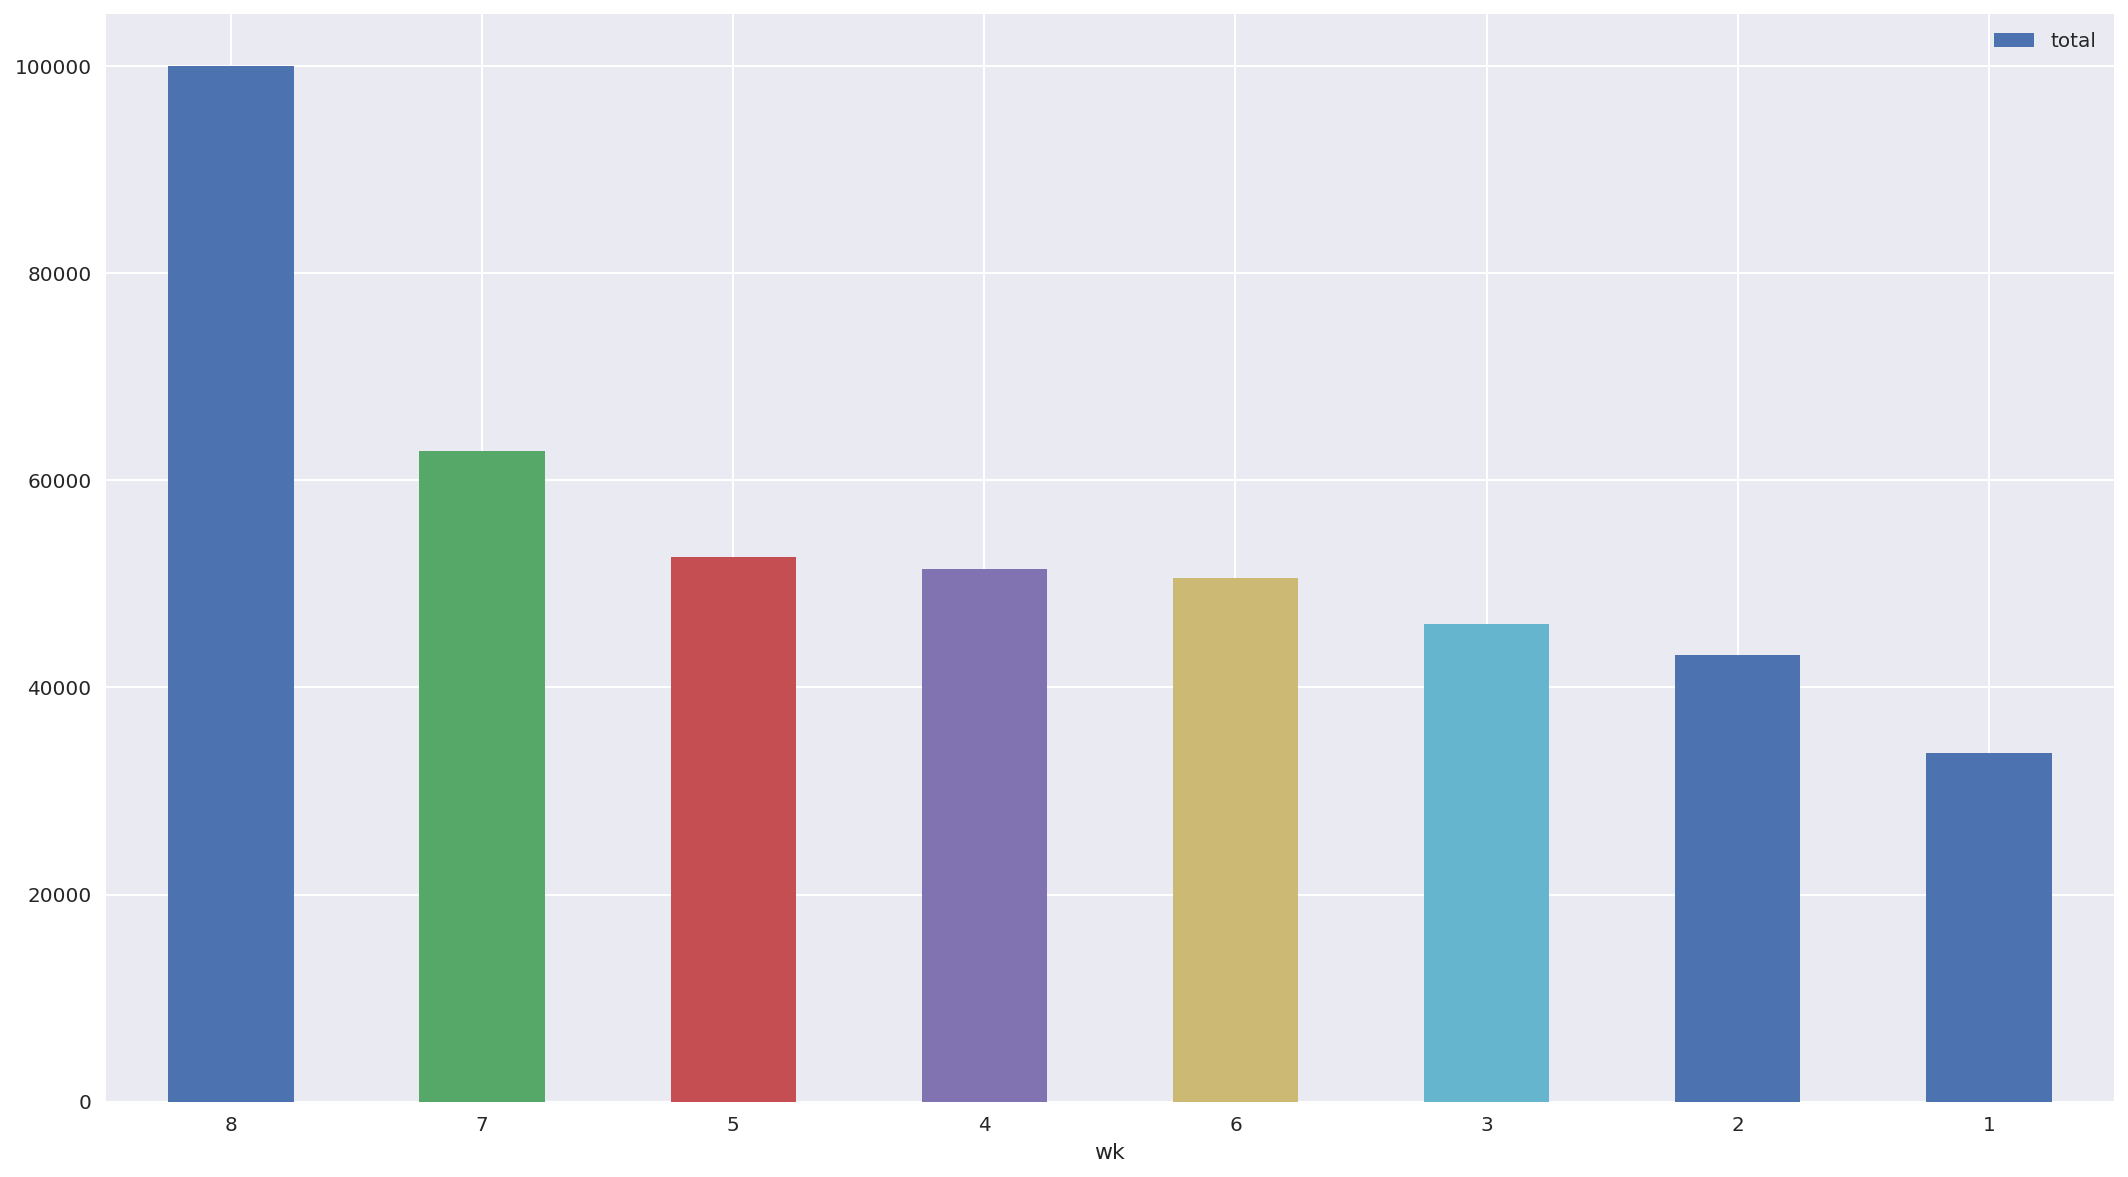

col :  cnt_dt


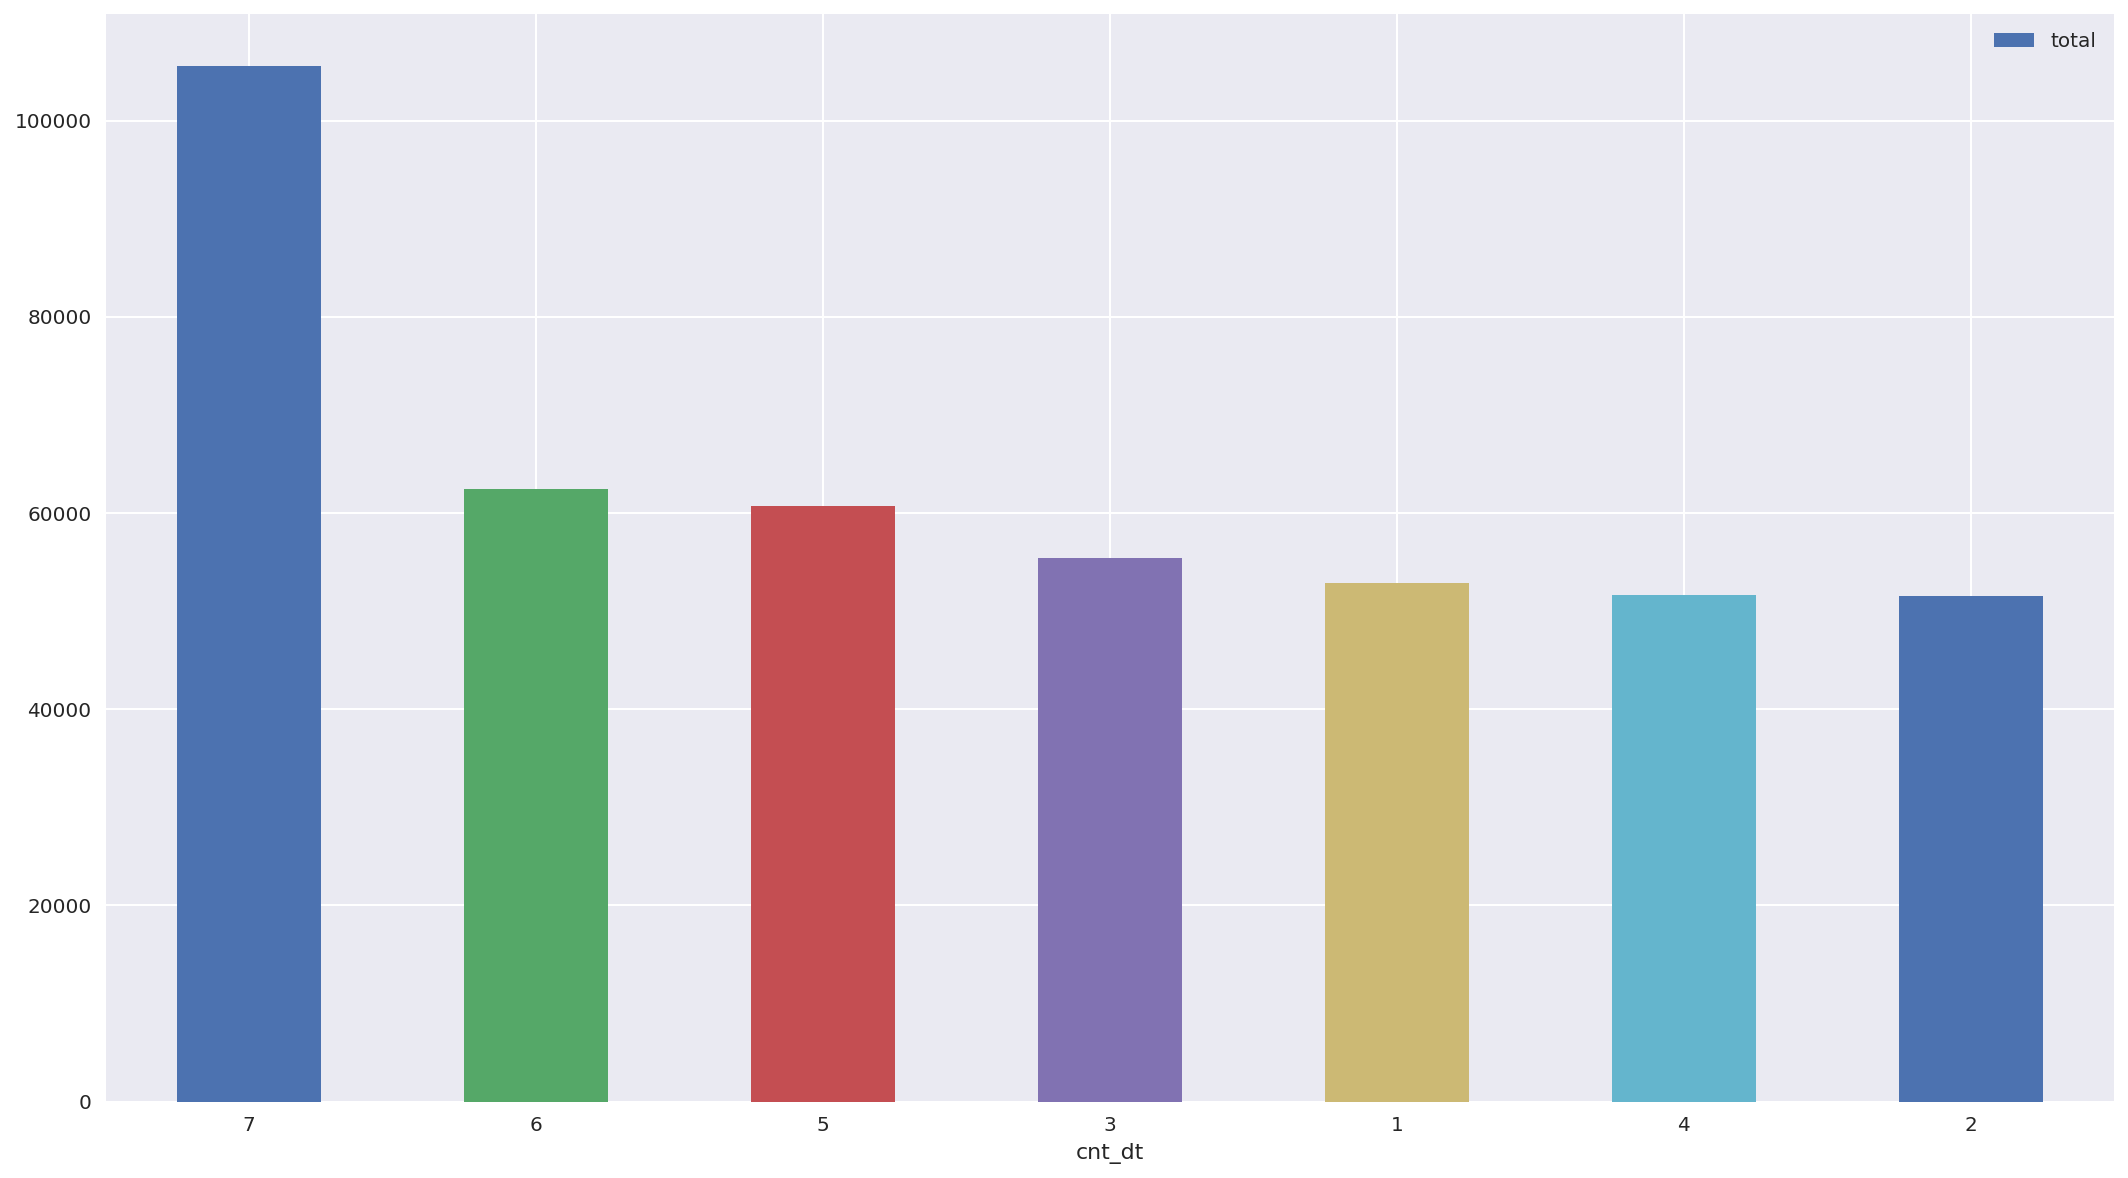

col :  npc_hongmun


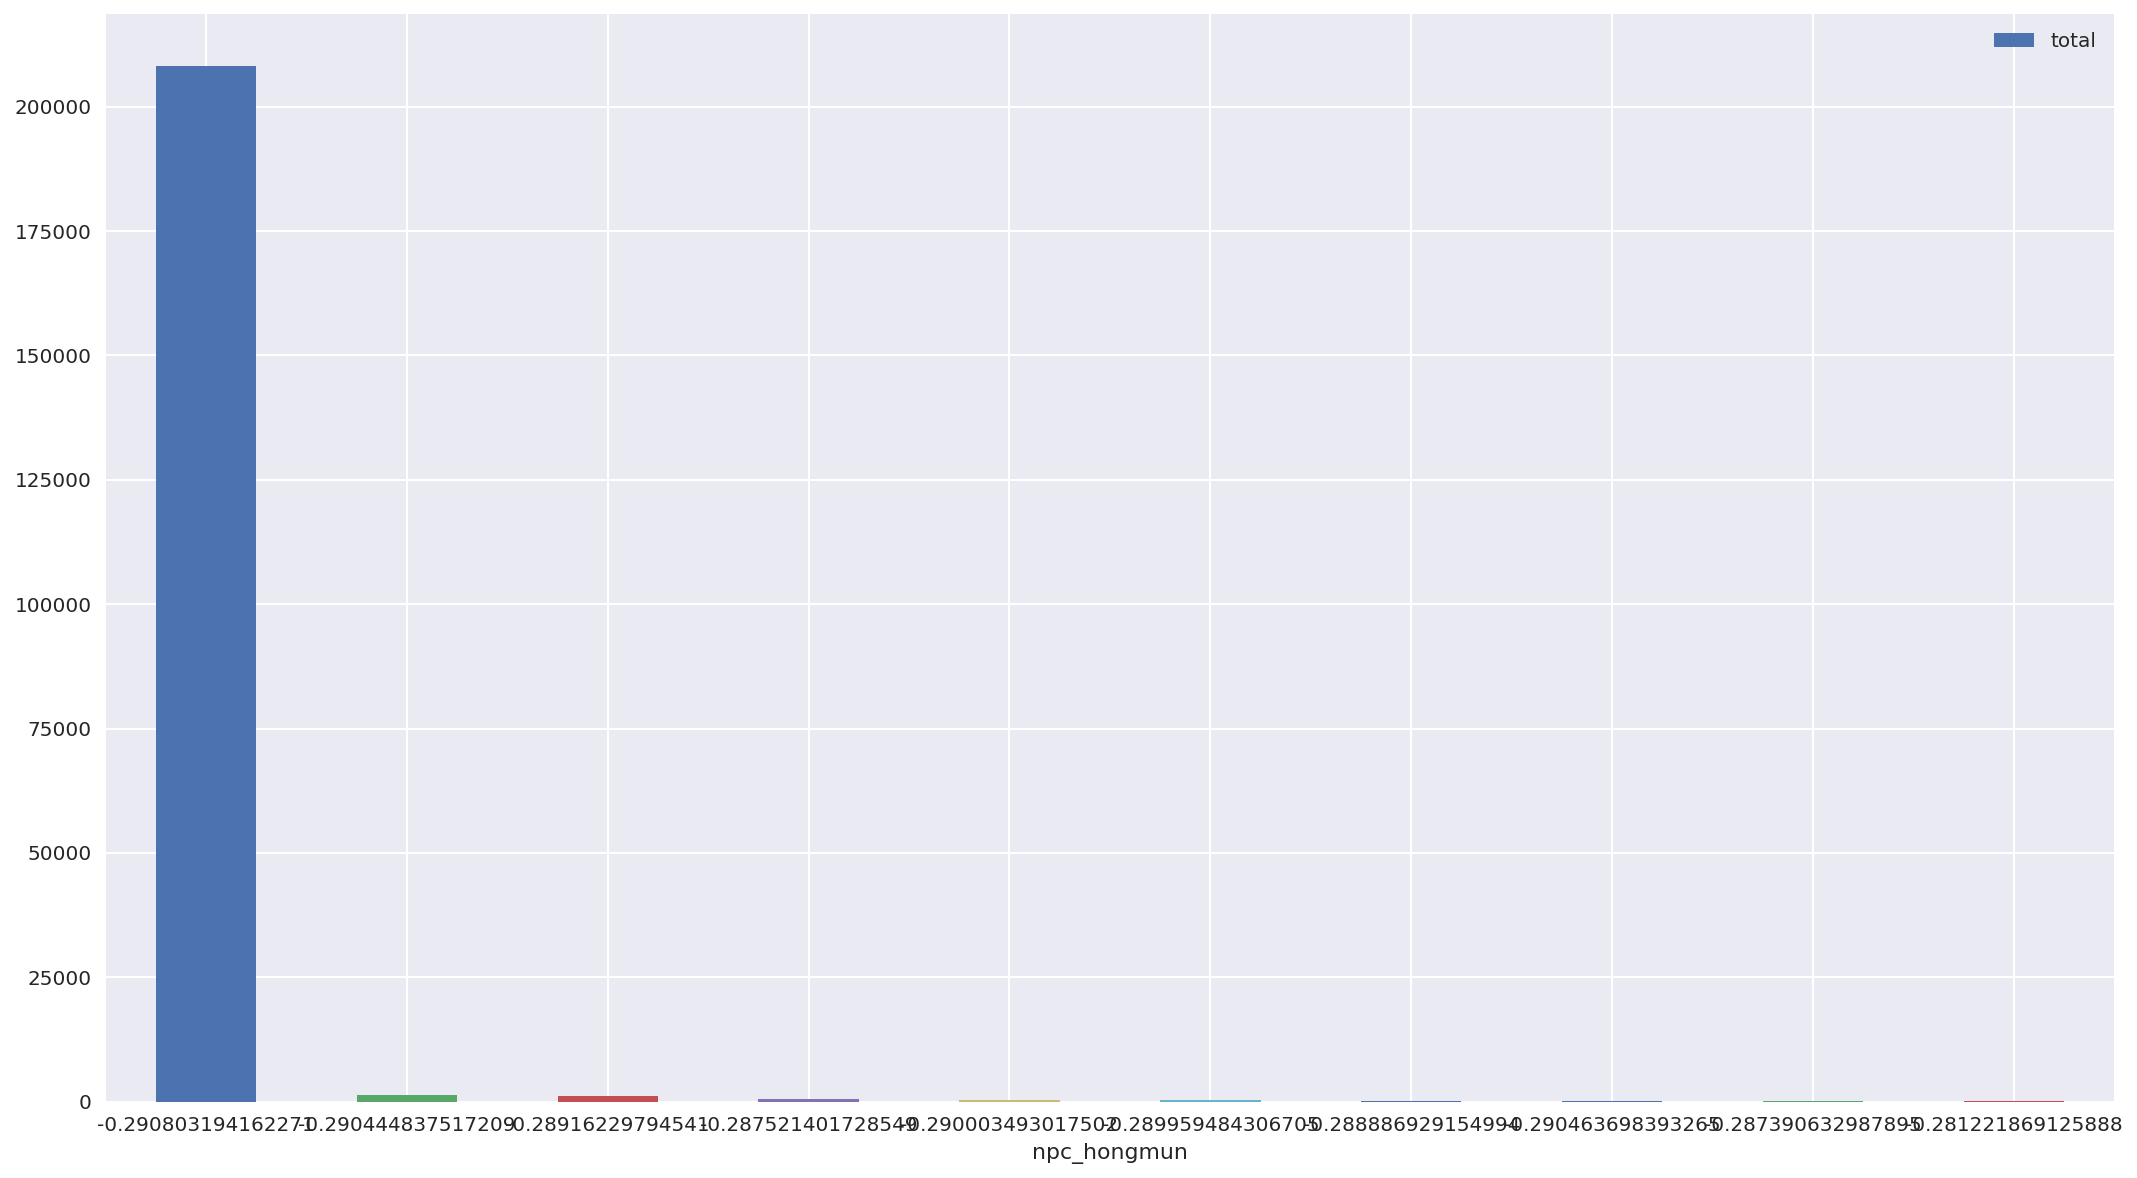

col :  duel_cnt


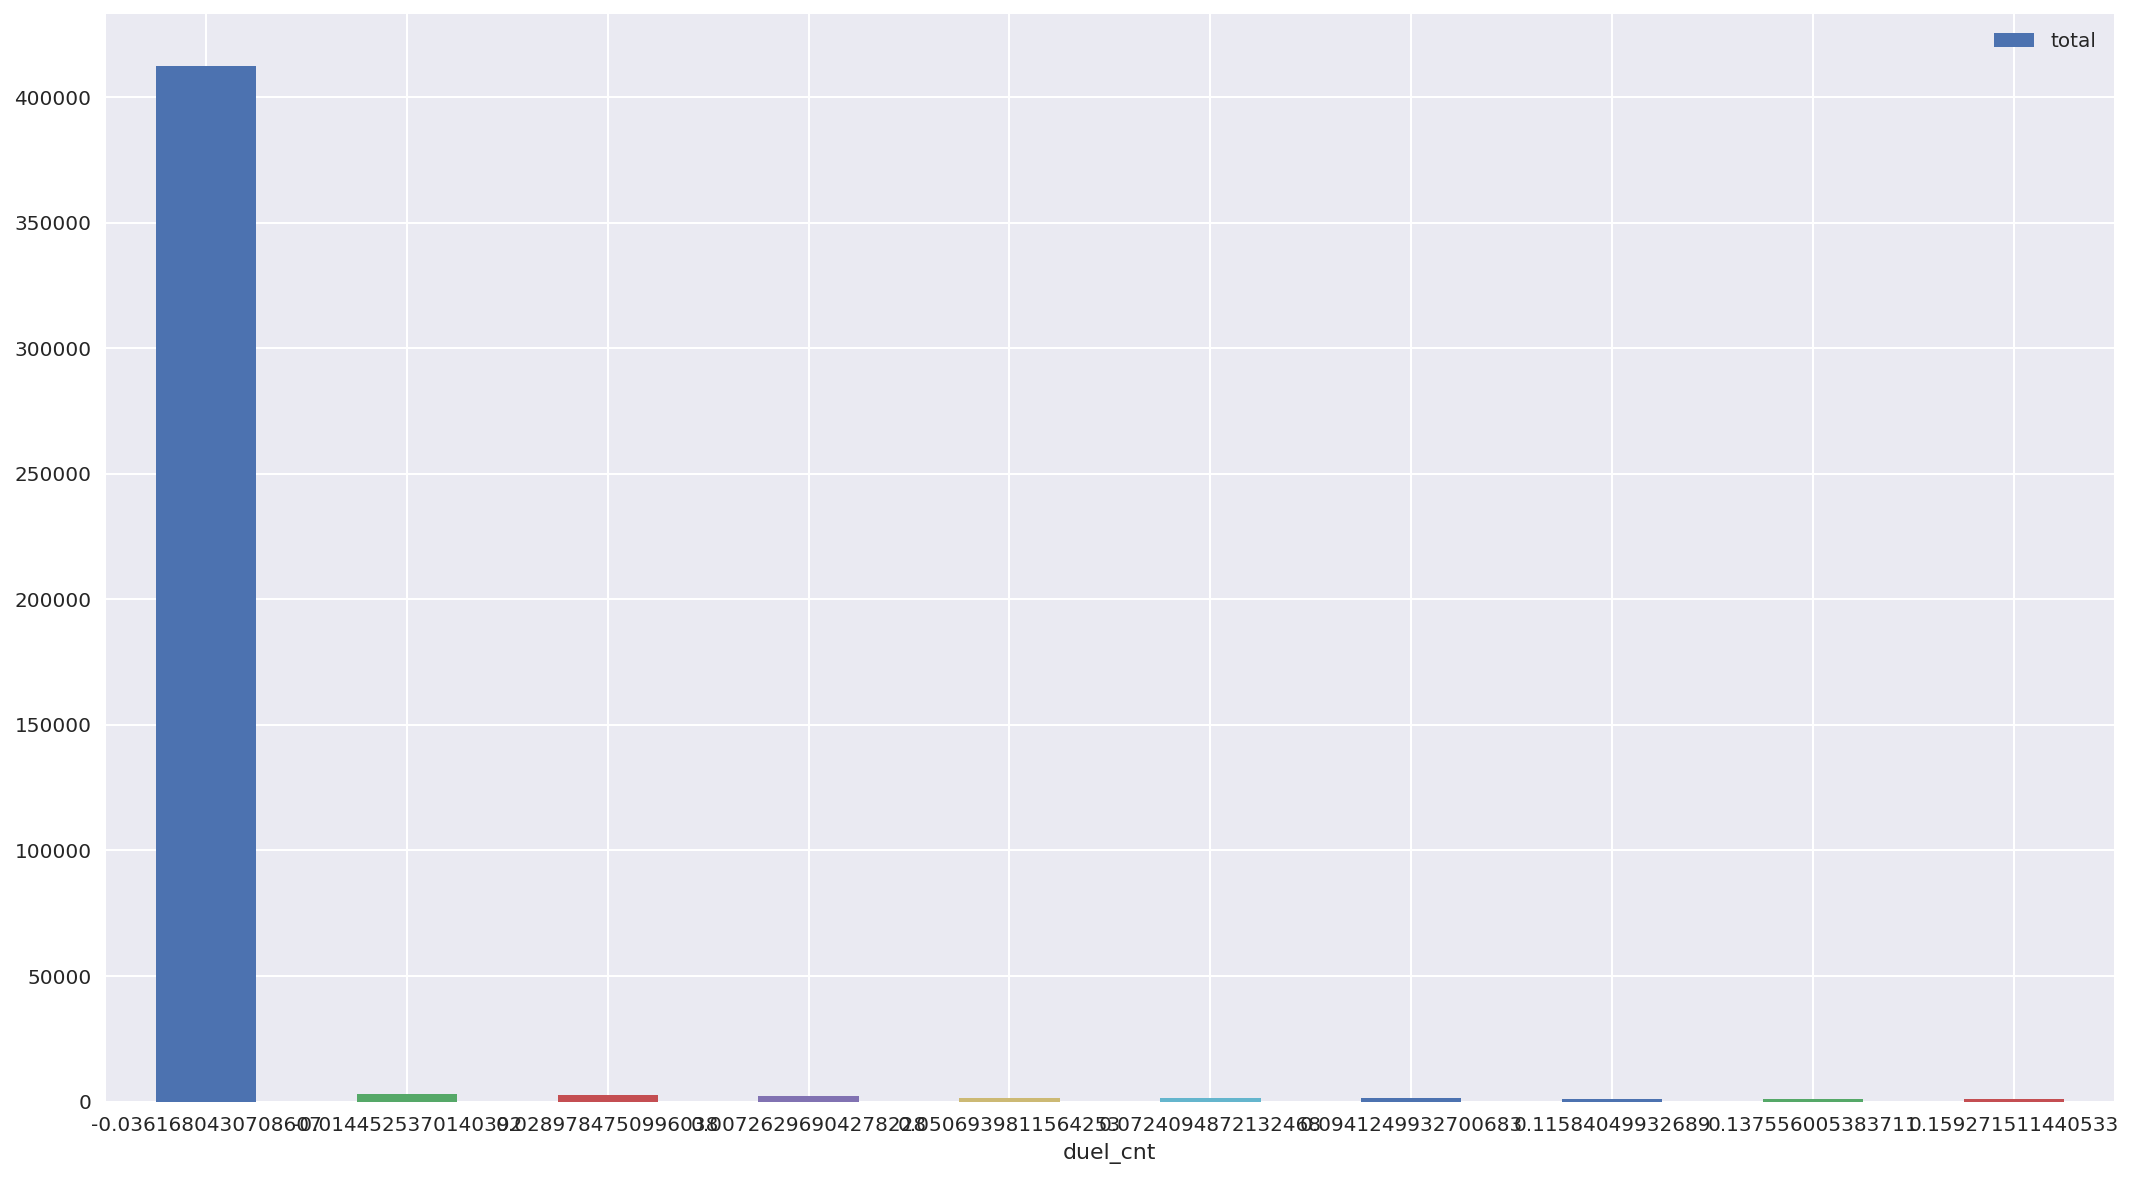

col :  duel_win


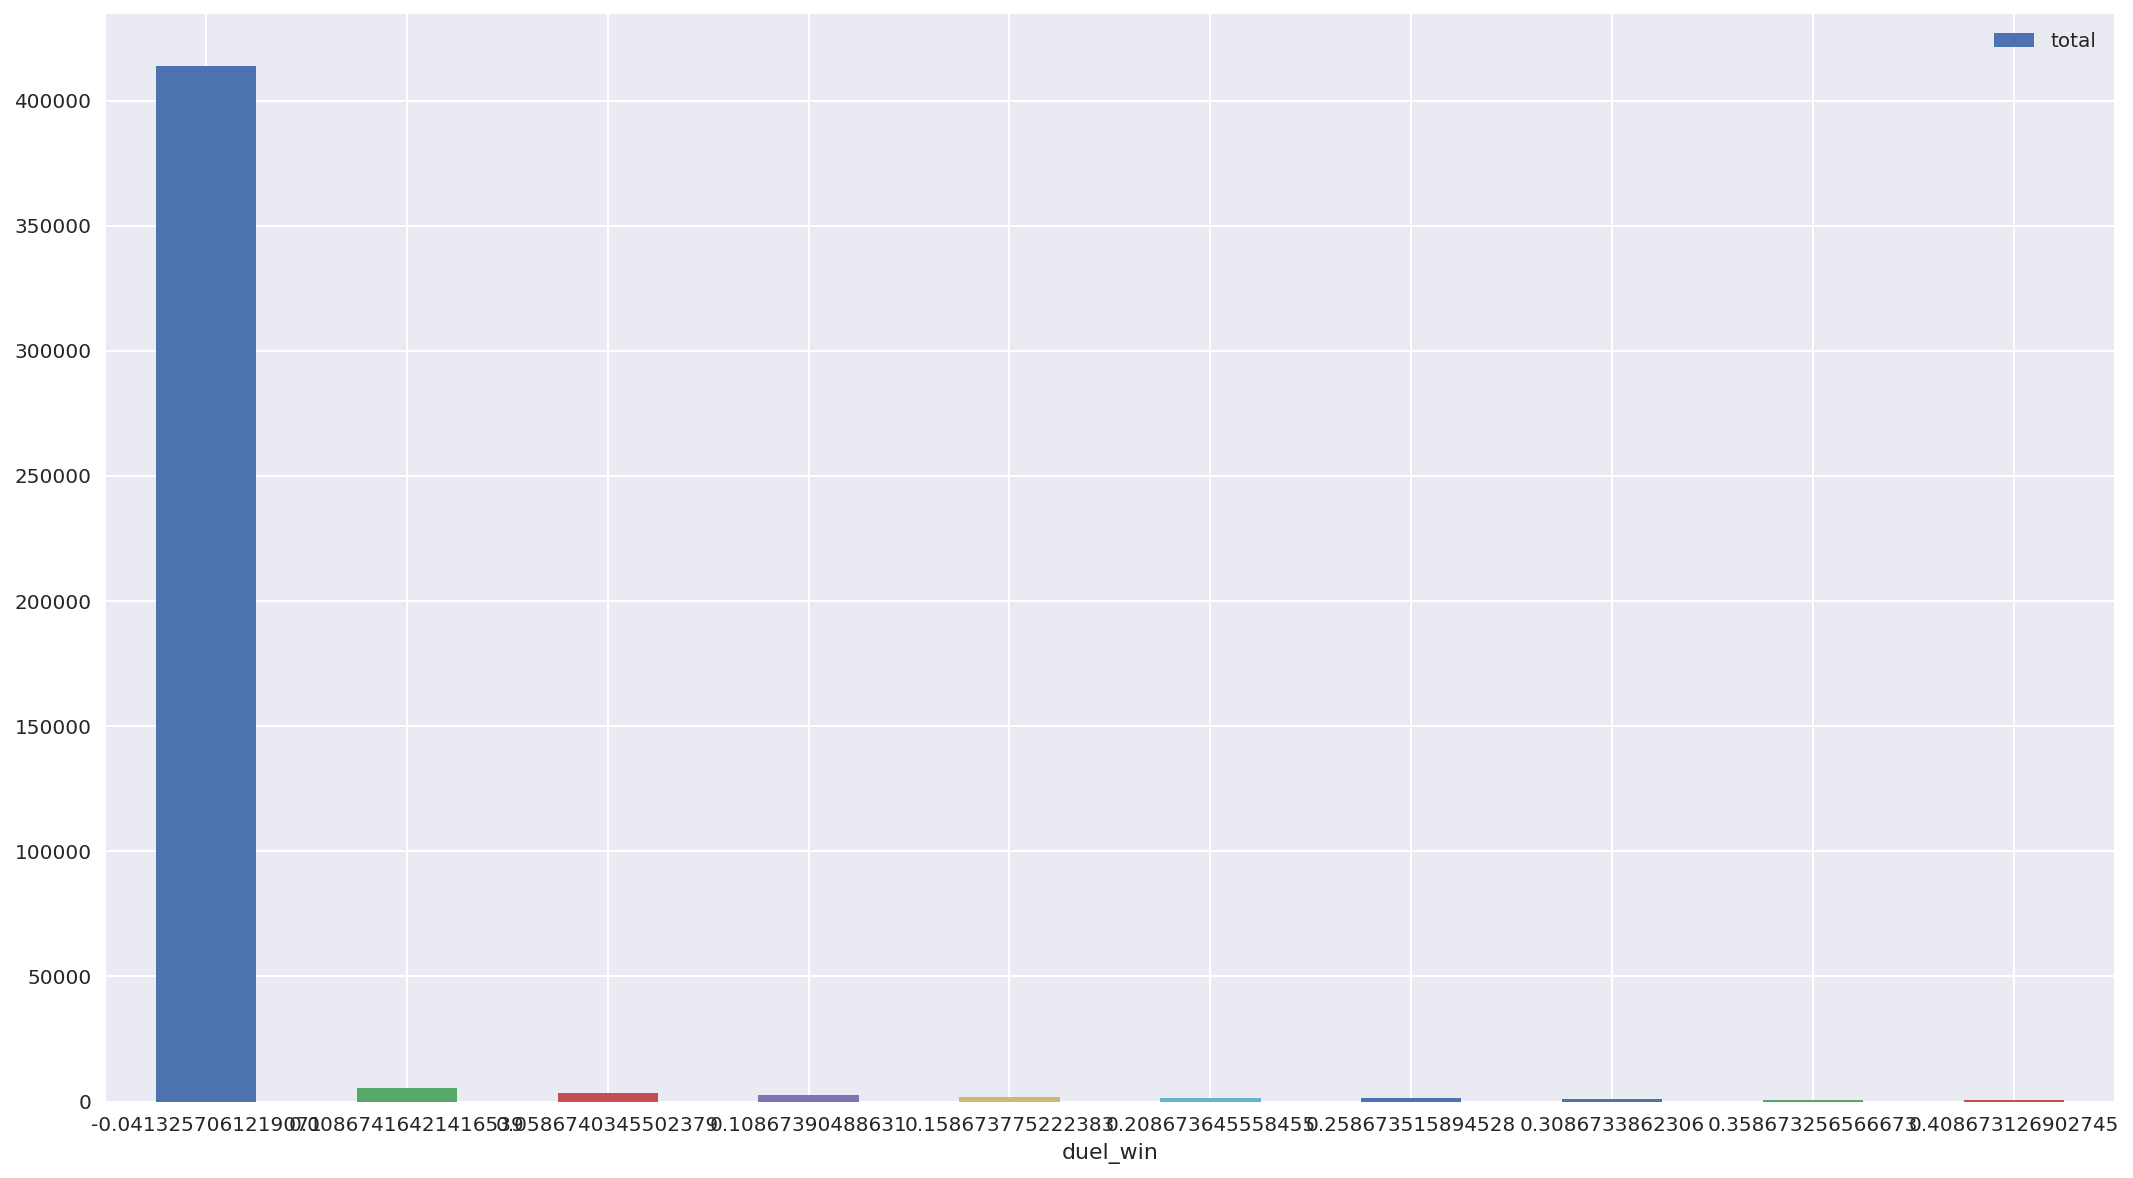

col :  partybattle_cnt


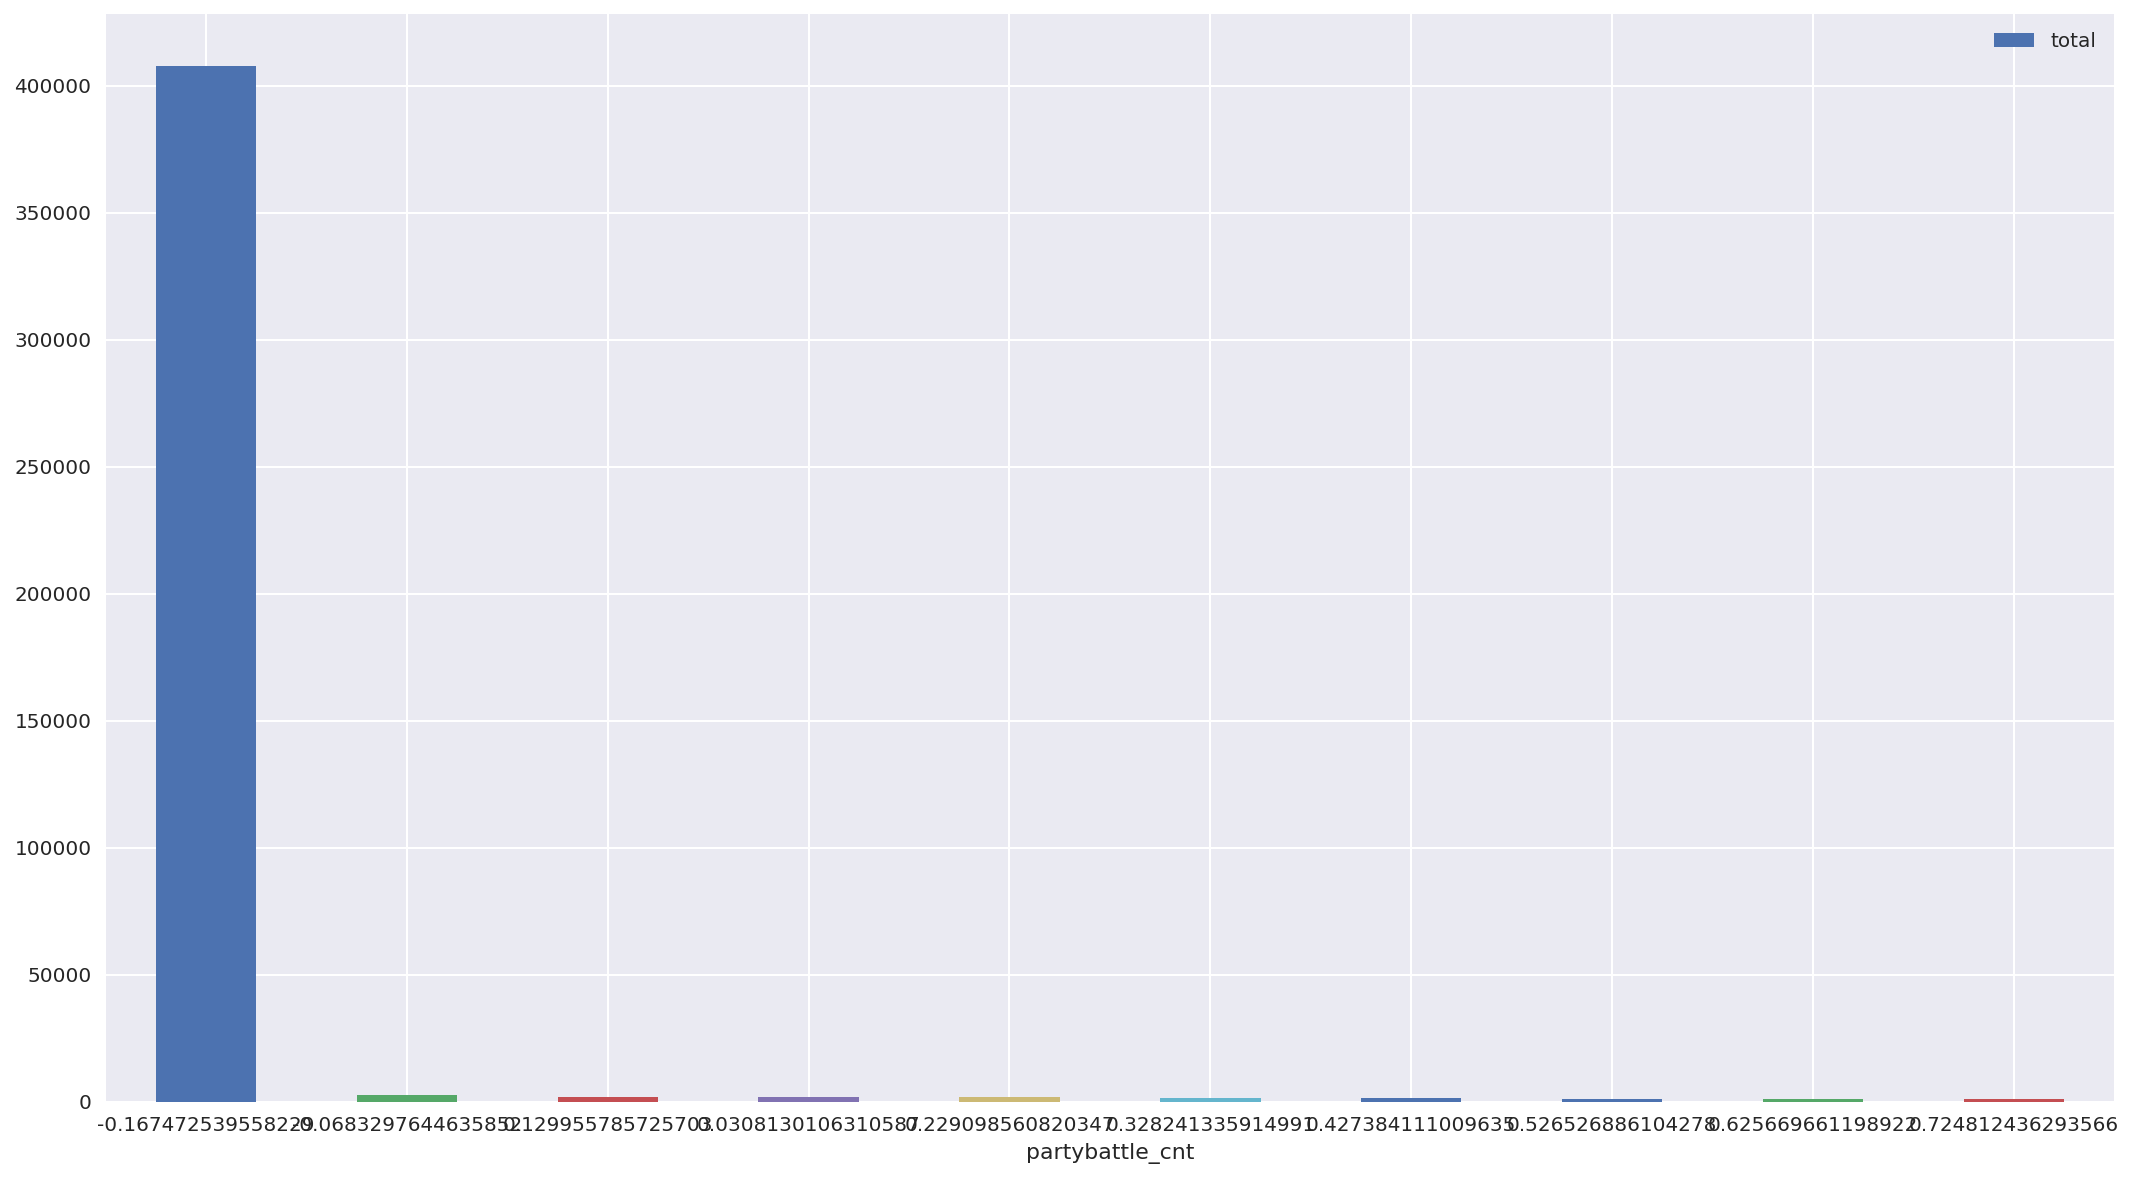

col :  partybattle_win


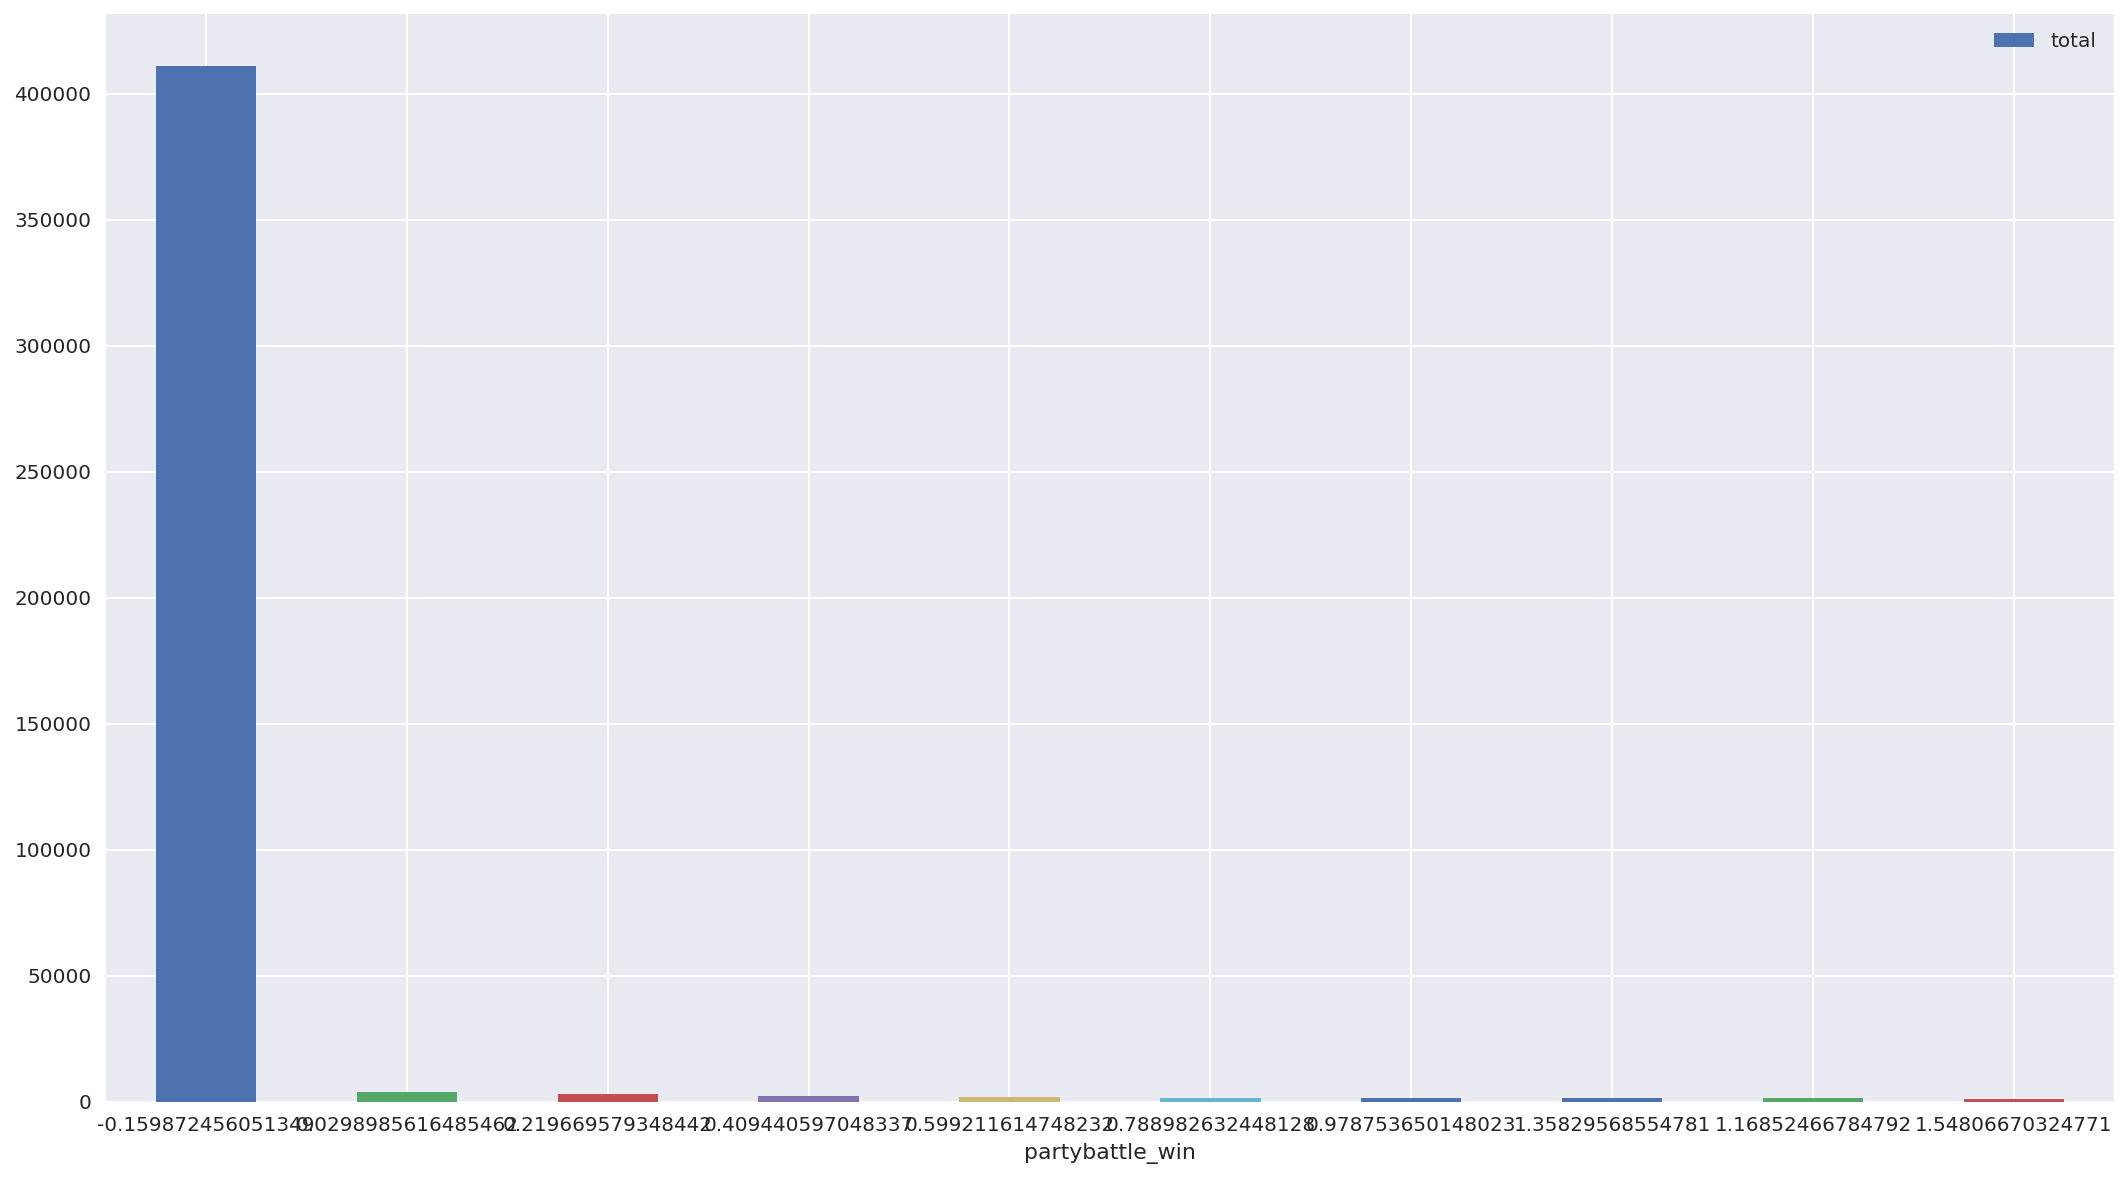

col :  cnt_enter_inzone_solo


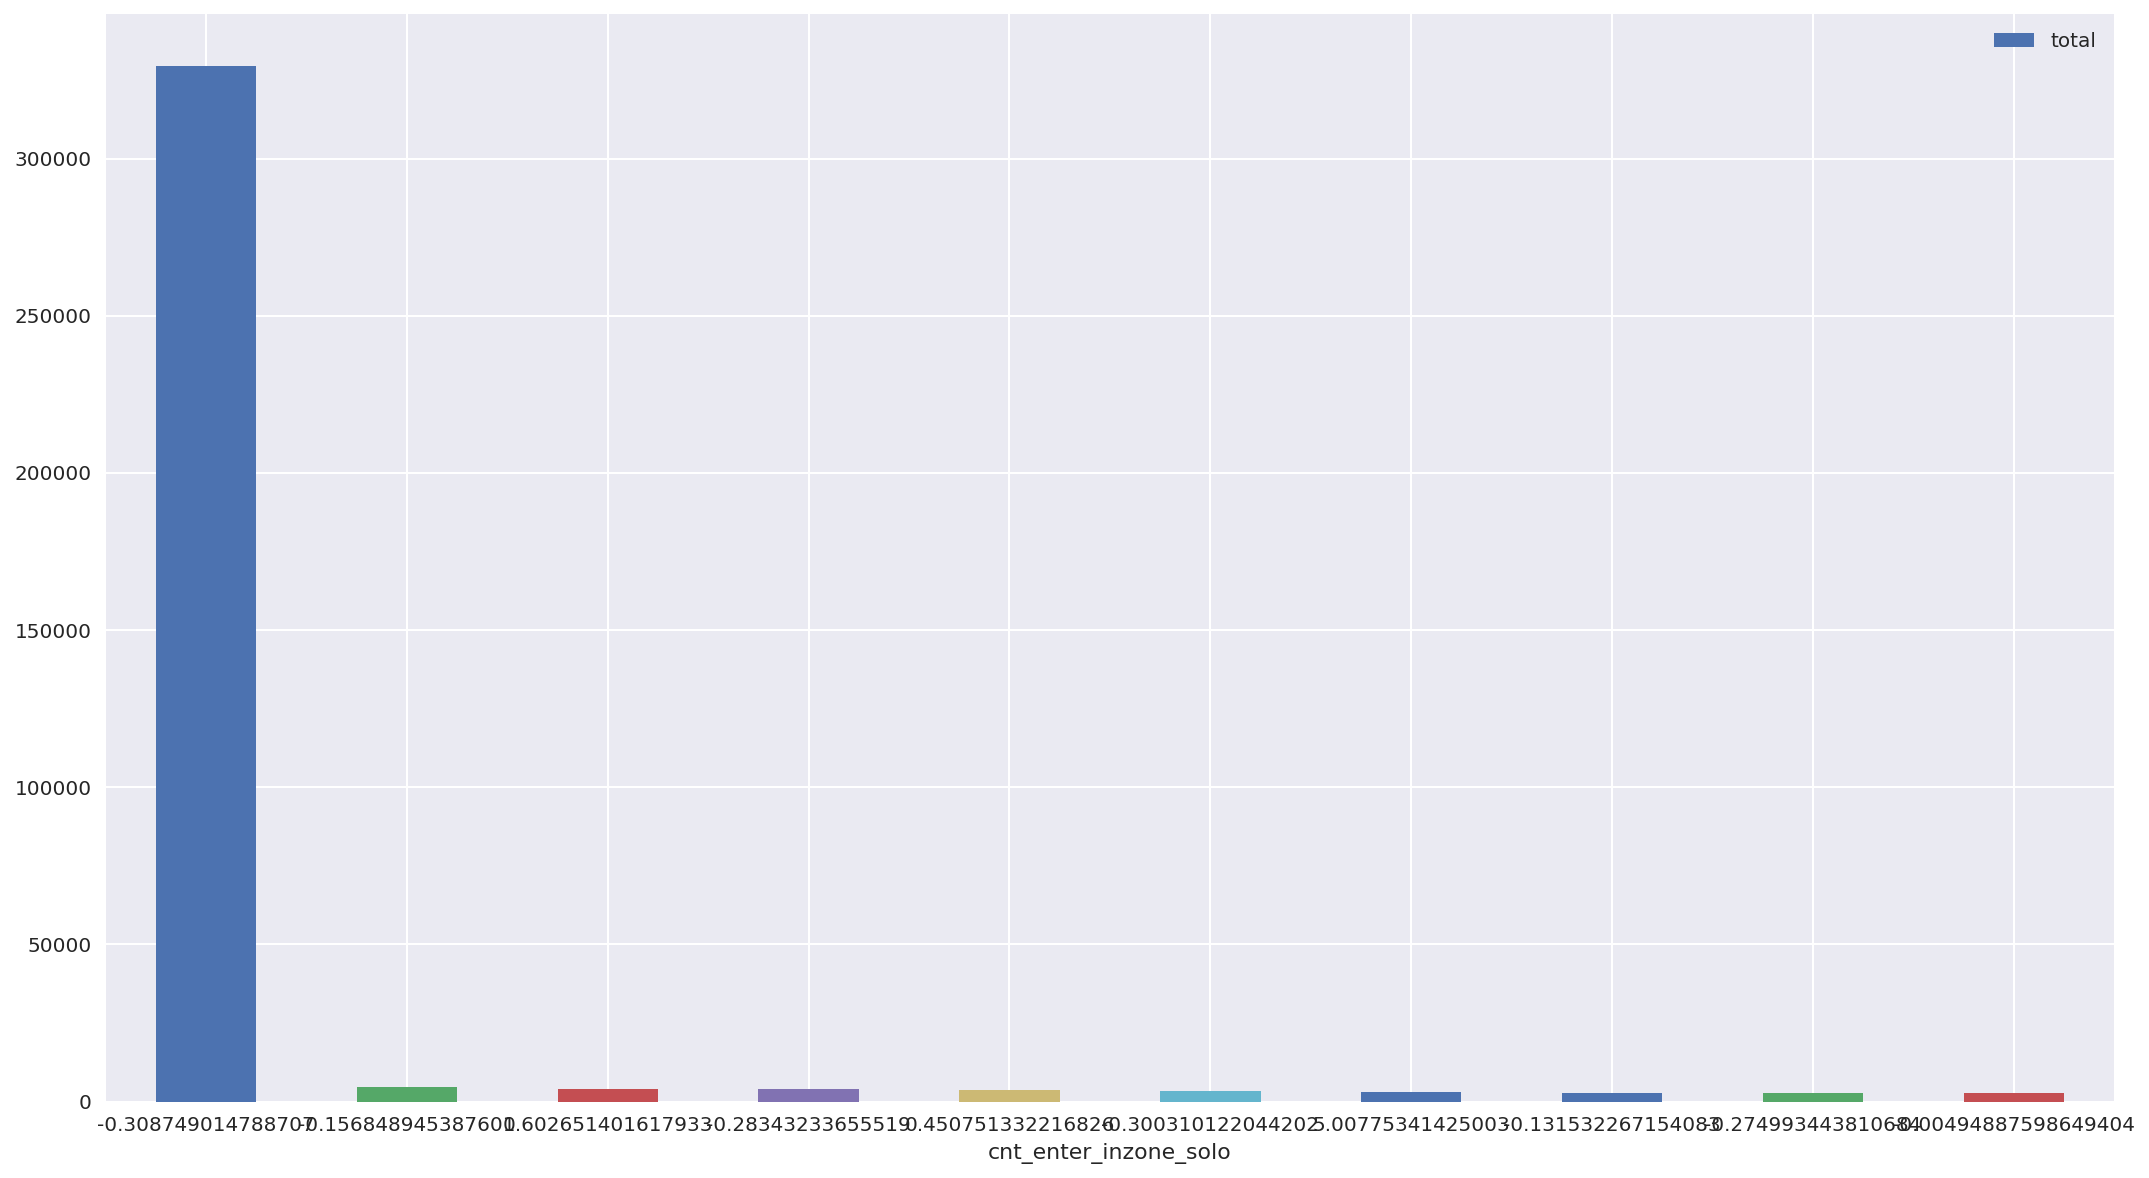

col :  cnt_enter_inzone_light


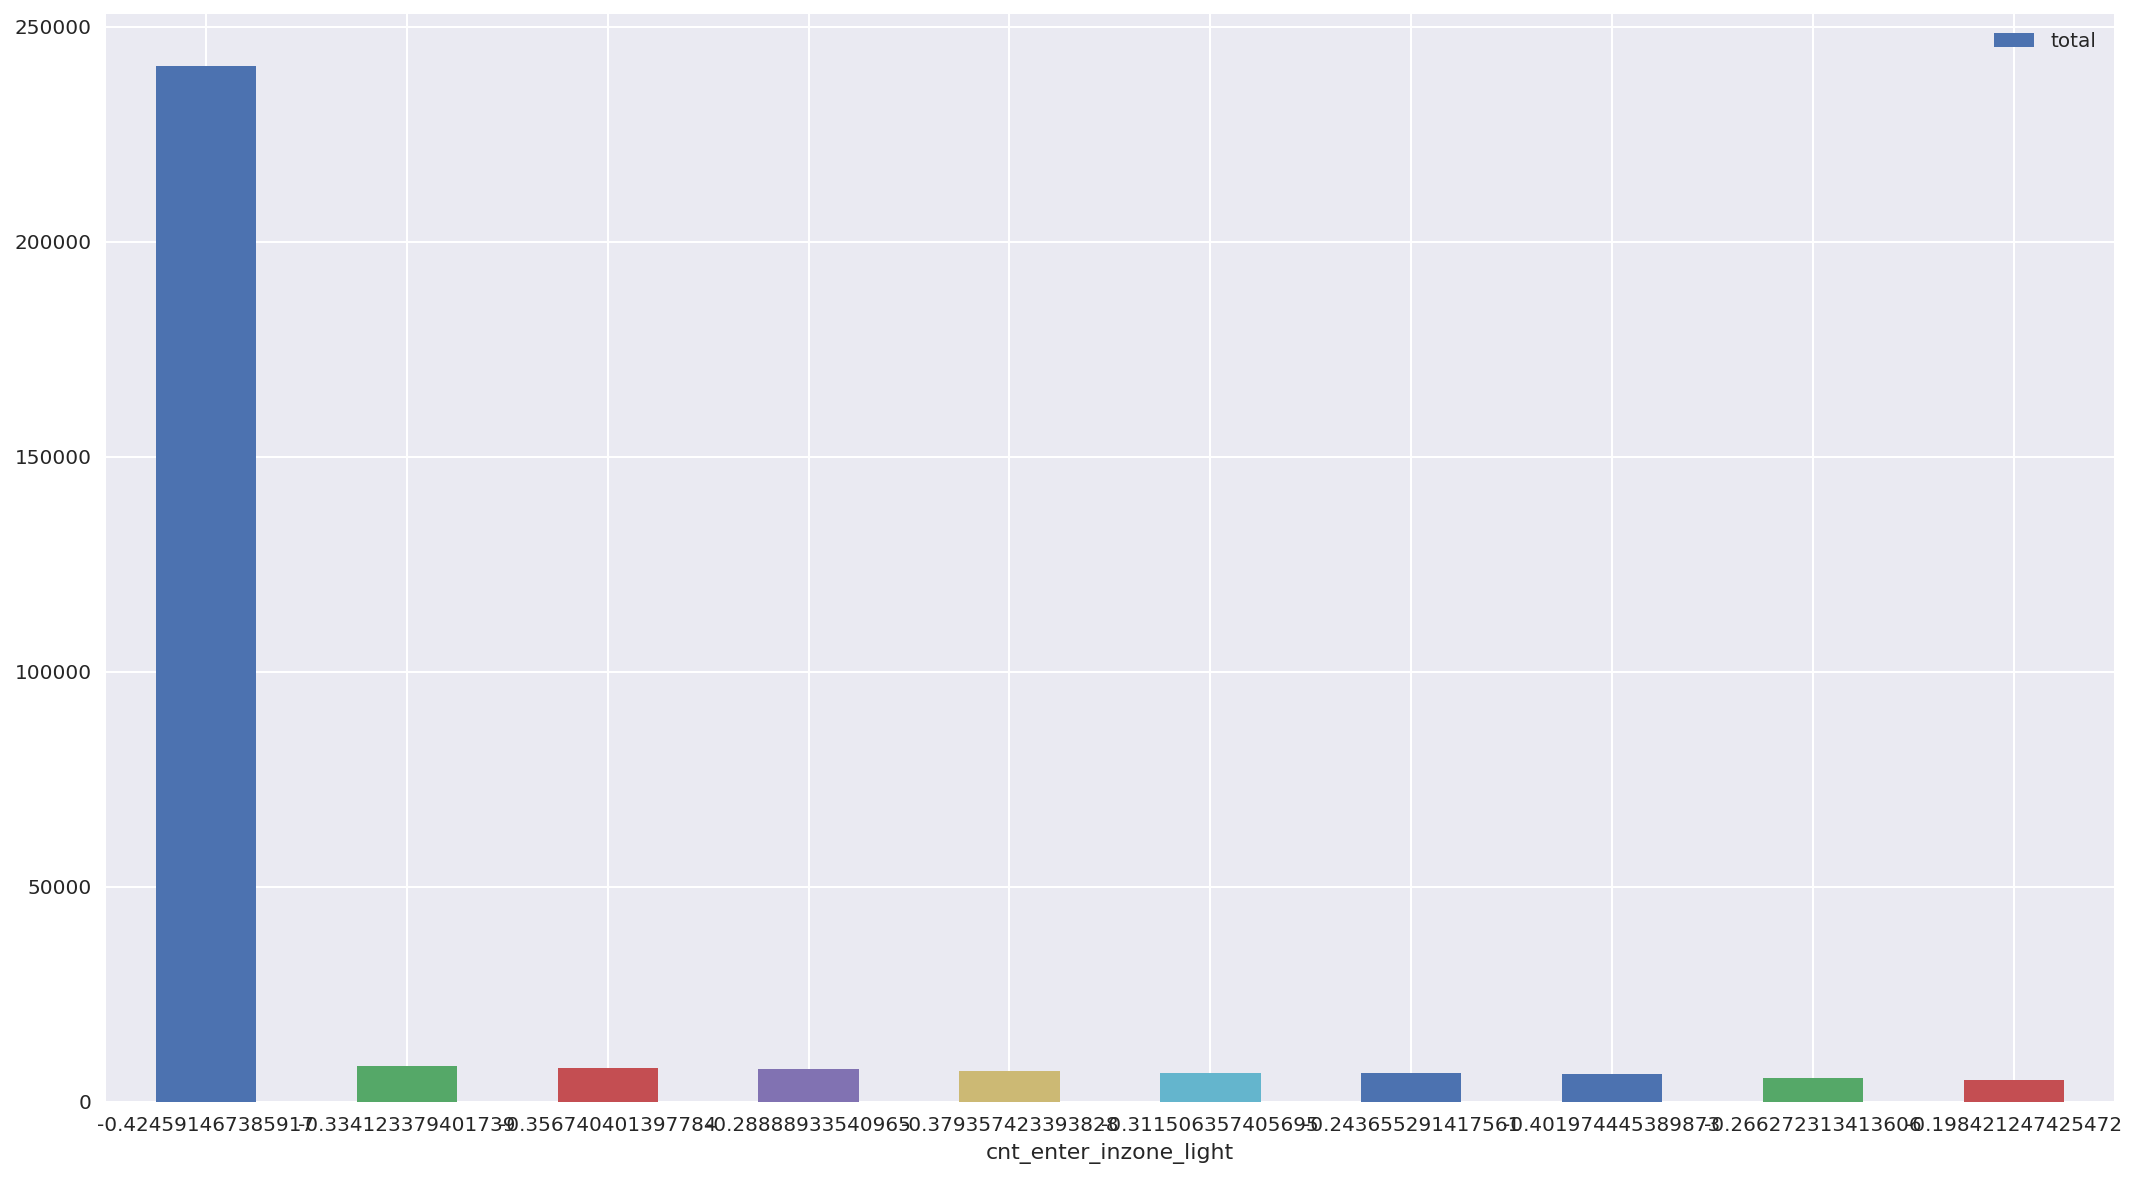

col :  cnt_enter_inzone_skilled


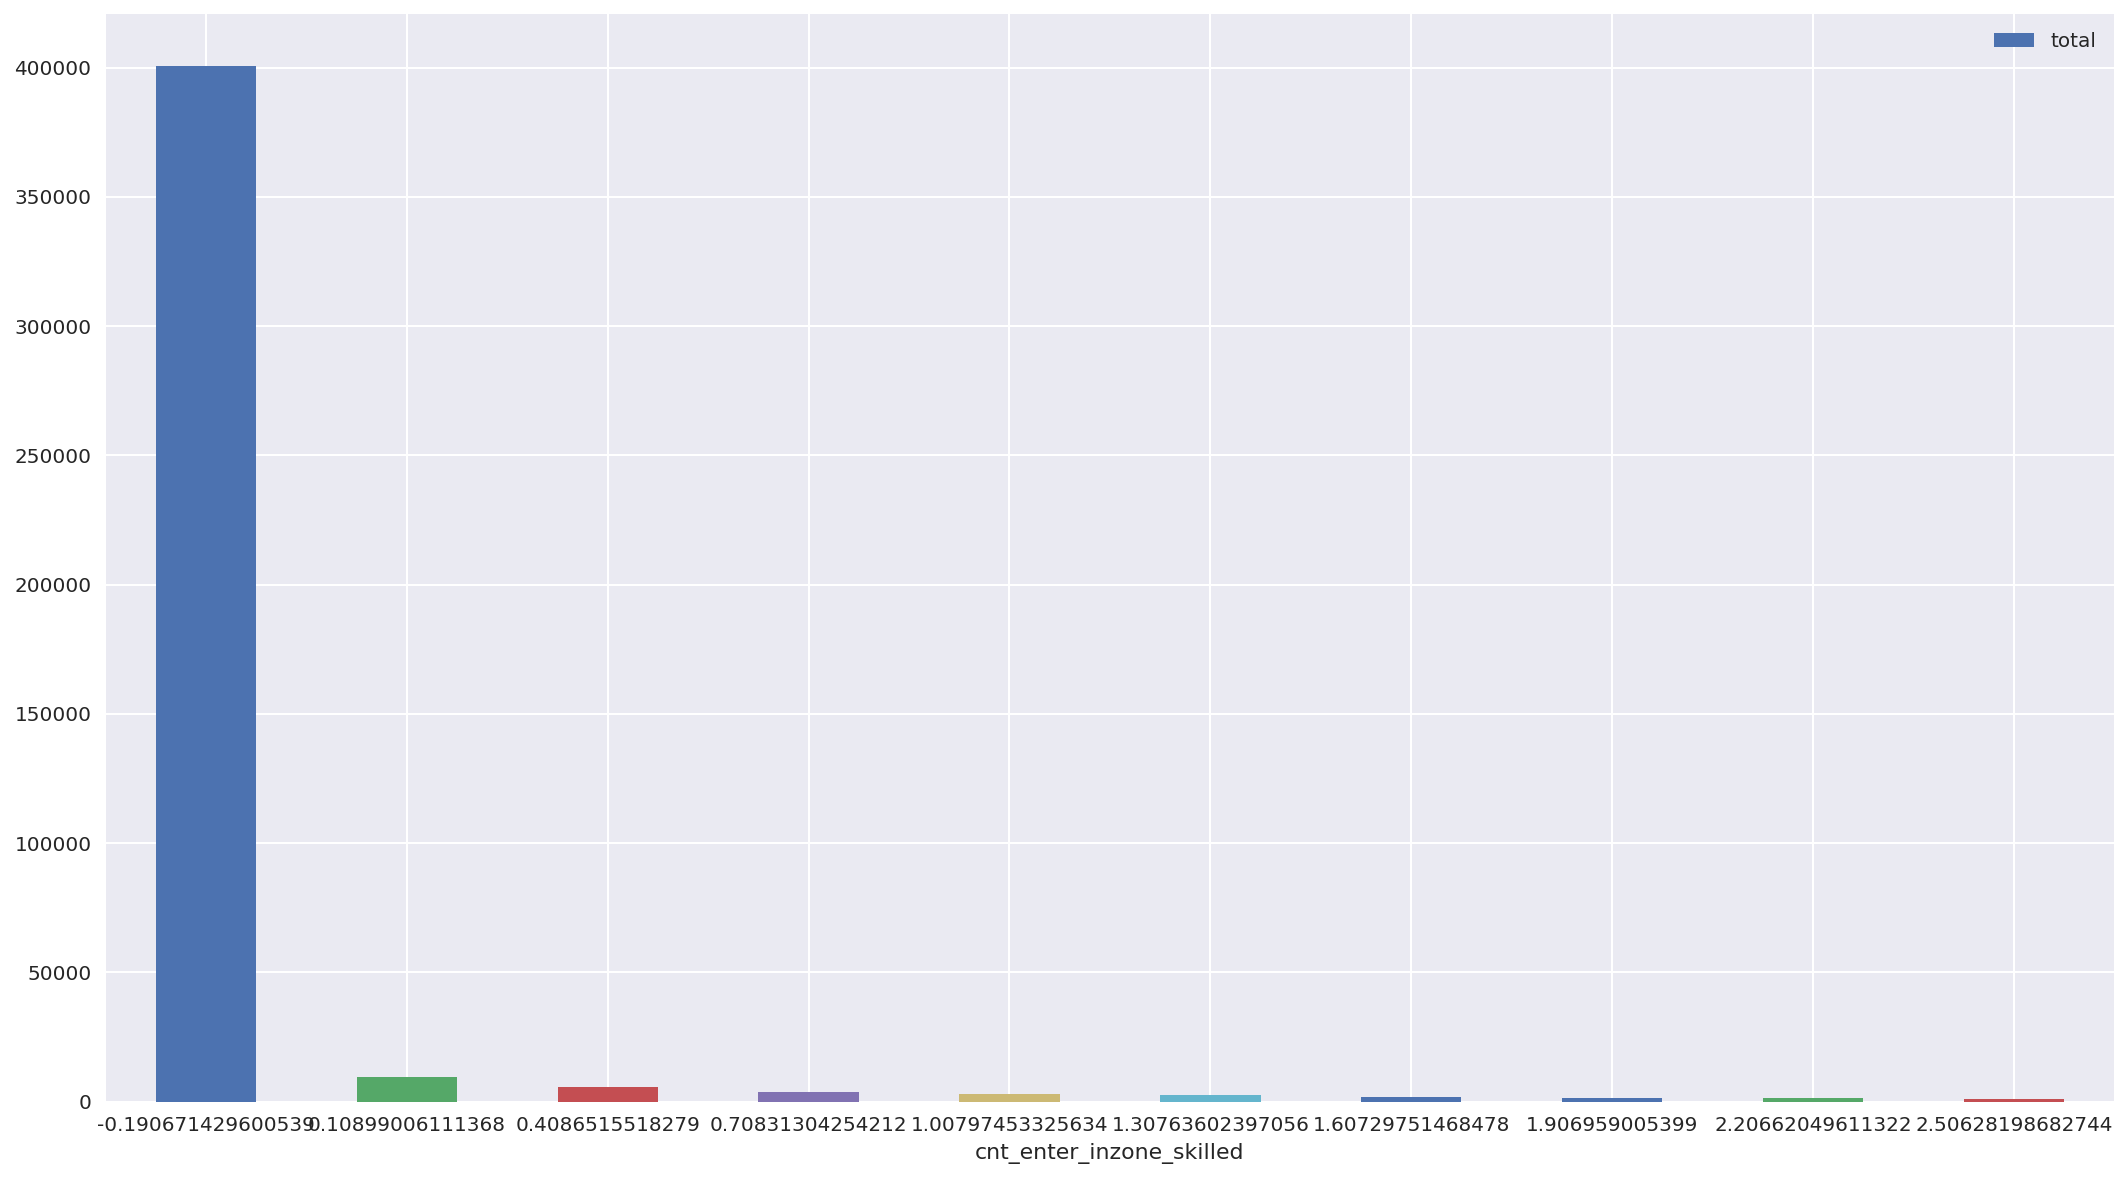

col :  cnt_enter_inzone_normal


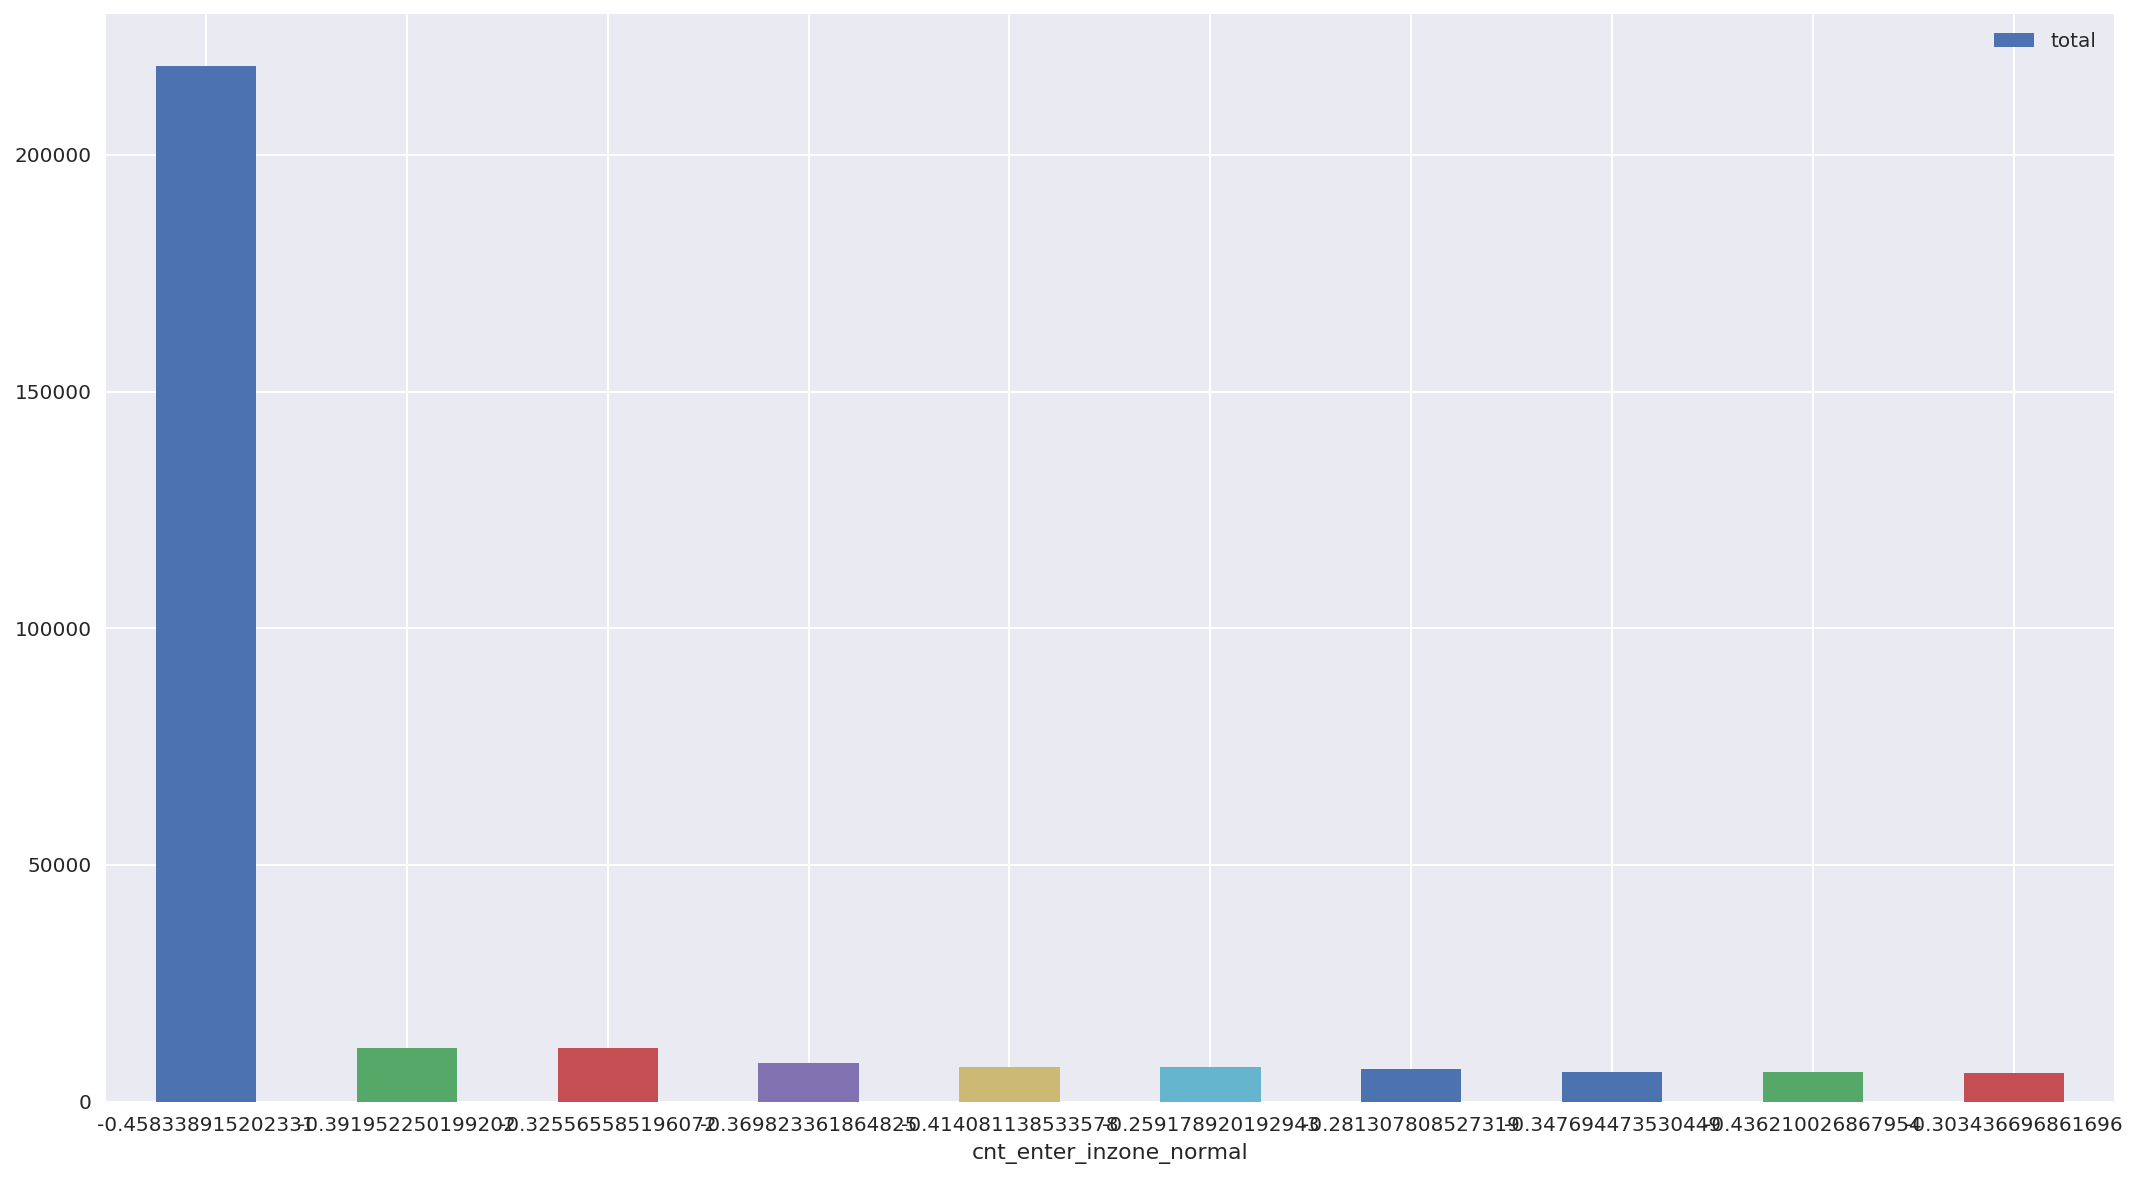

col :  cnt_enter_raid


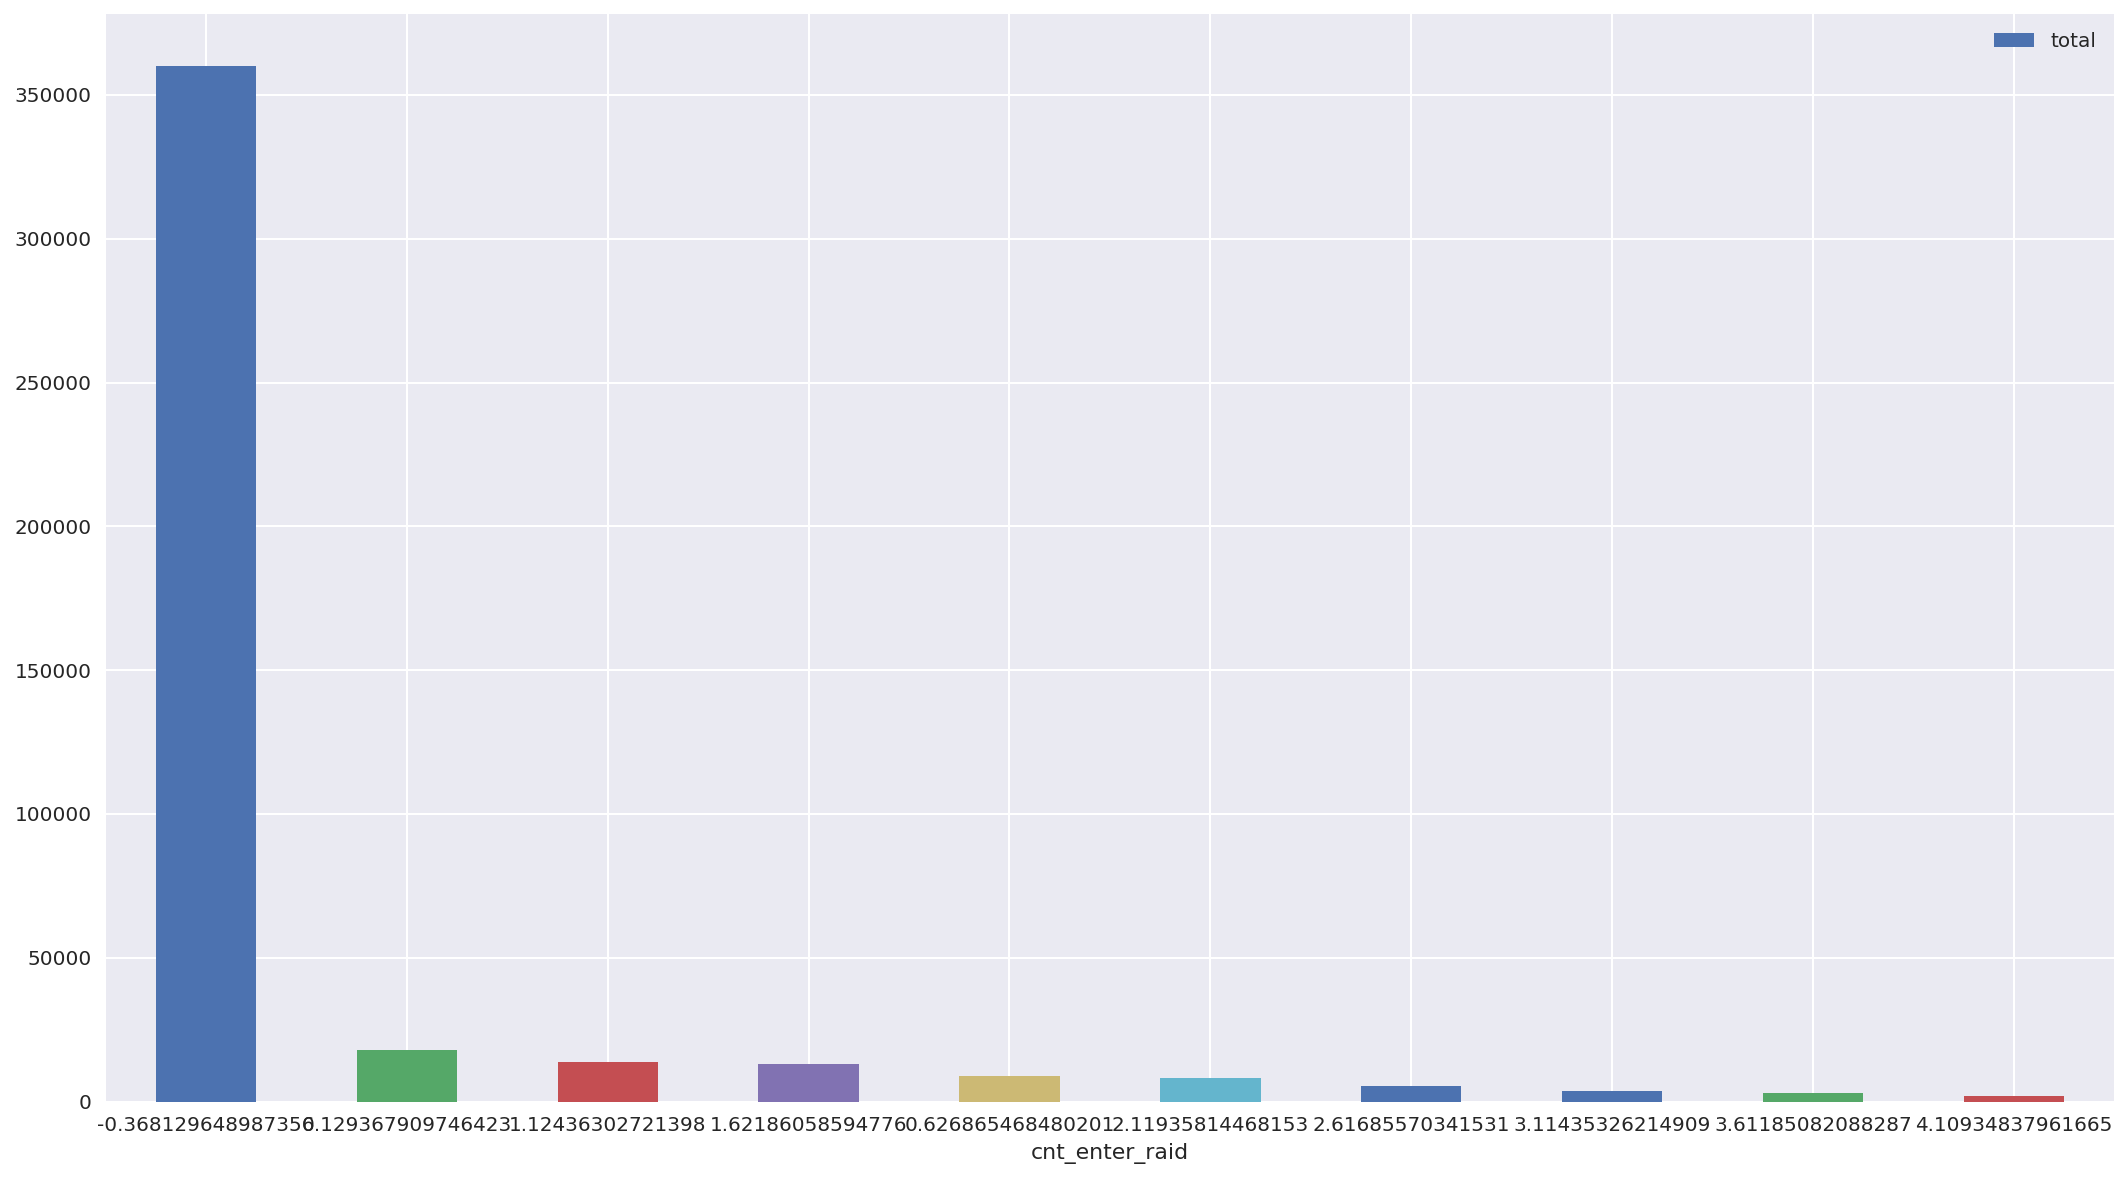

col :  cnt_enter_raid_light


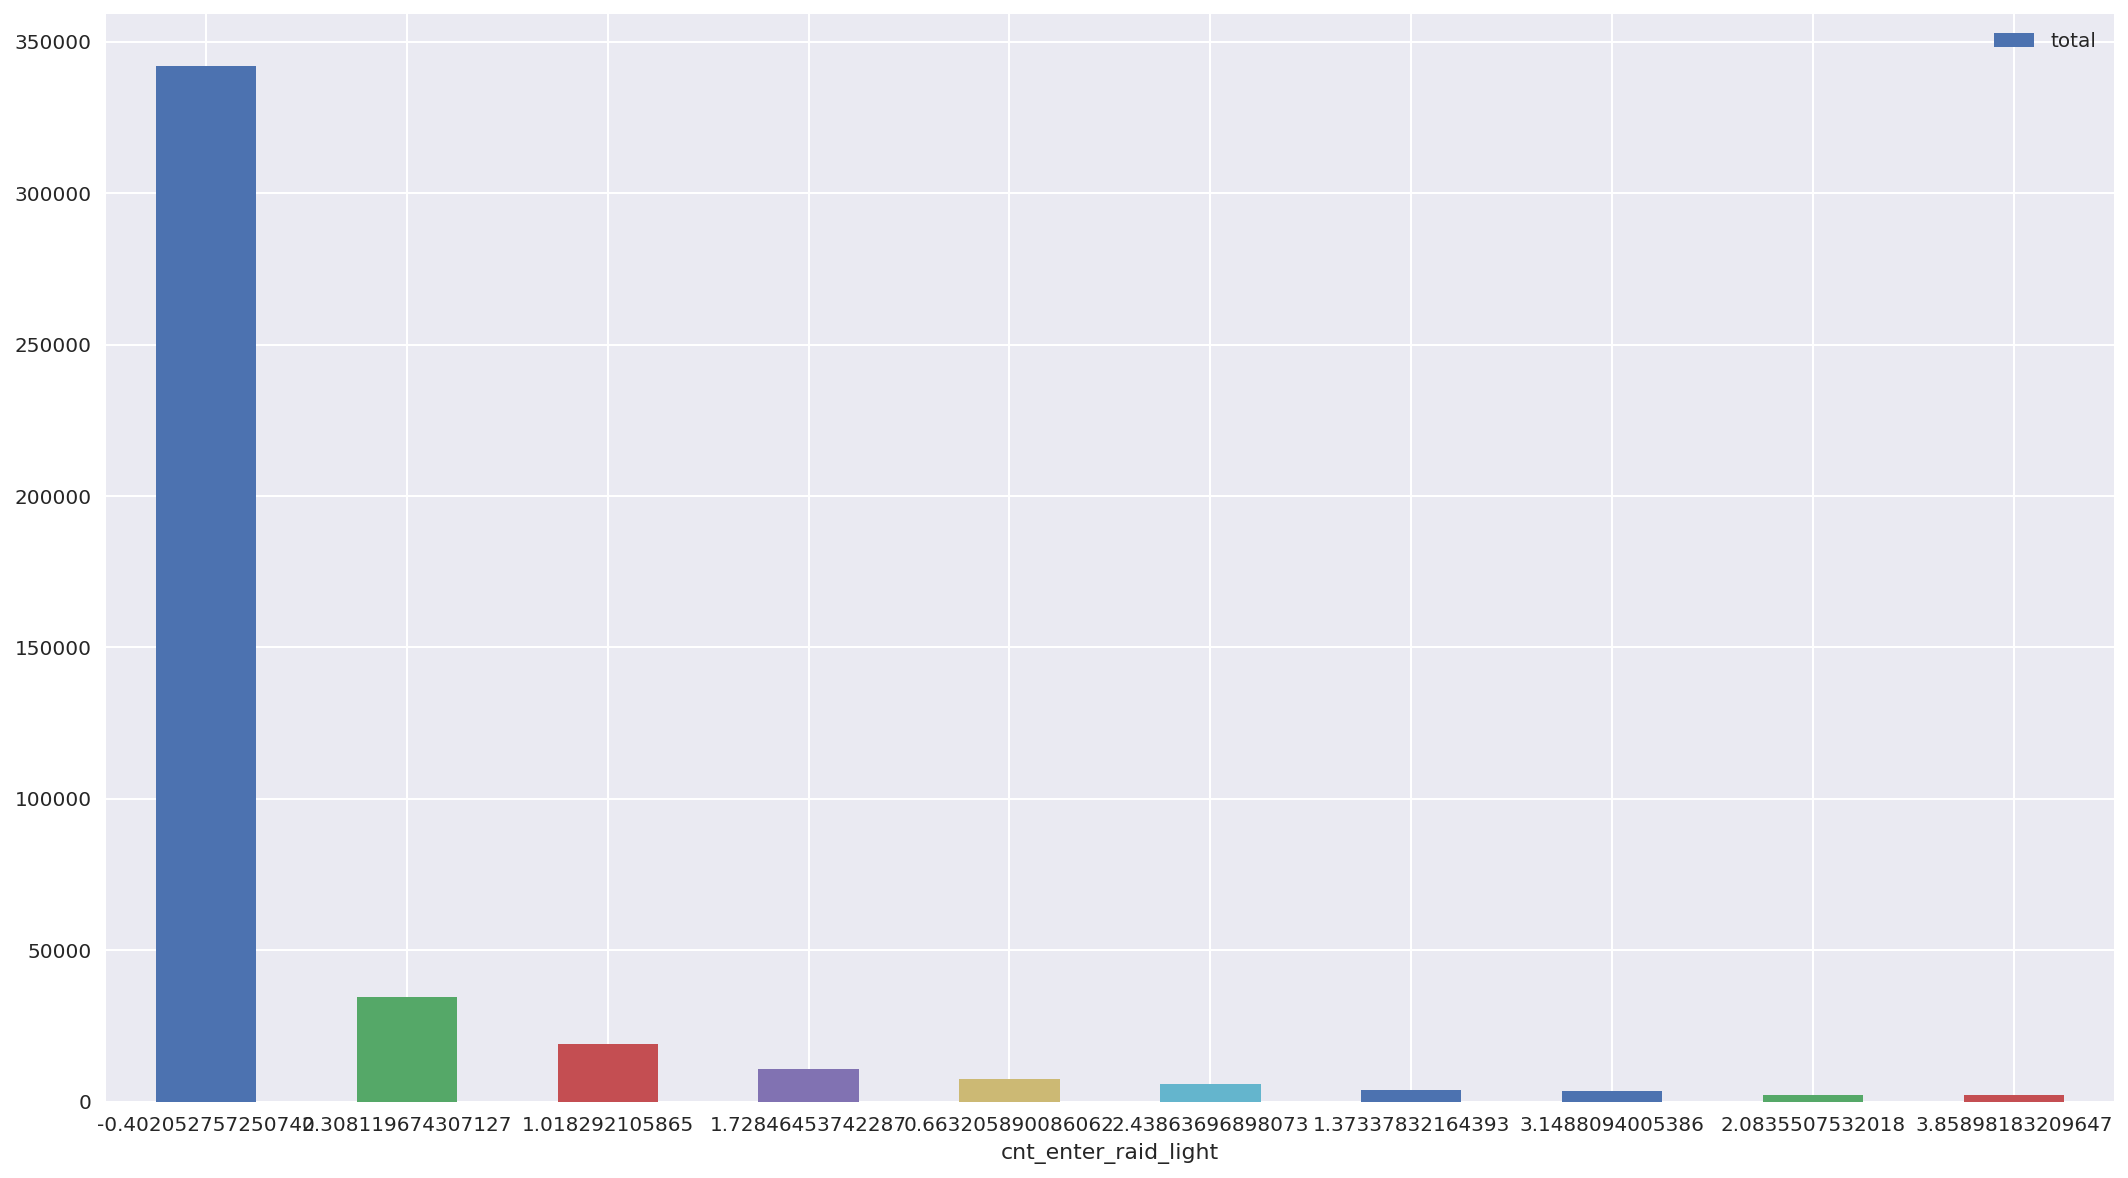

col :  cnt_enter_bam


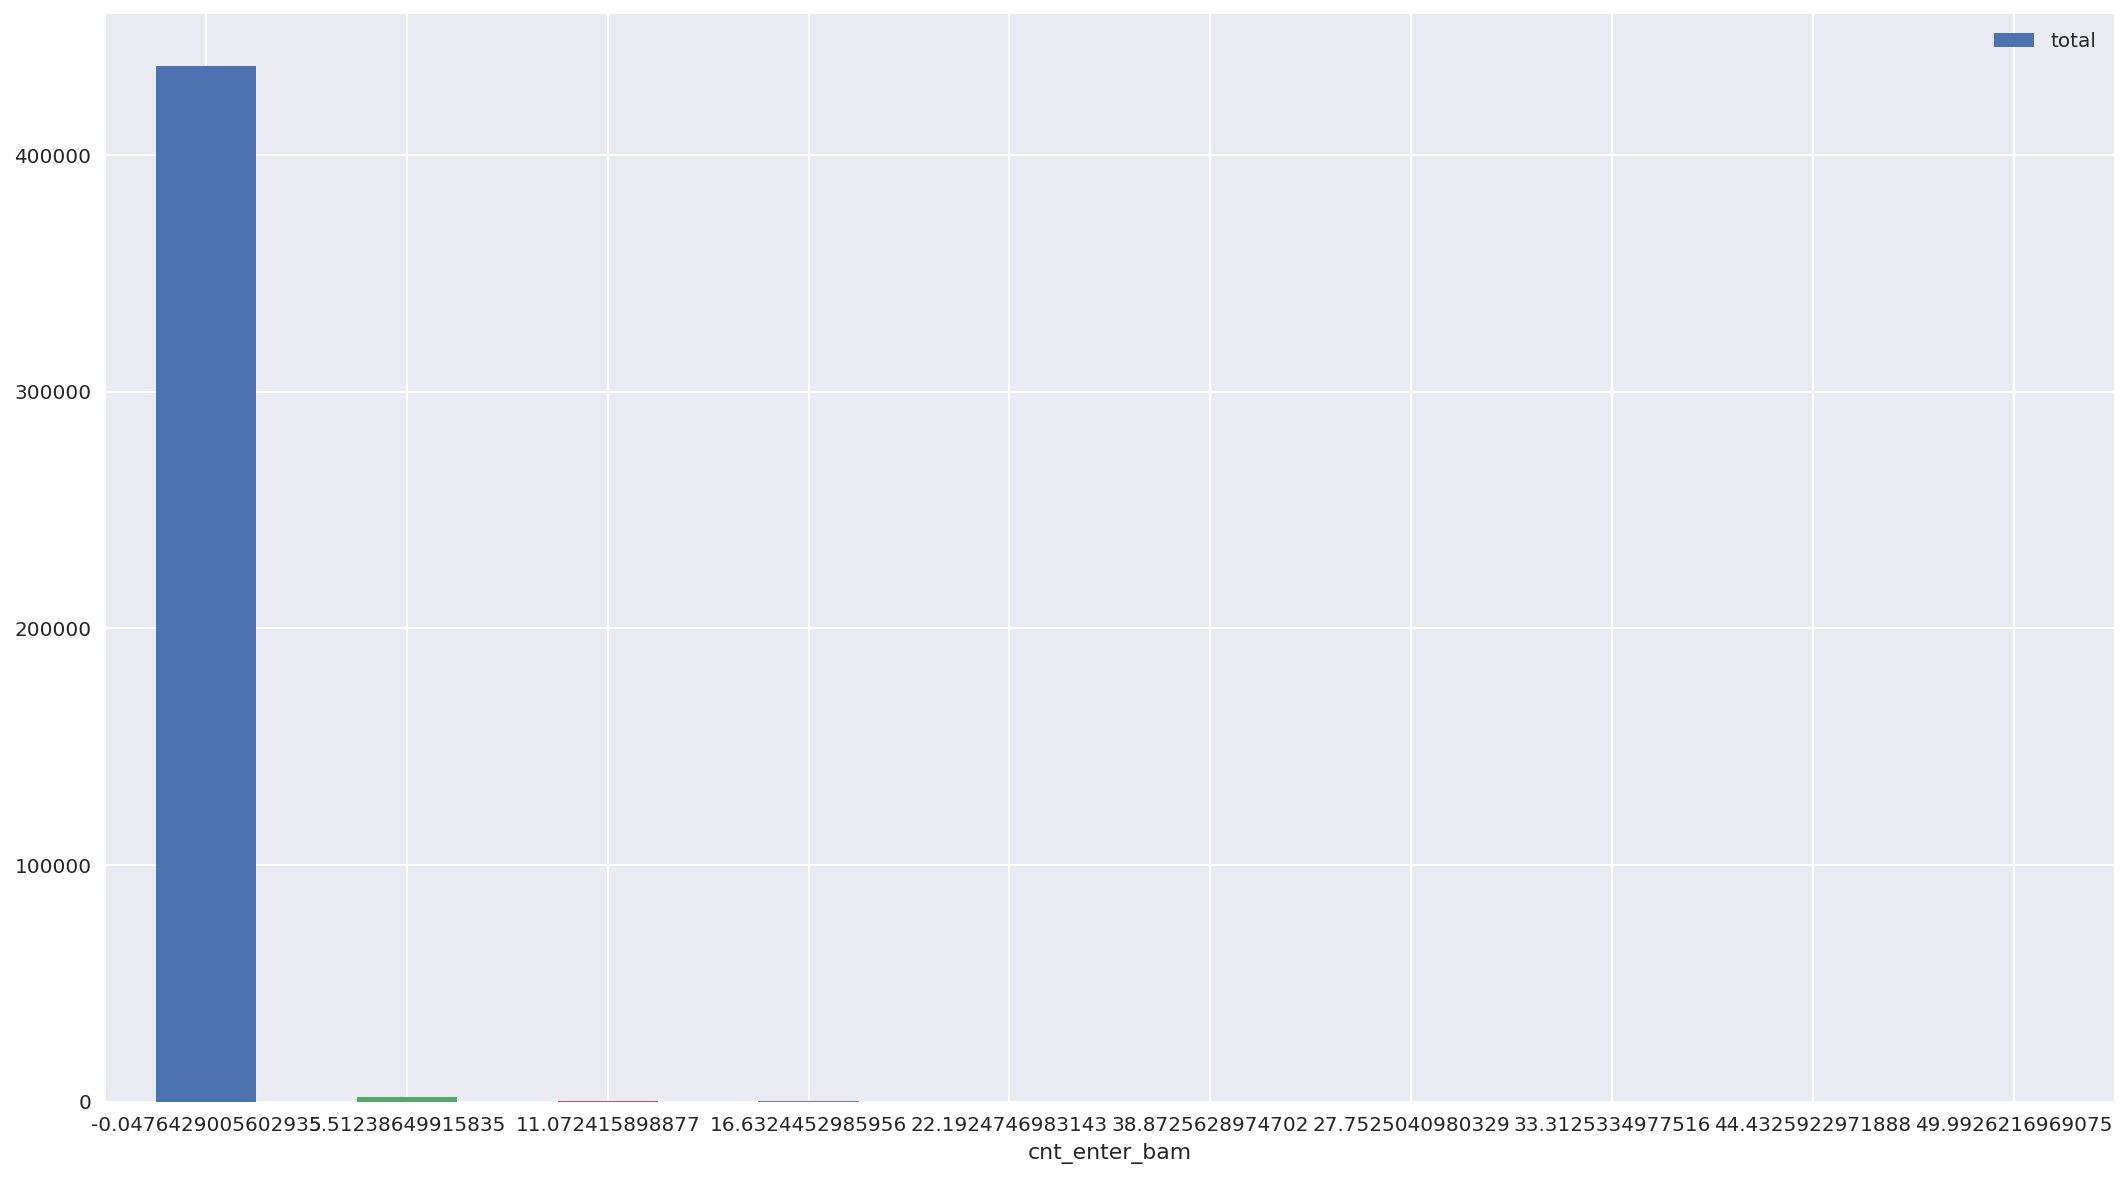

col :  cnt_clear_inzone_solo


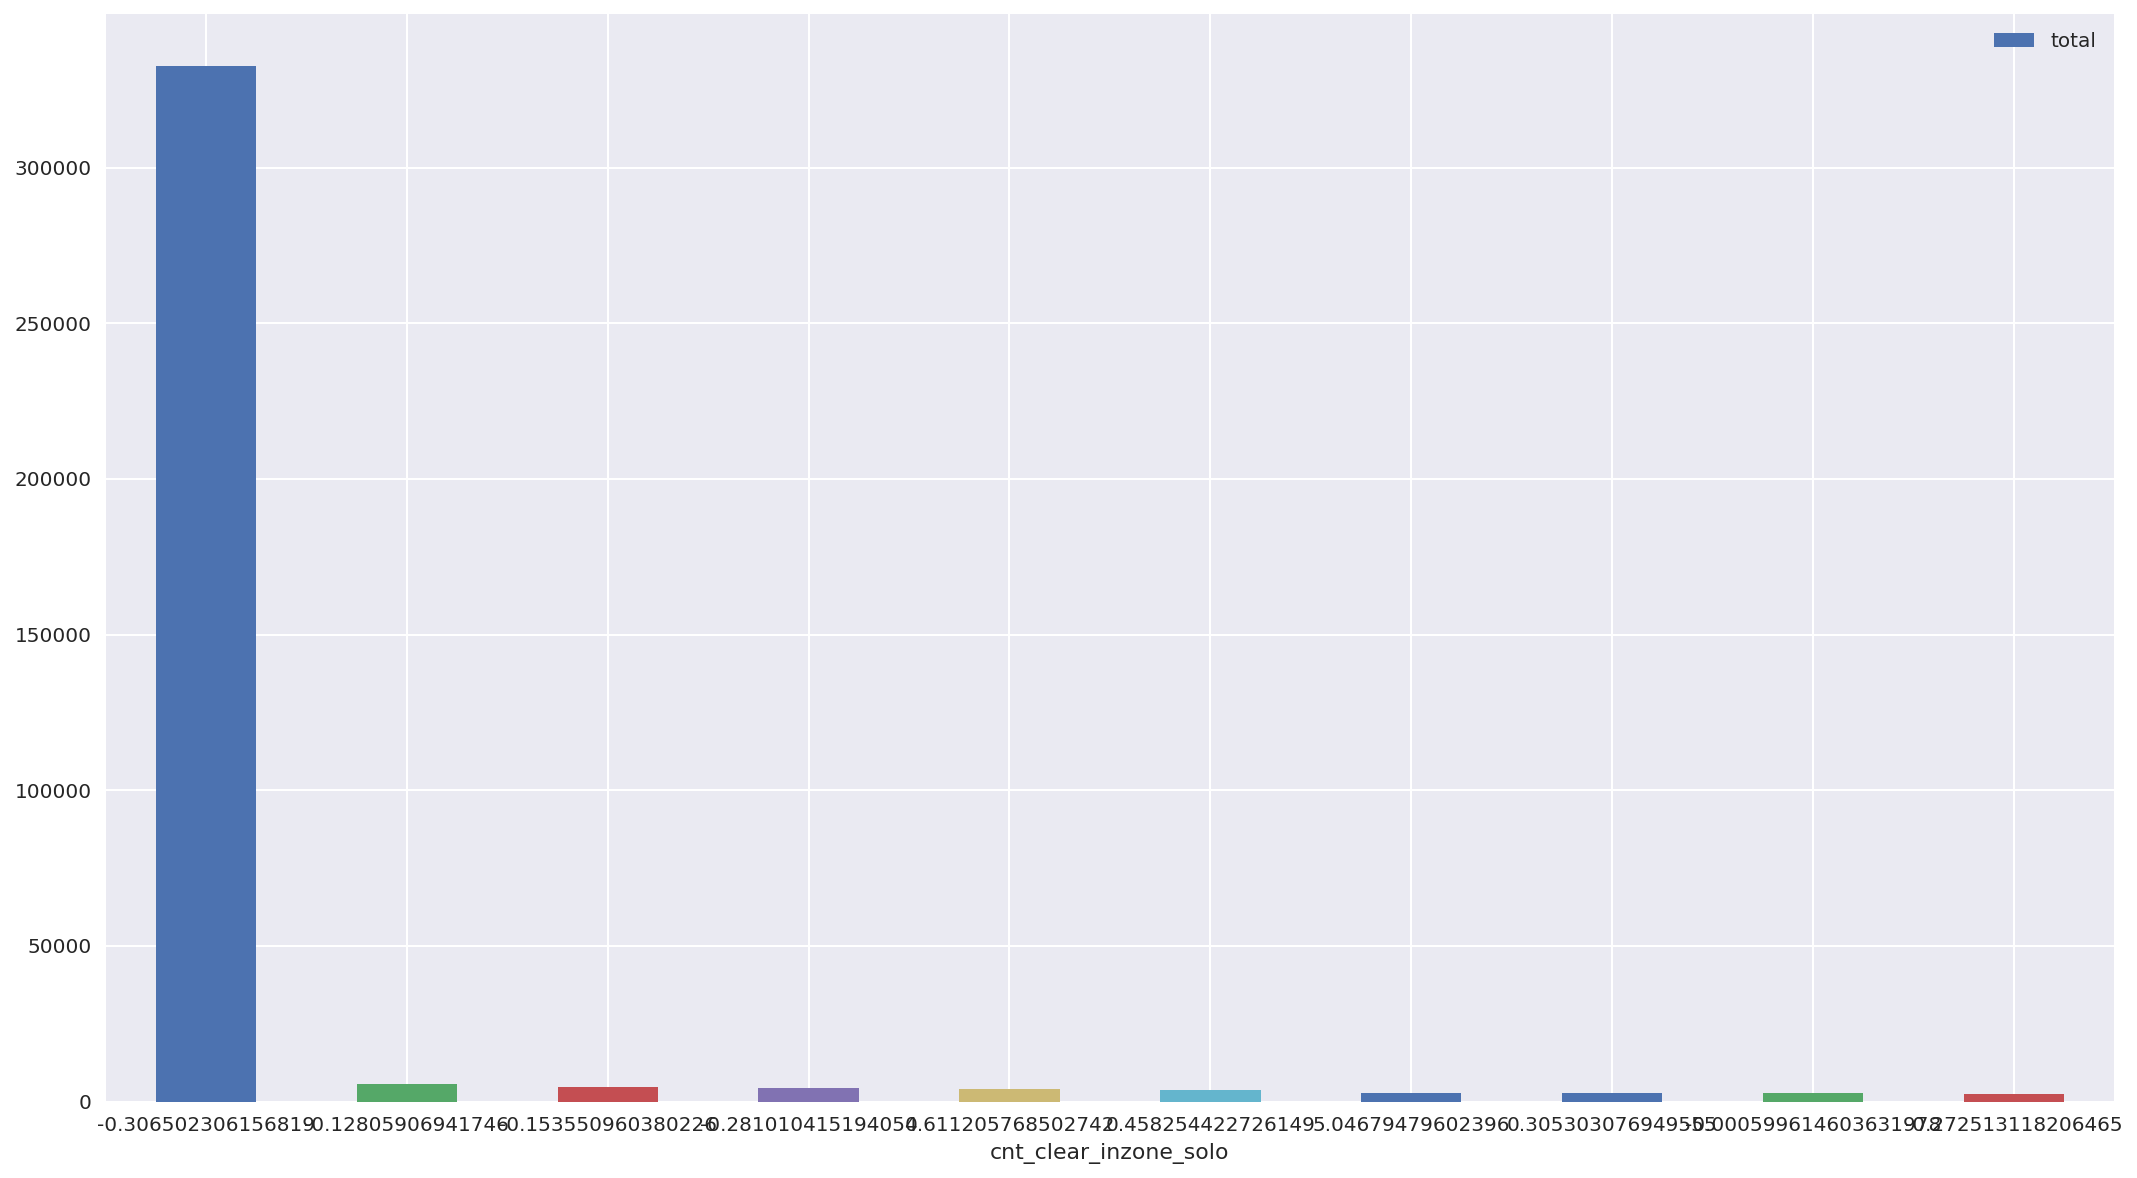

col :  cnt_clear_inzone_light


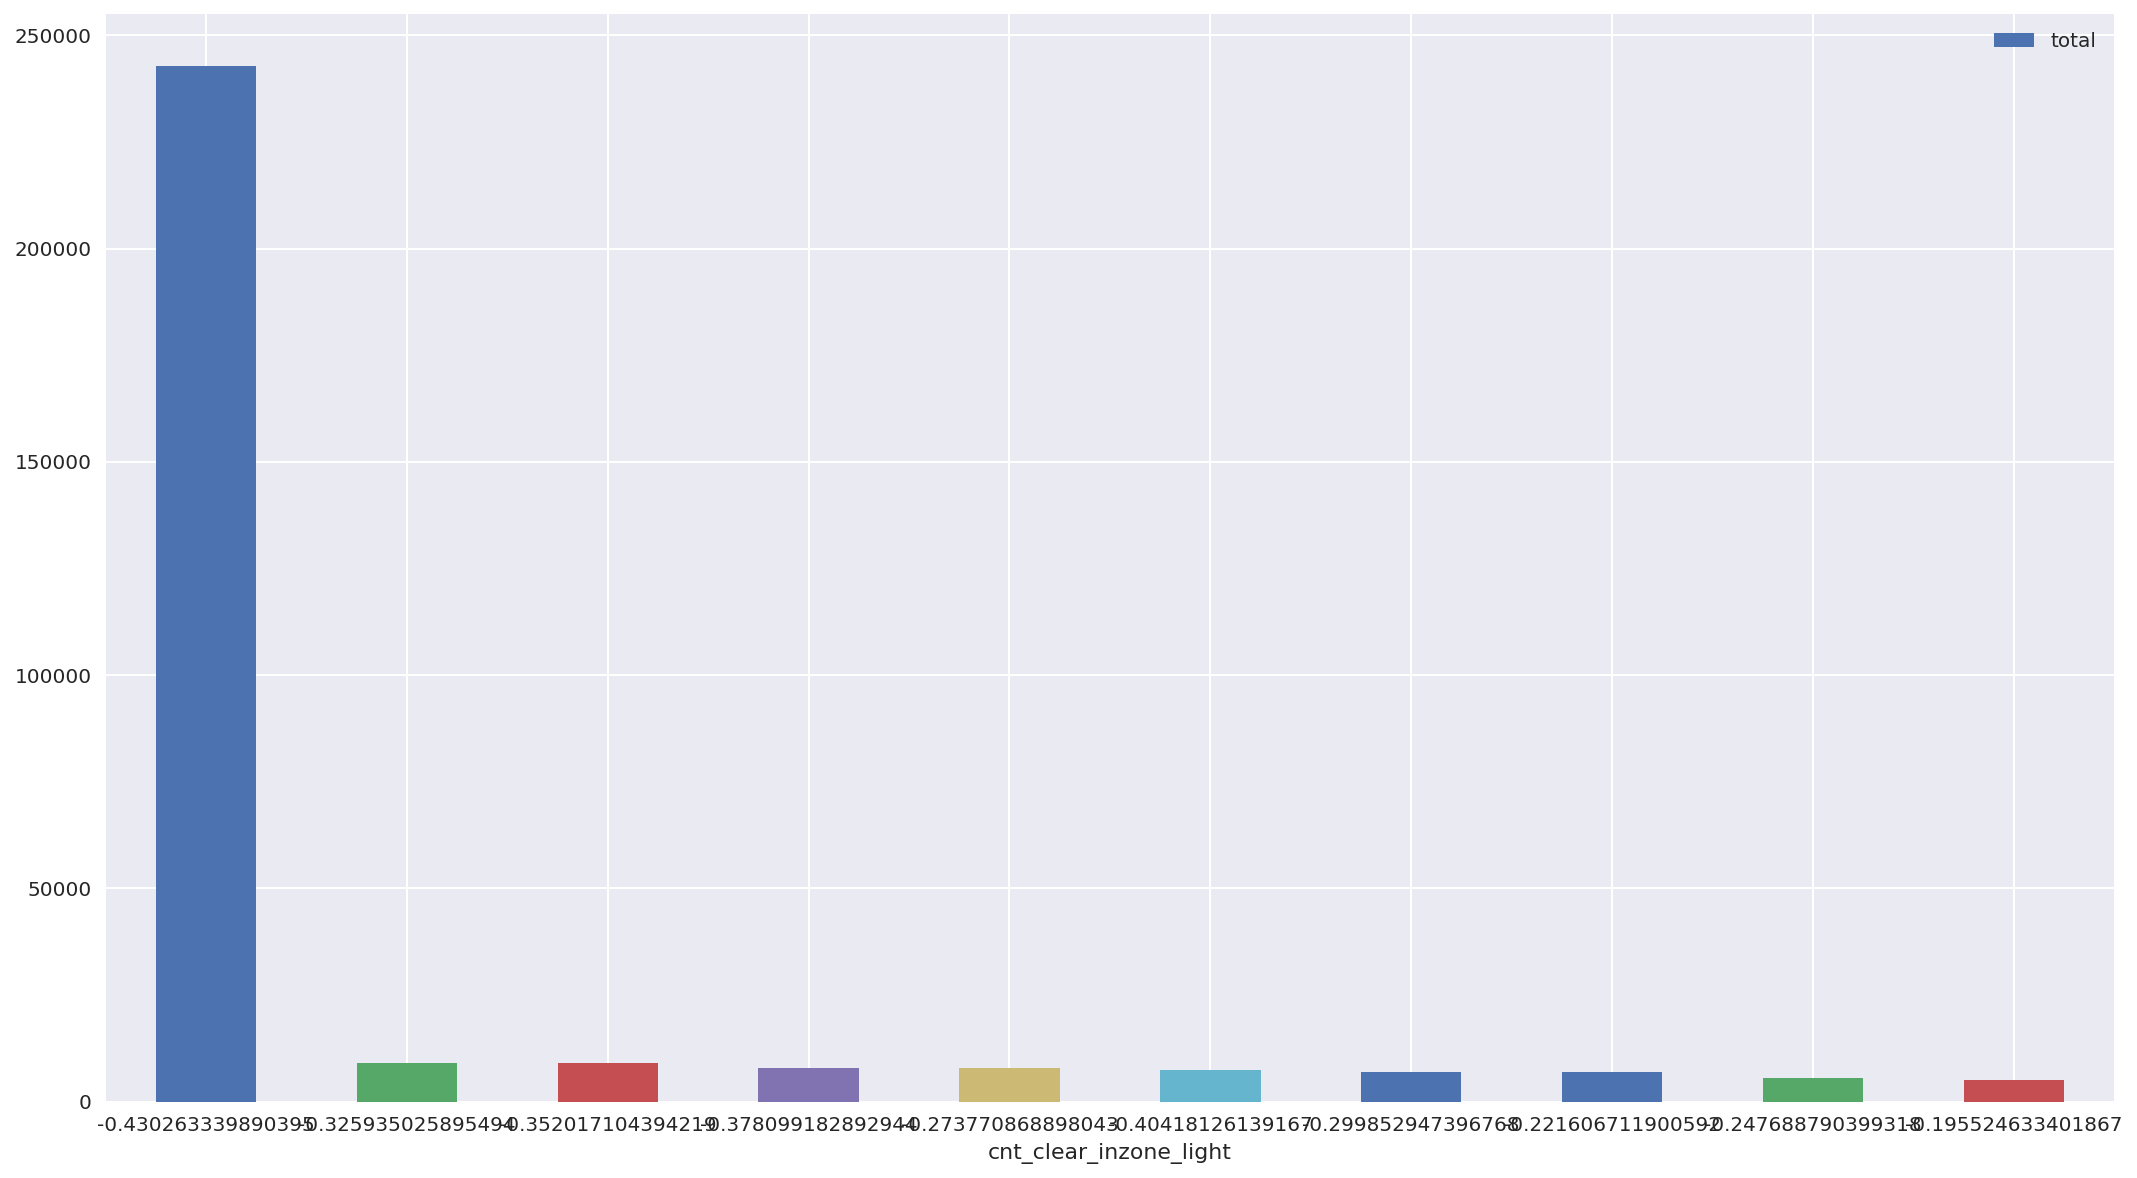

col :  cnt_clear_inzone_skilled


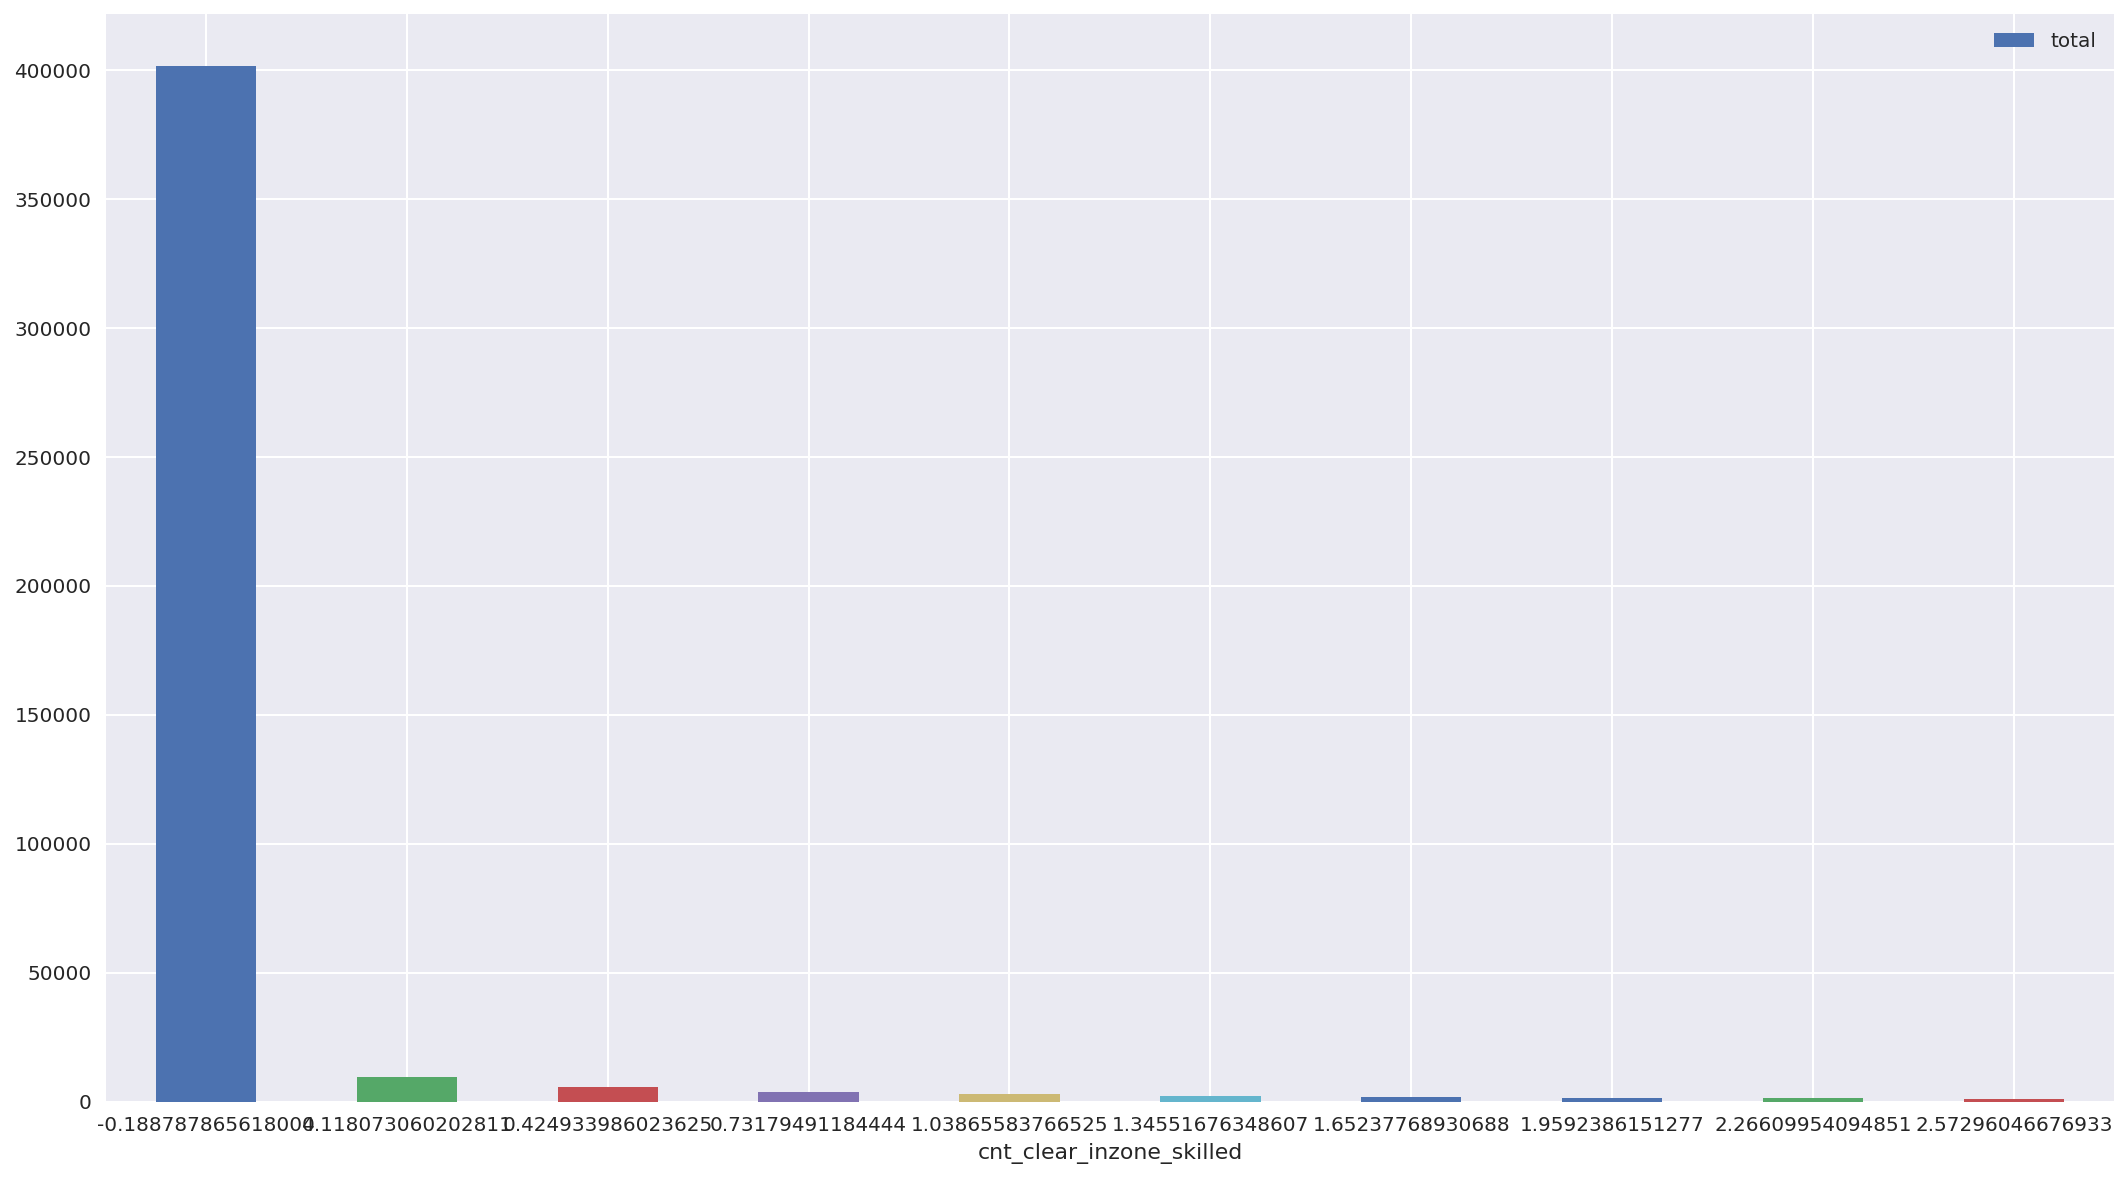

col :  cnt_clear_inzone_normal


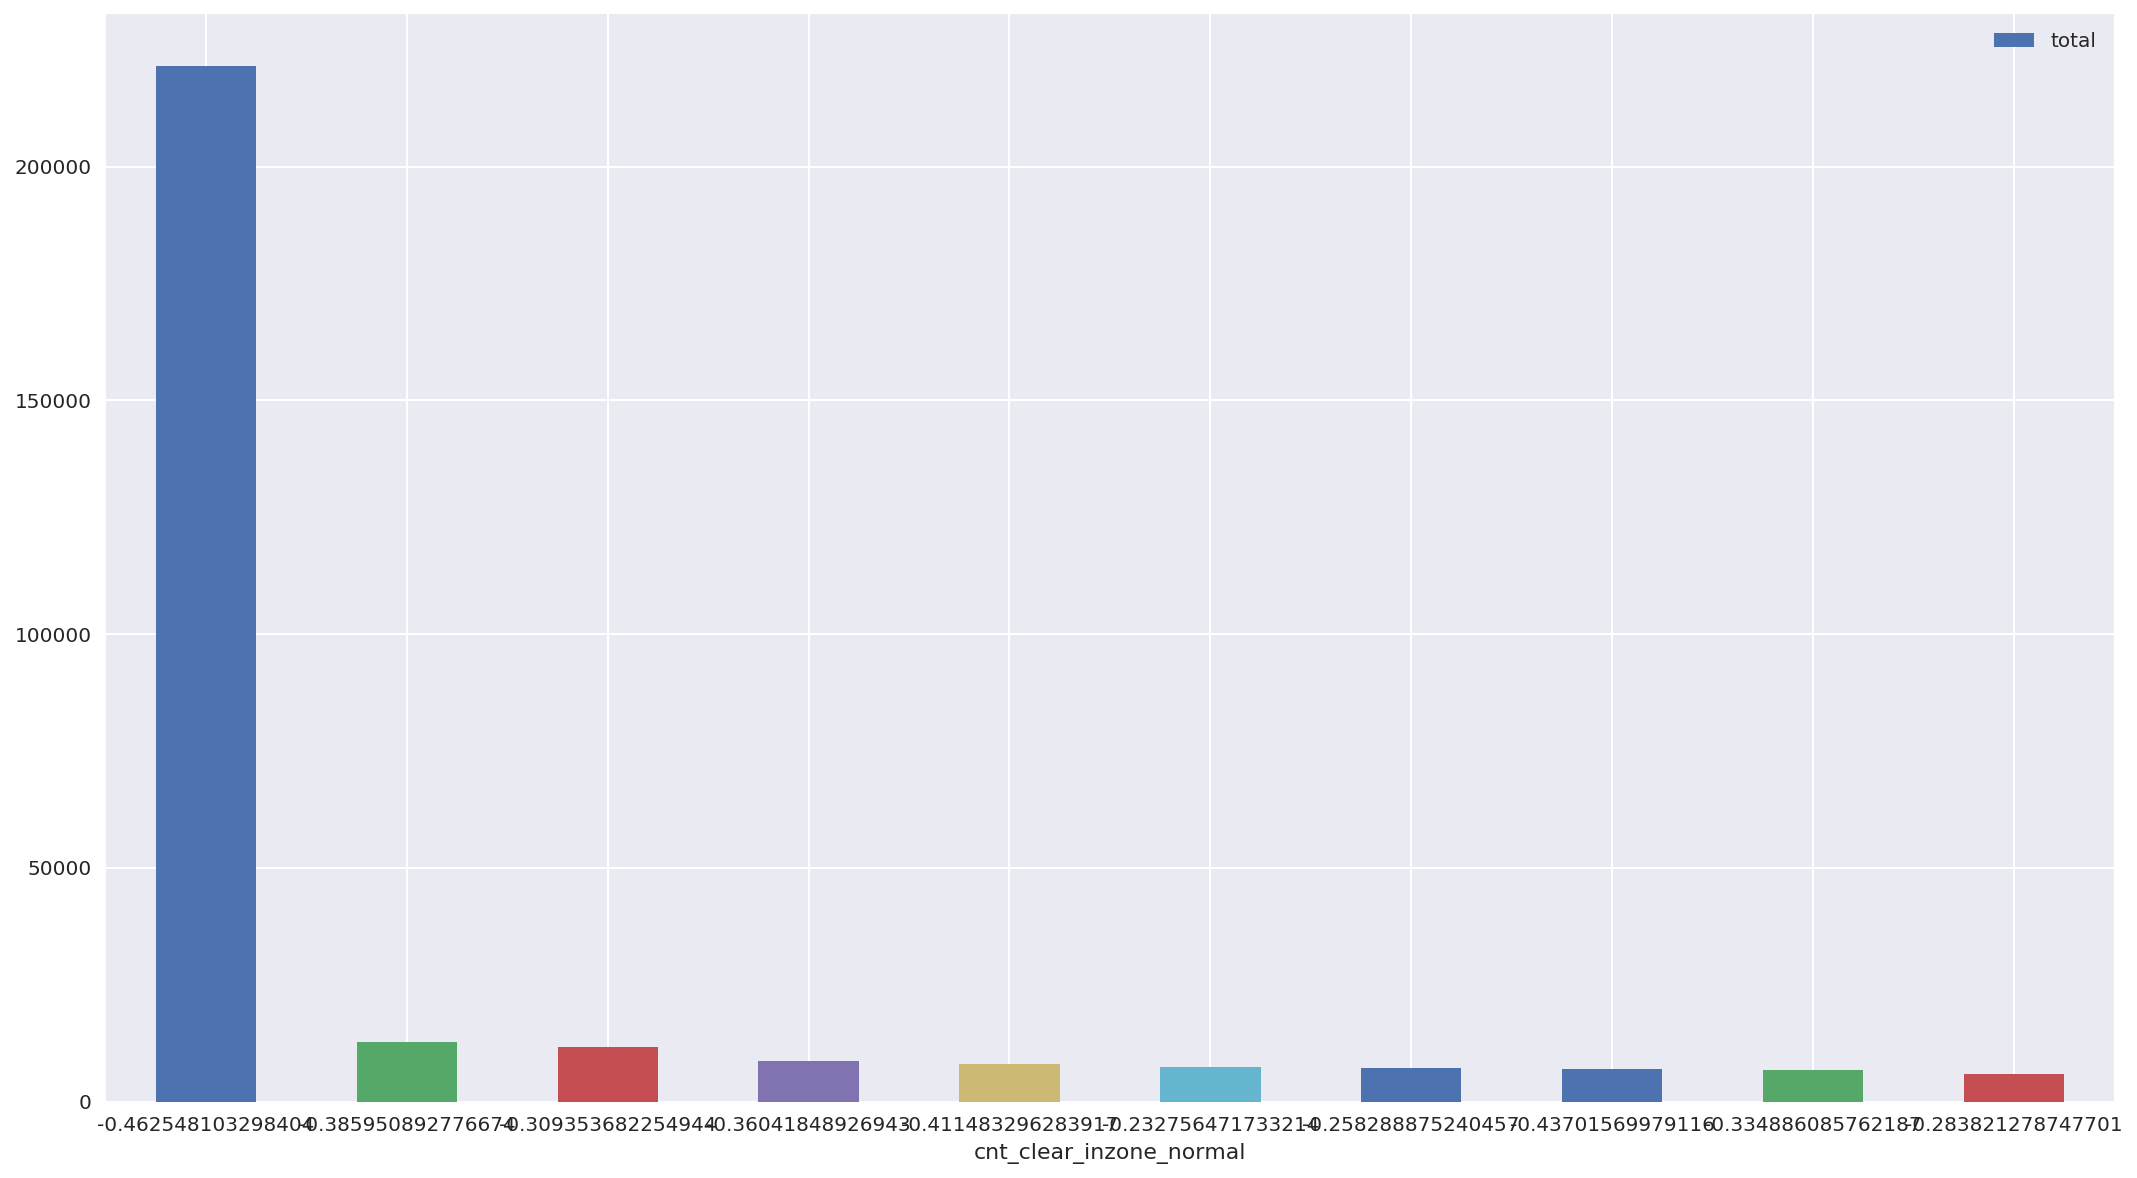

col :  cnt_clear_raid


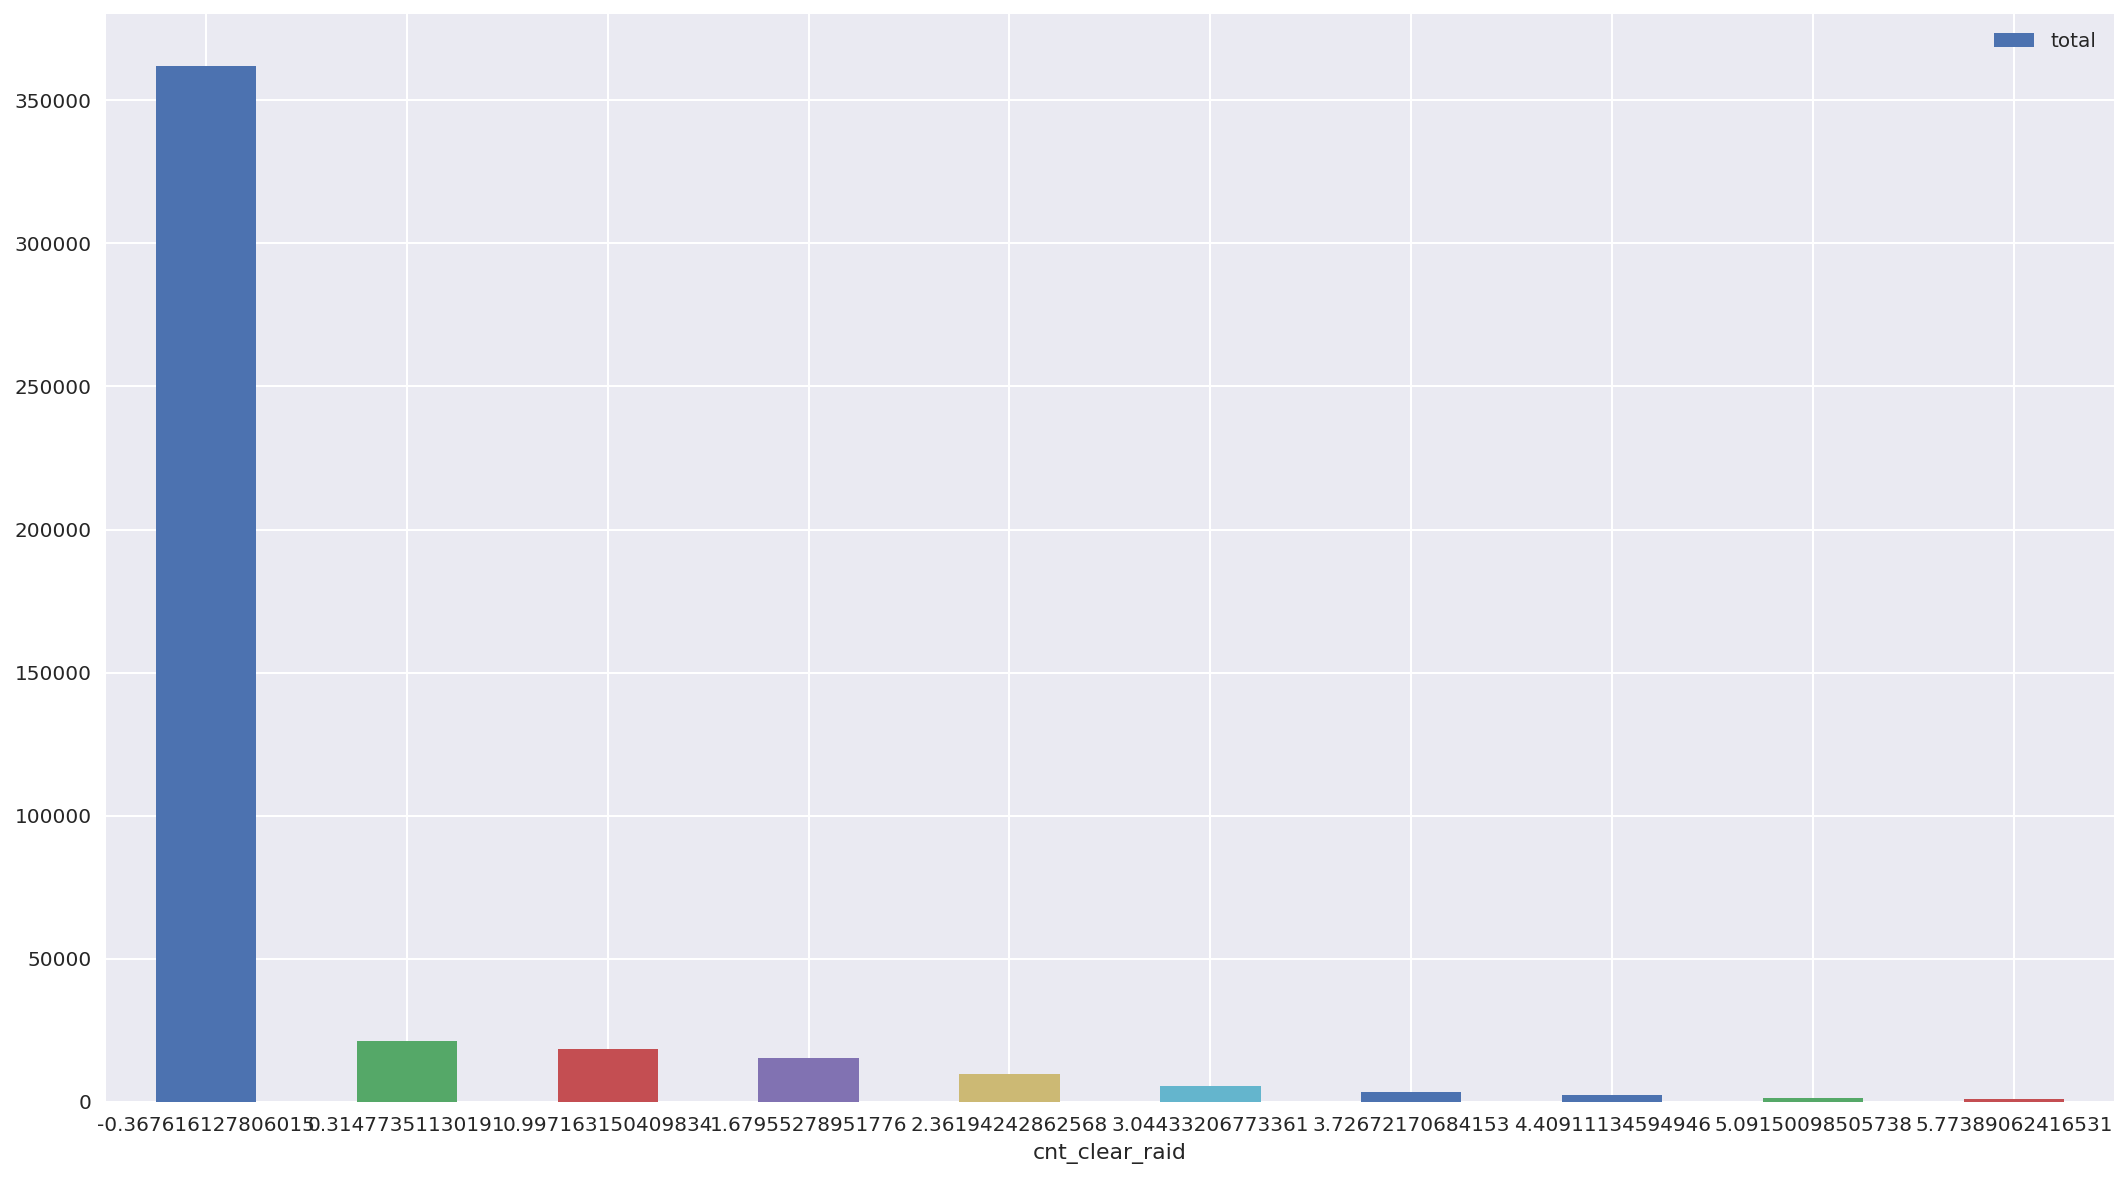

col :  cnt_clear_raid_light


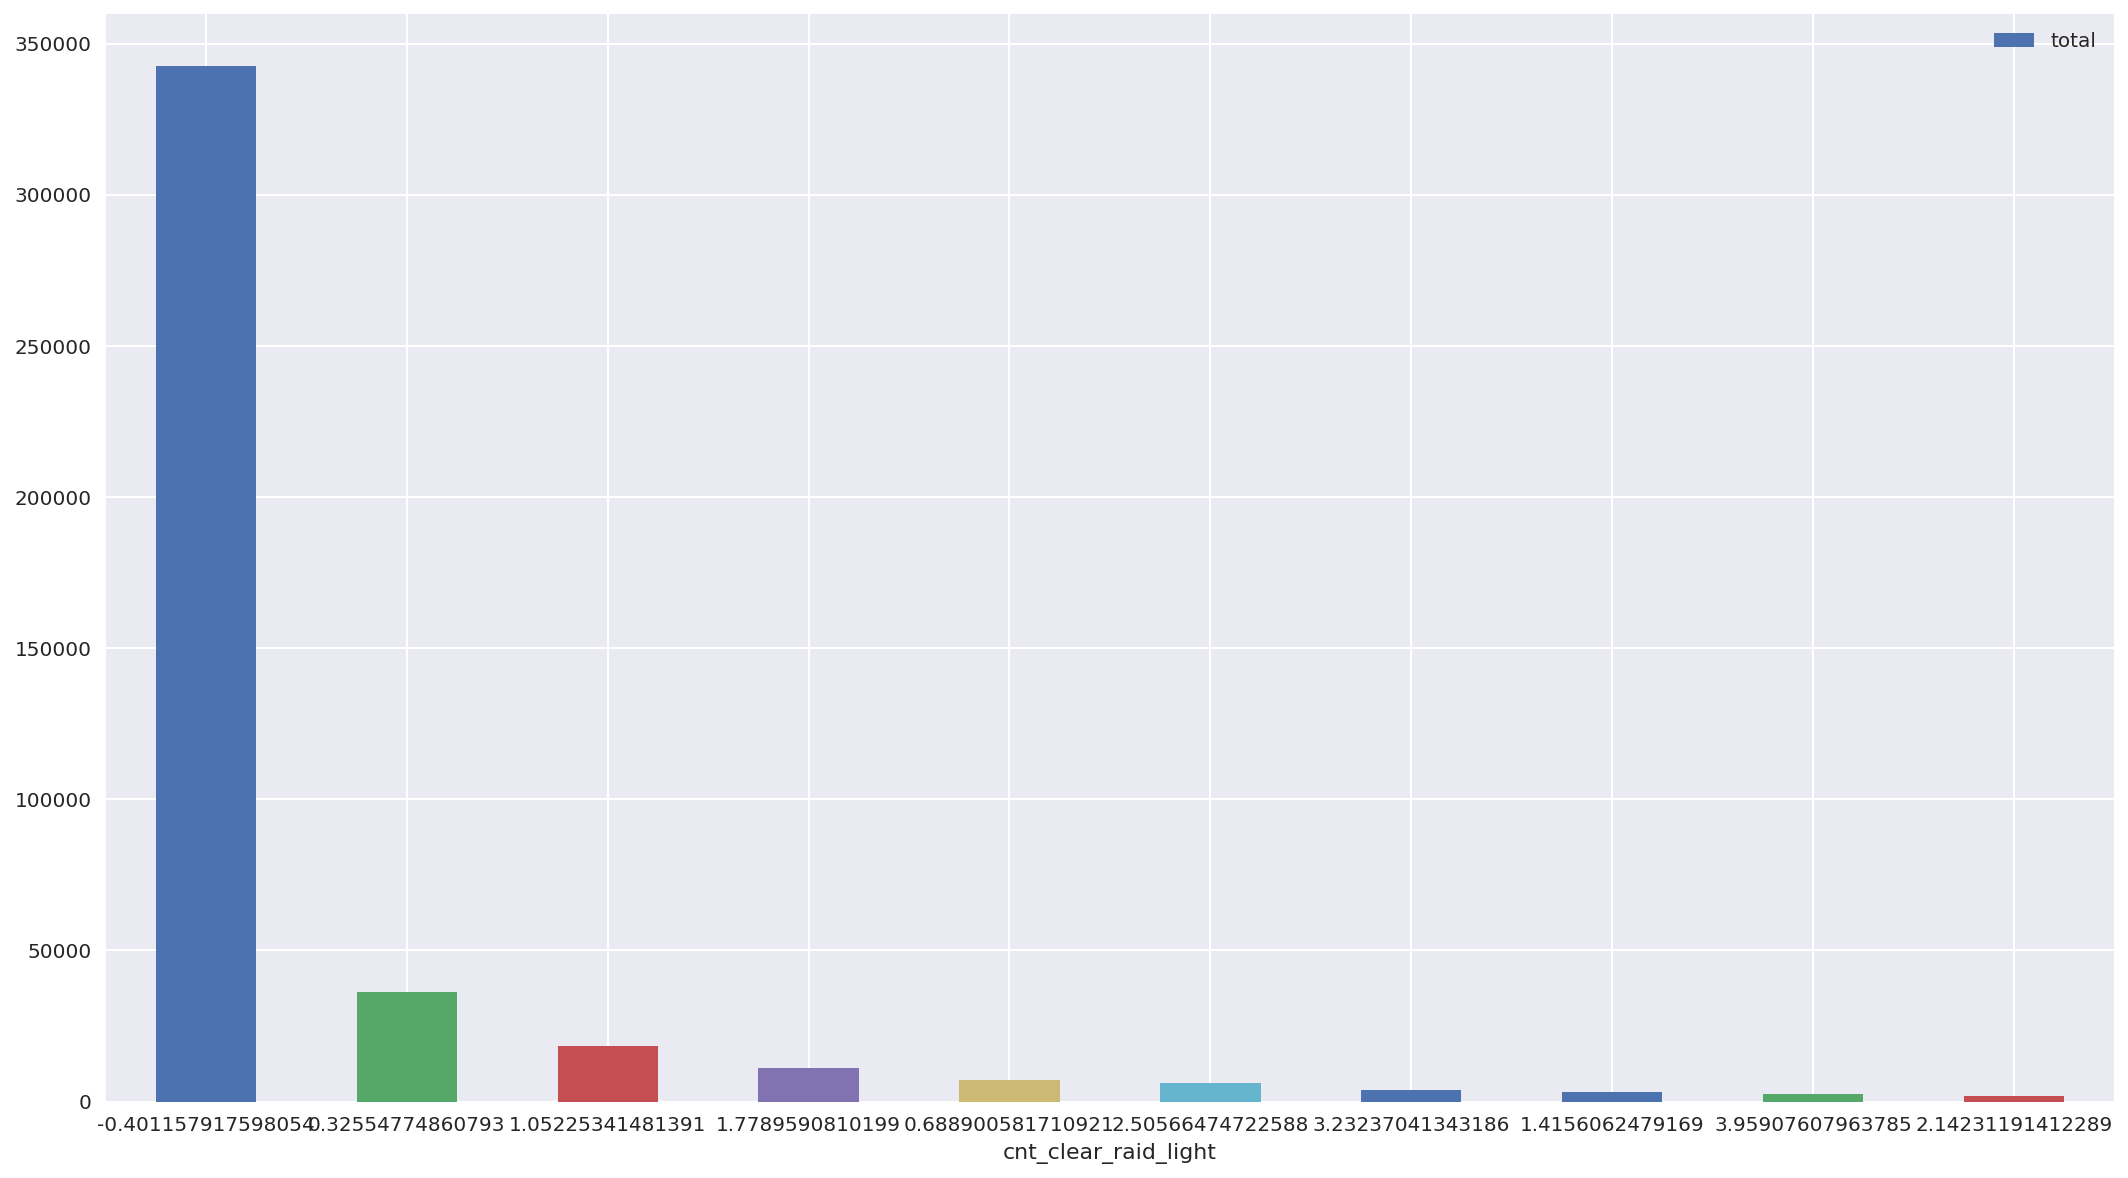

col :  cnt_clear_bam


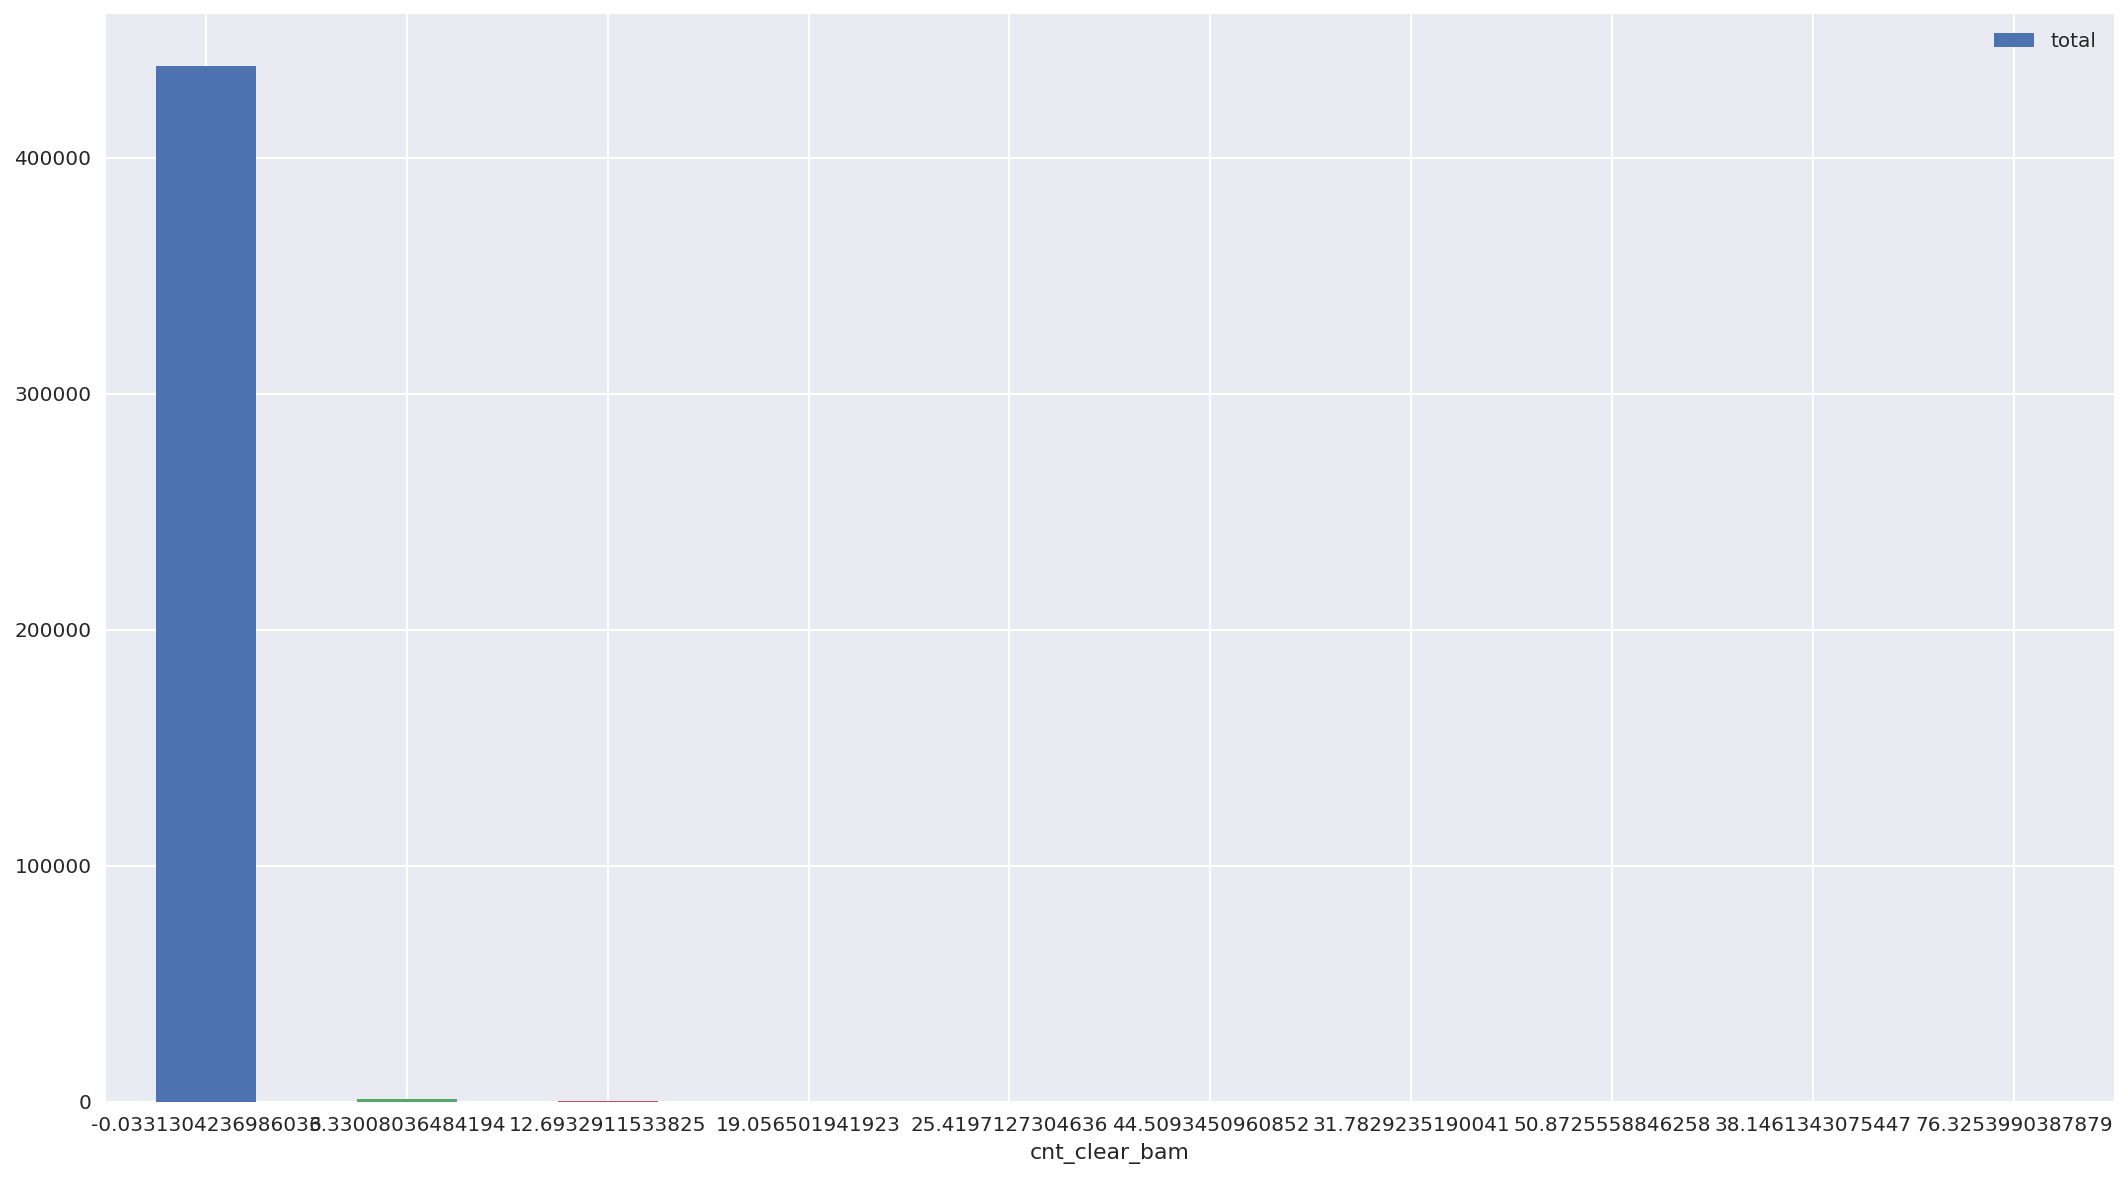

col :  normal_chat


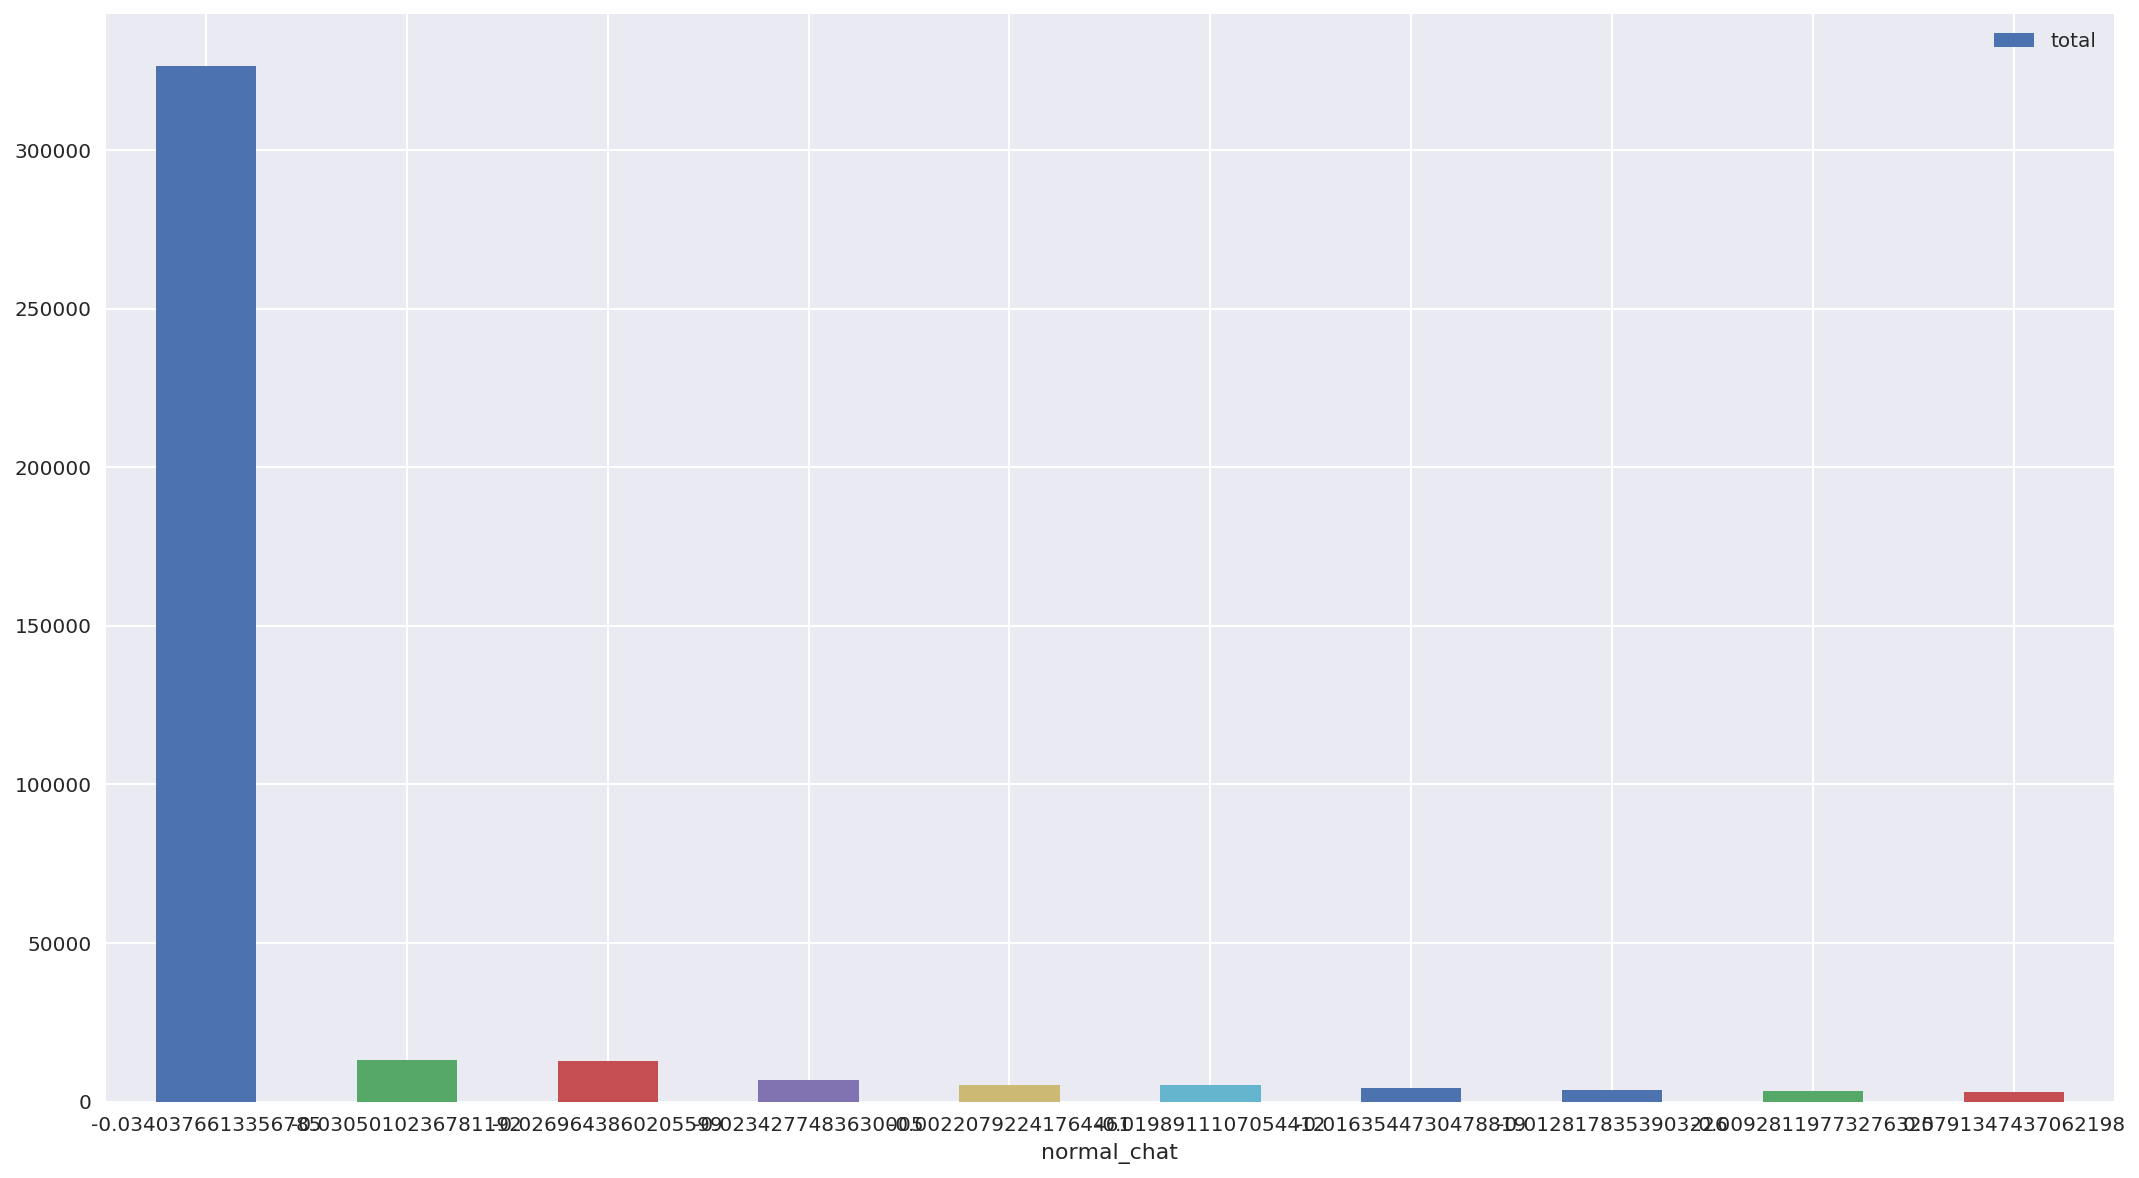

col :  whisper_chat


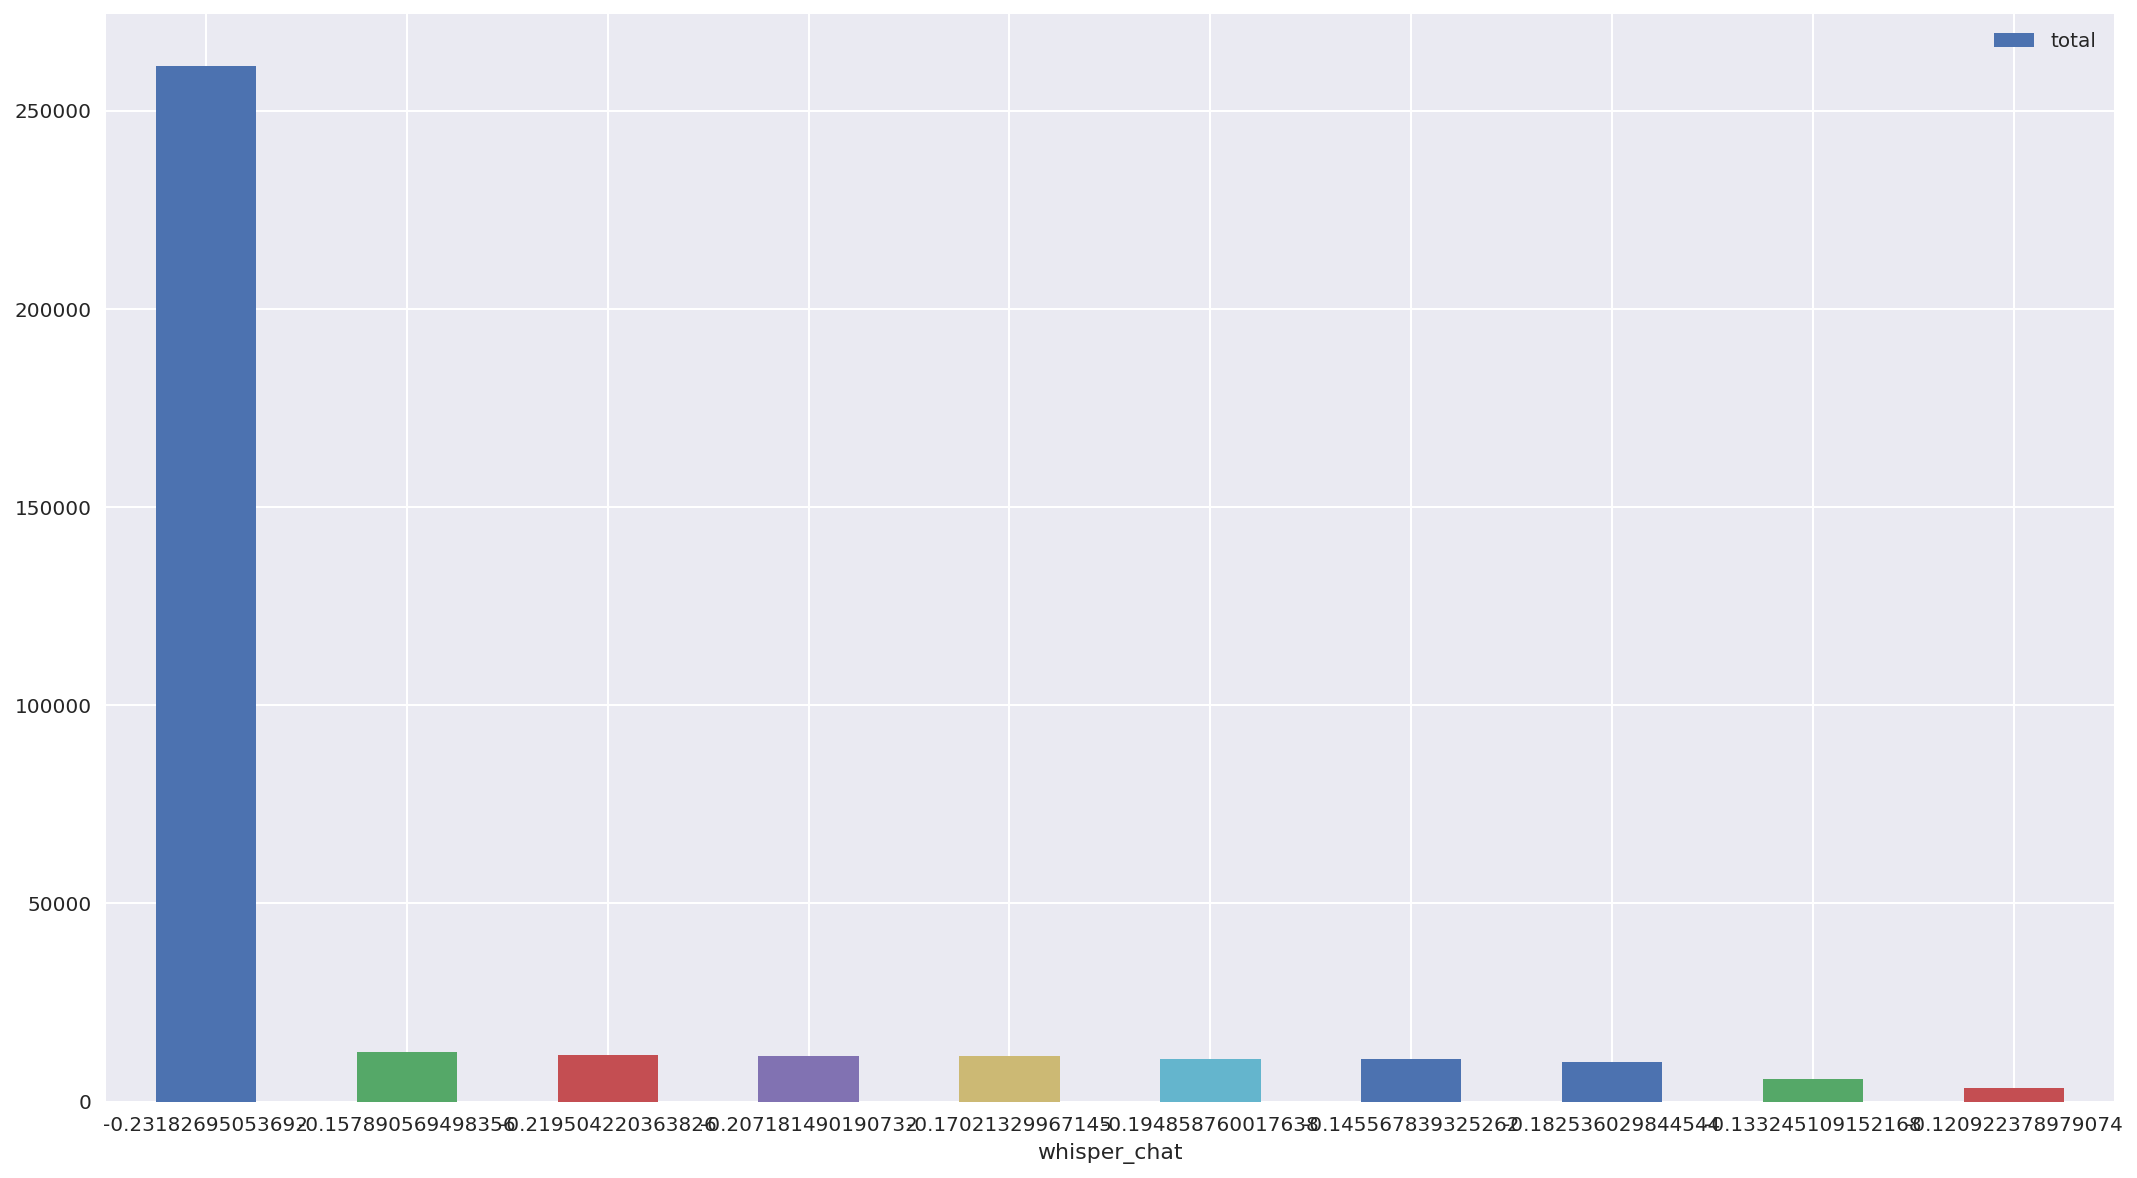

col :  district_chat


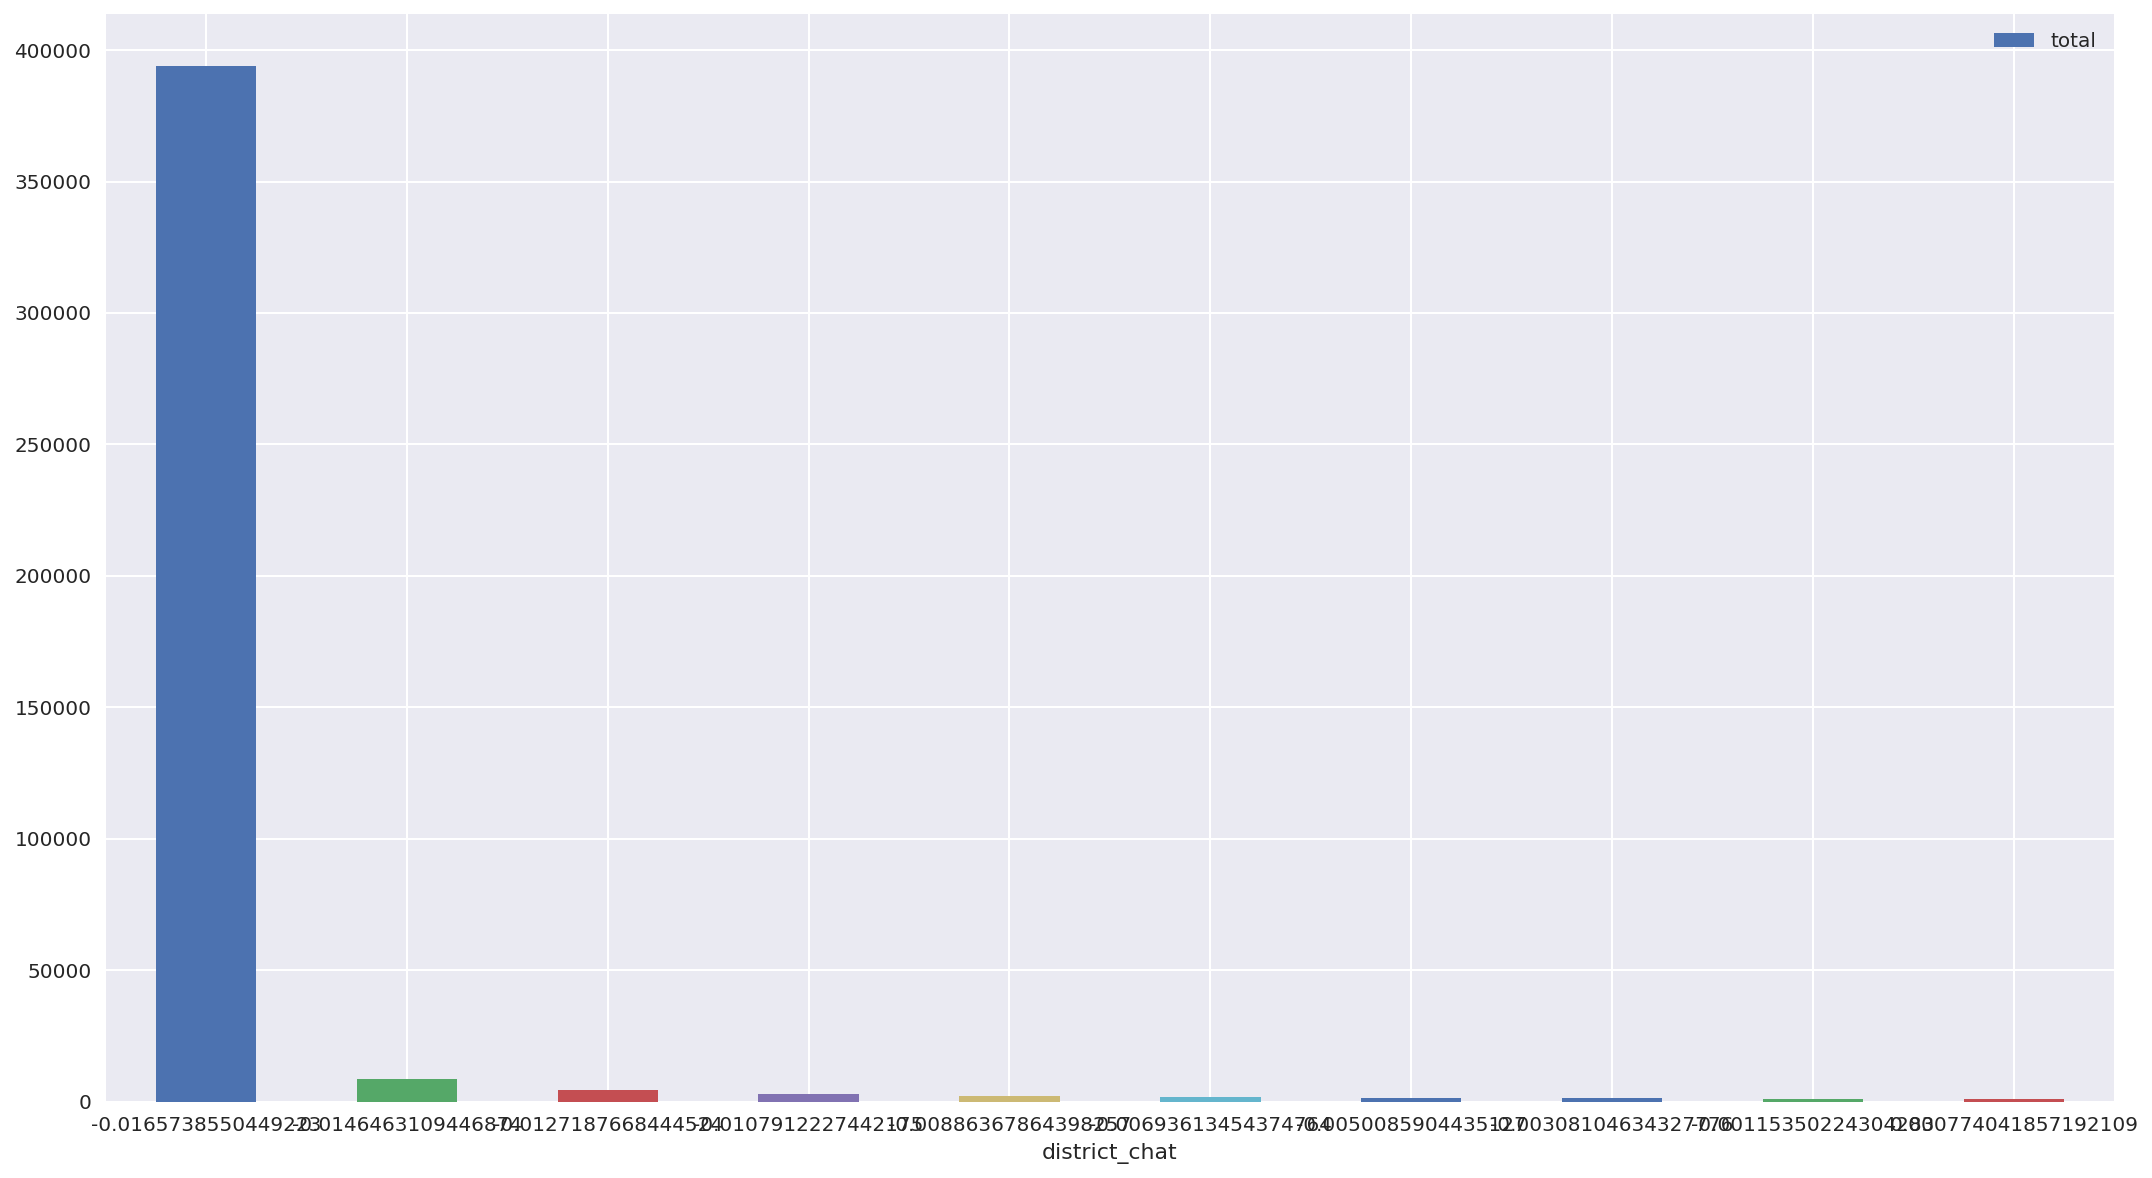

col :  party_chat


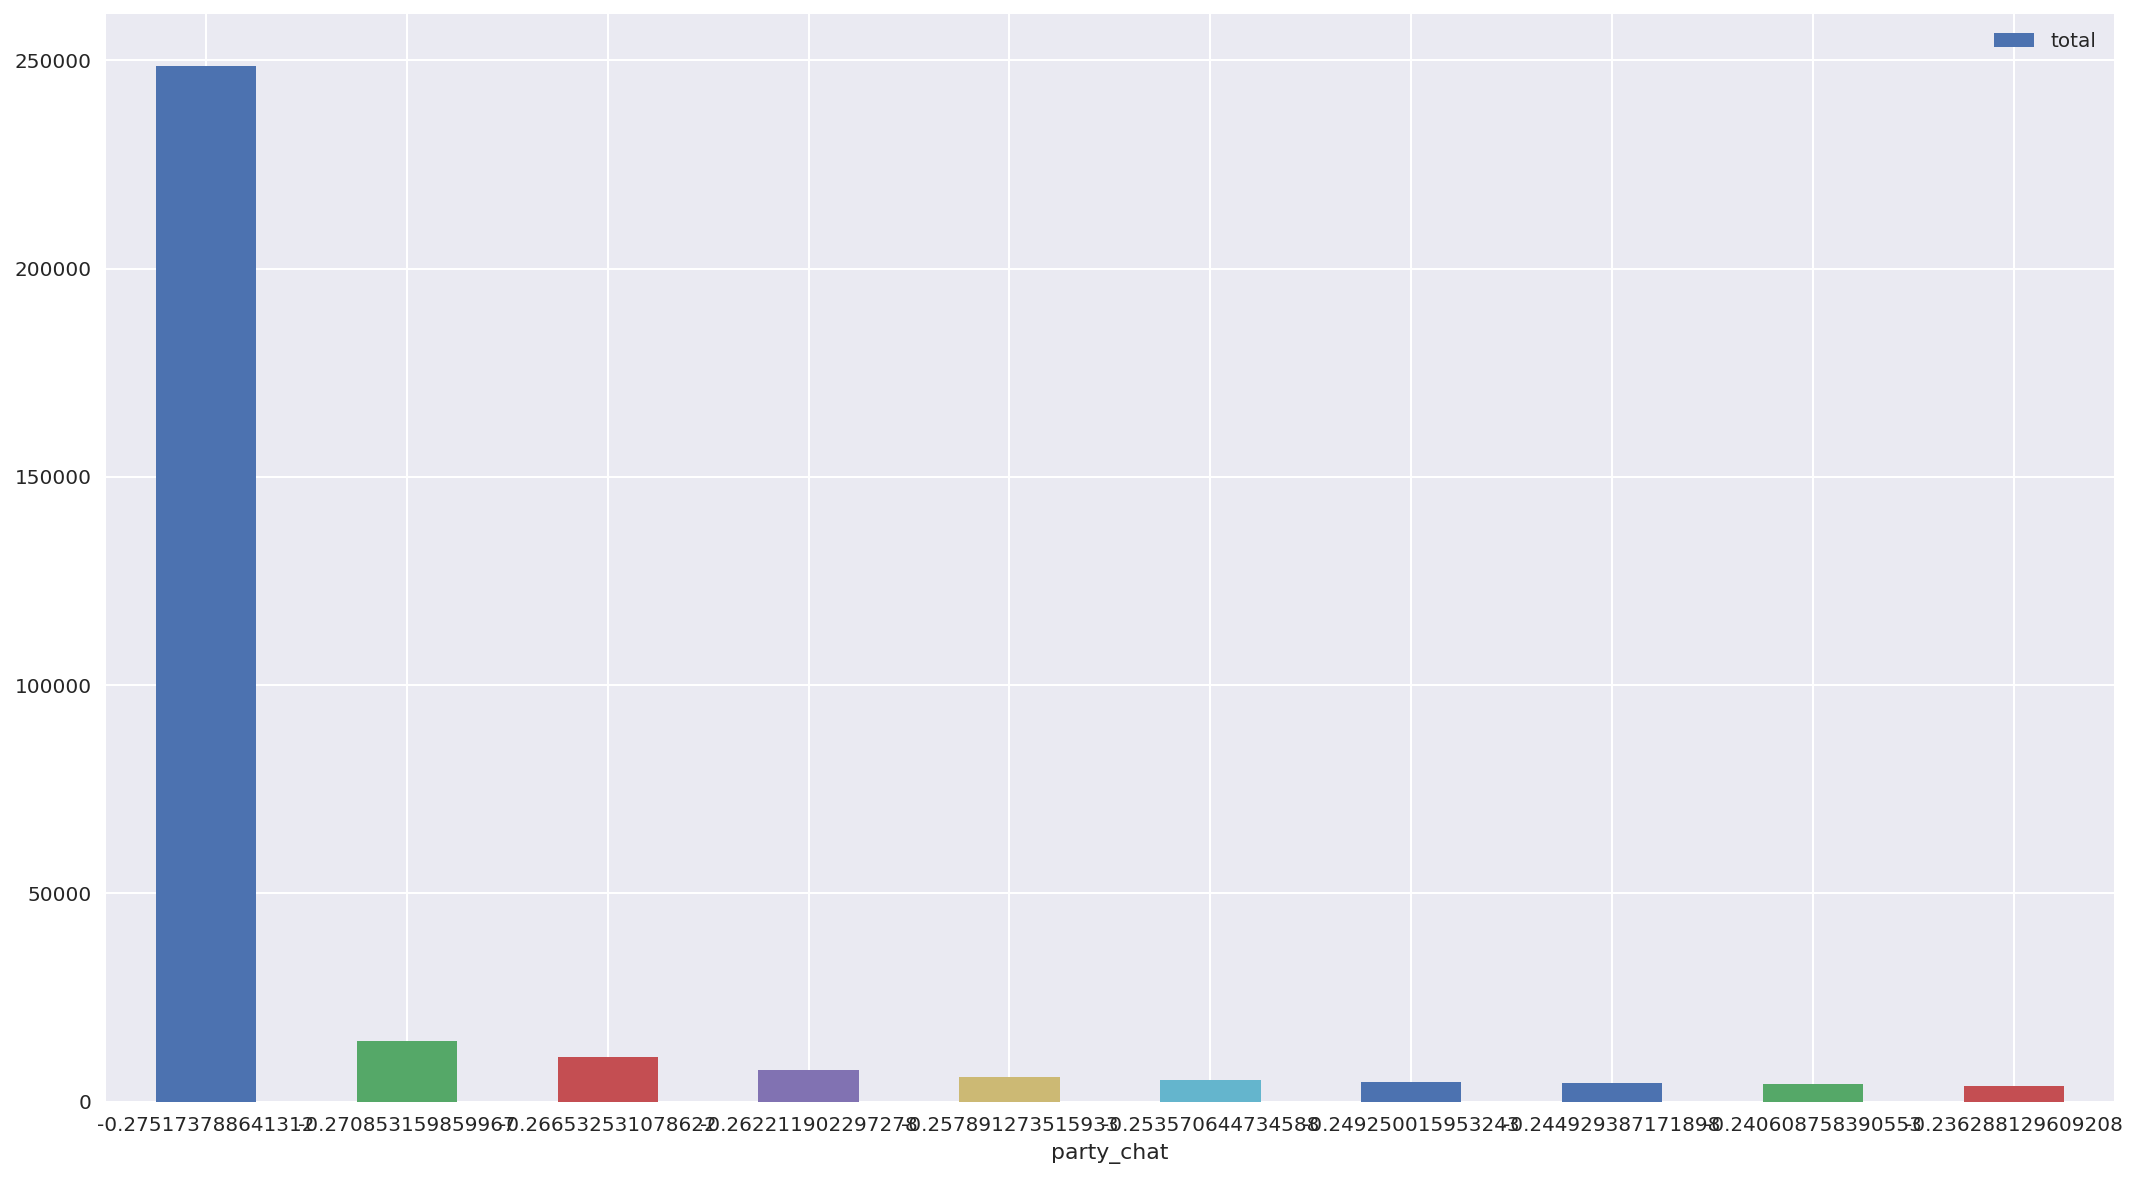

col :  guild_chat


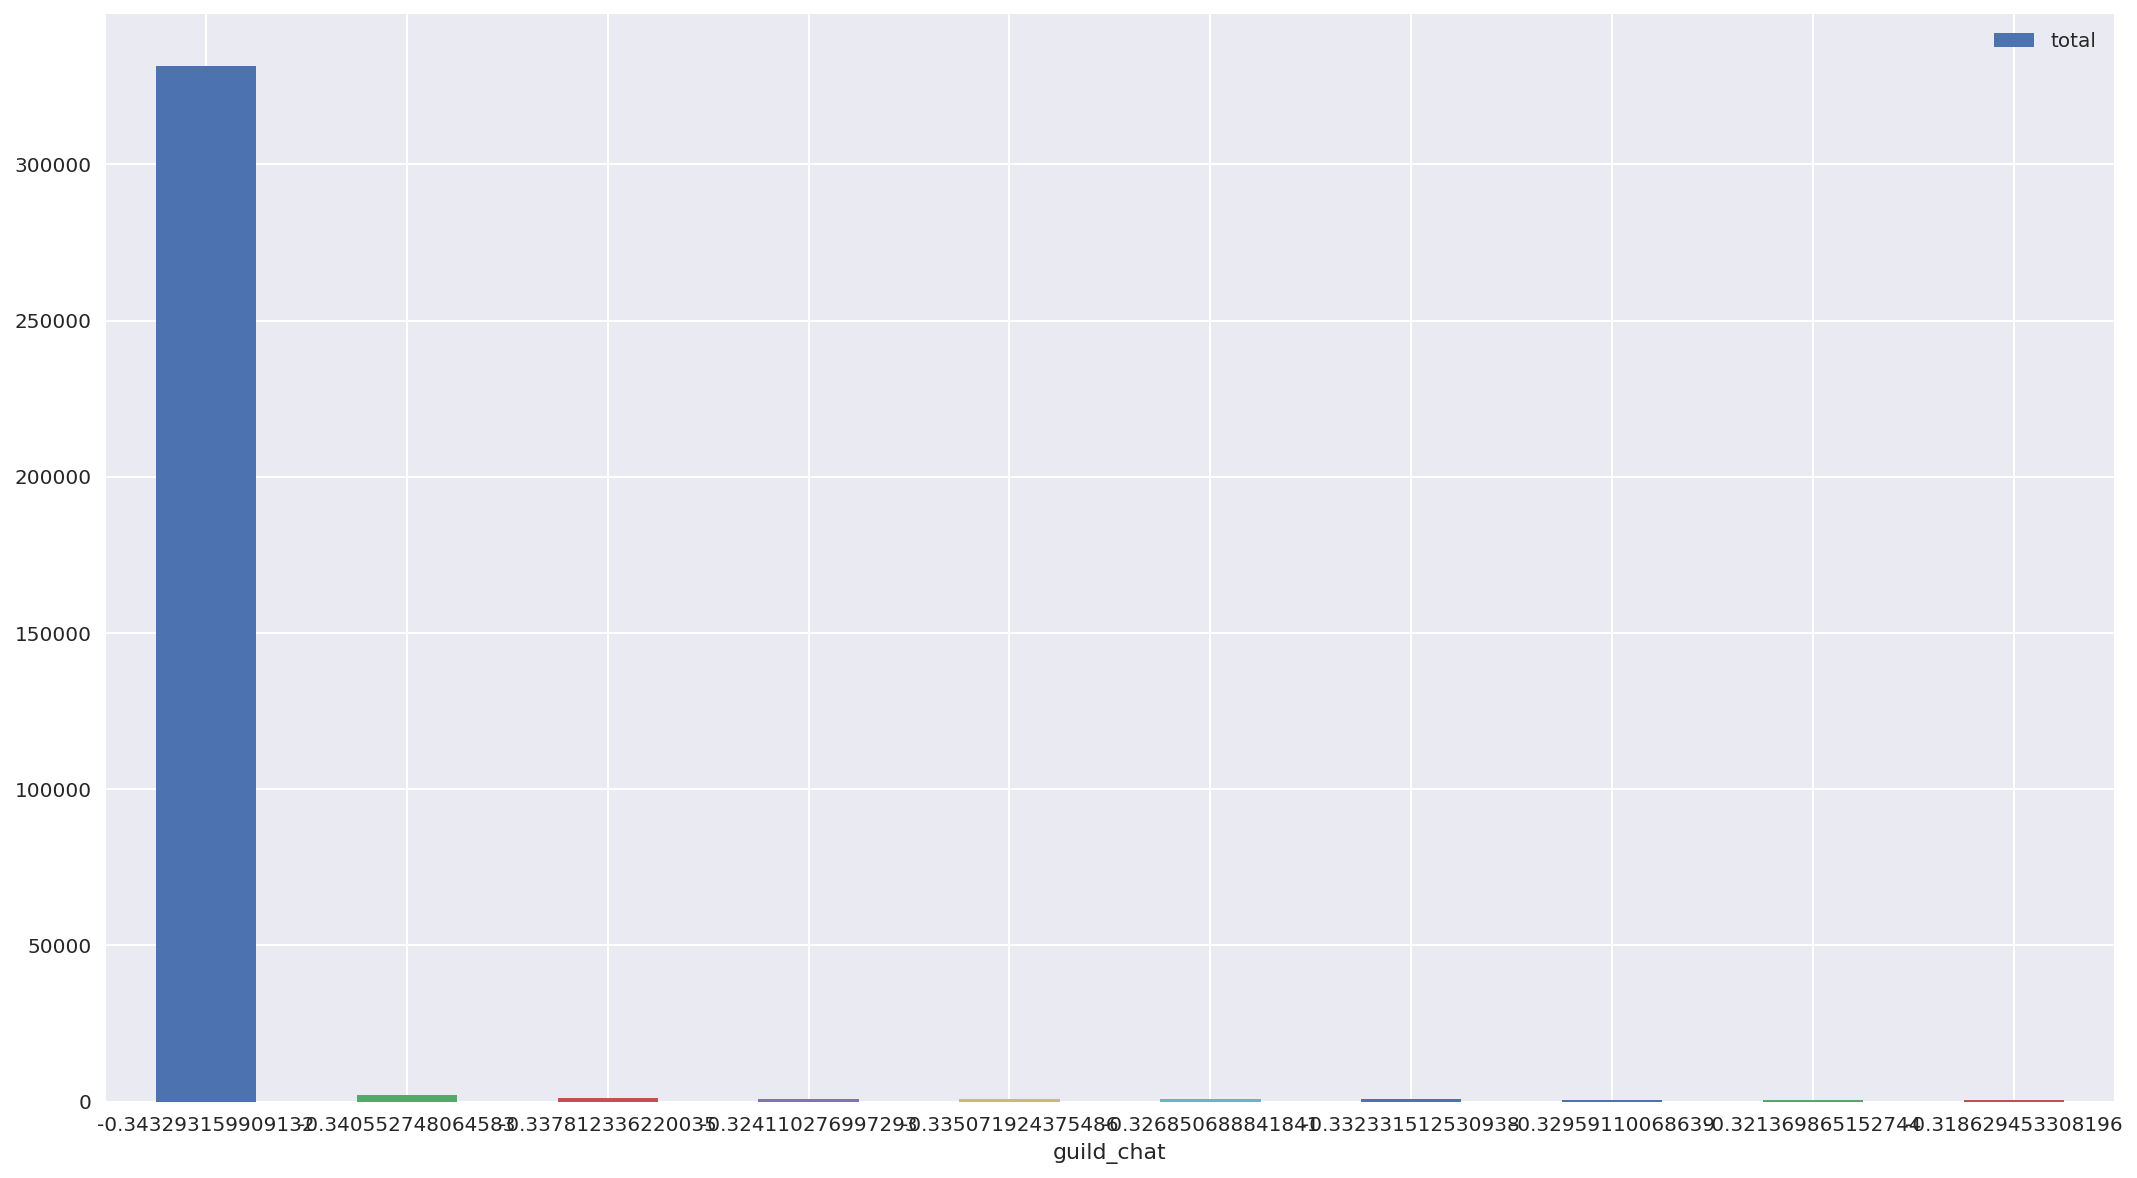

col :  faction_chat


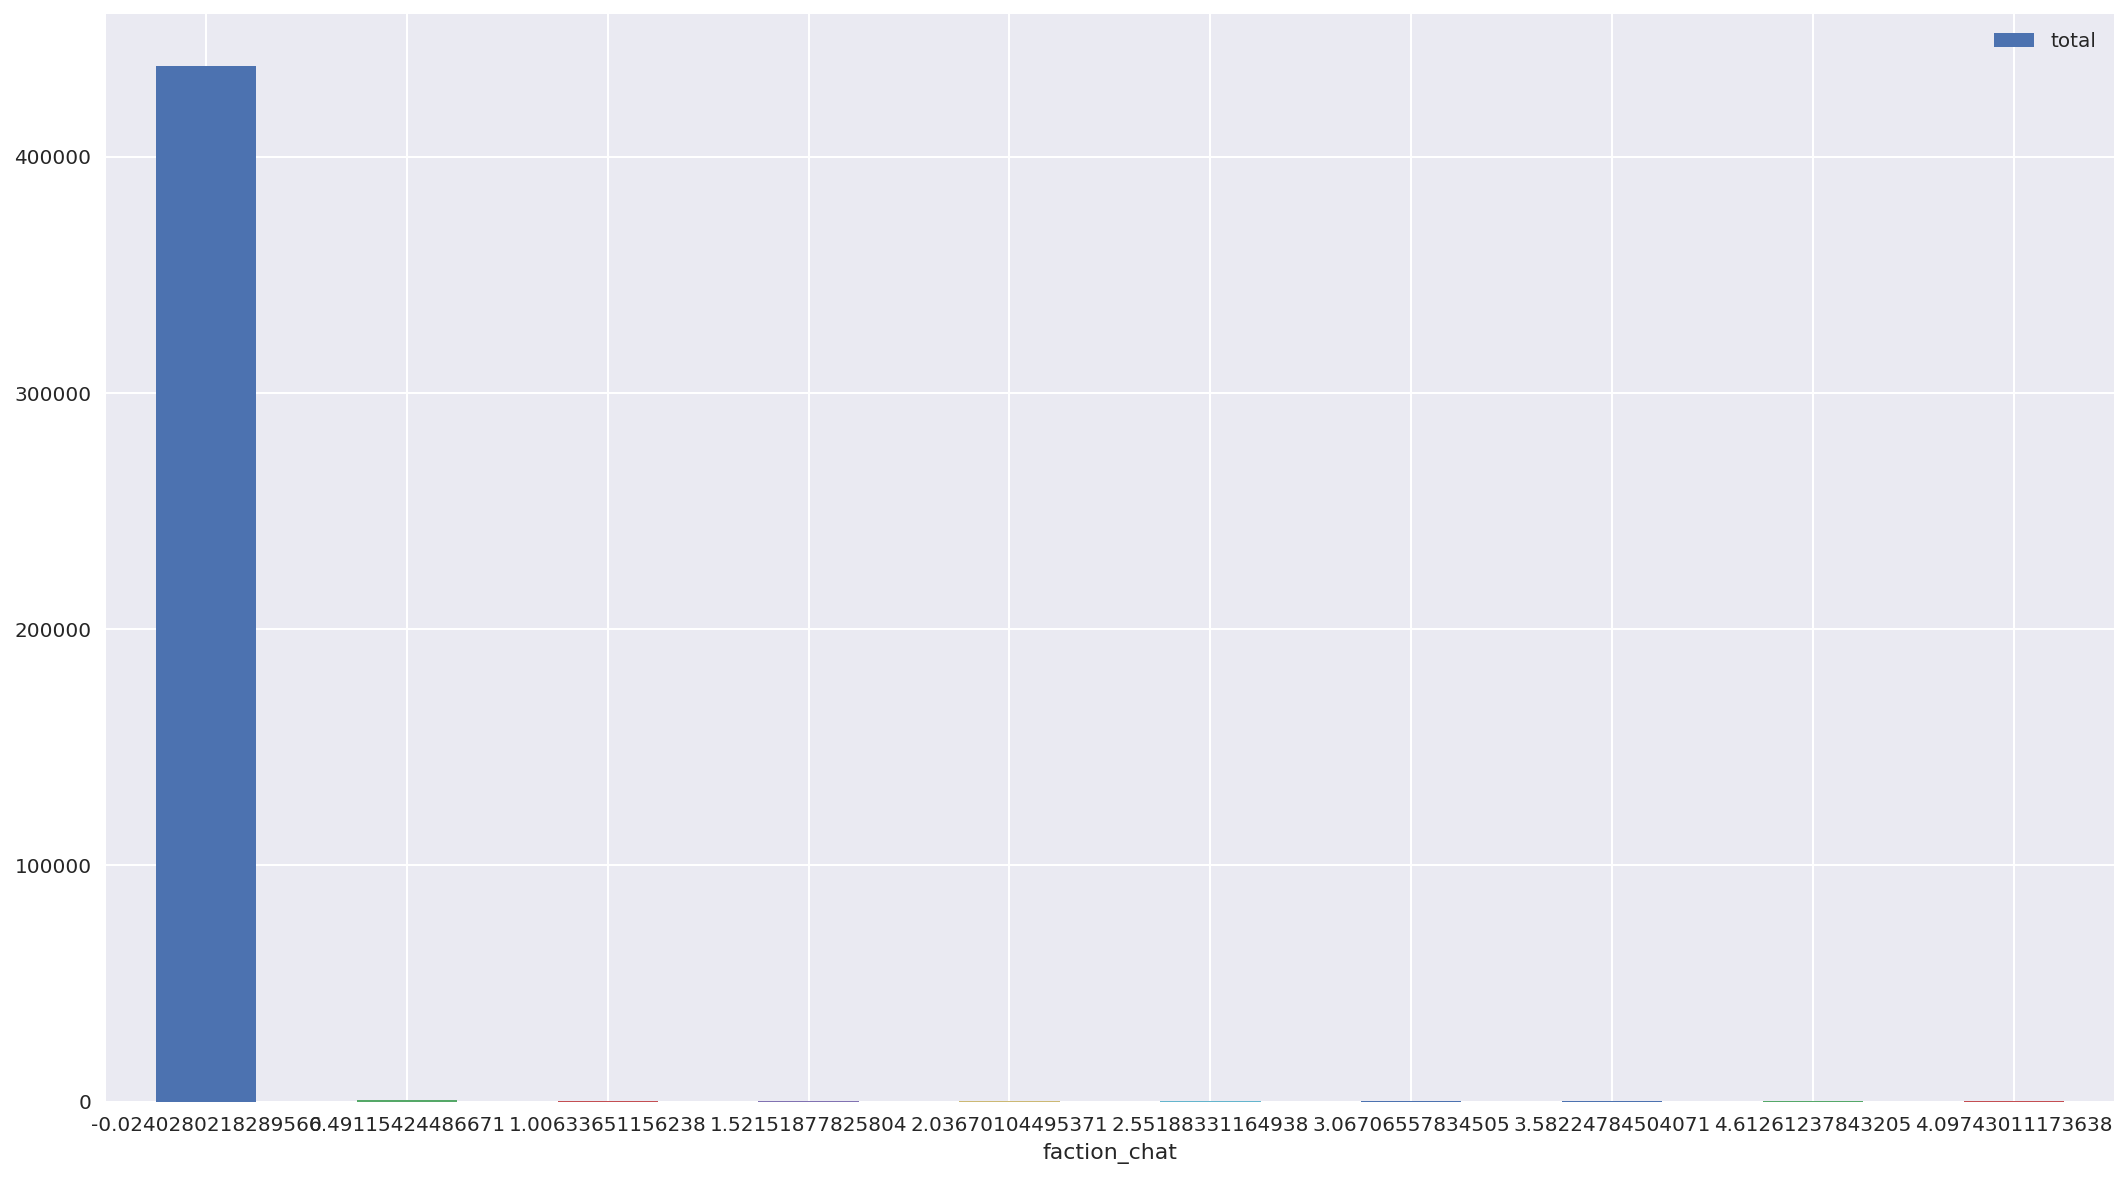

col :  cnt_use_buffitem


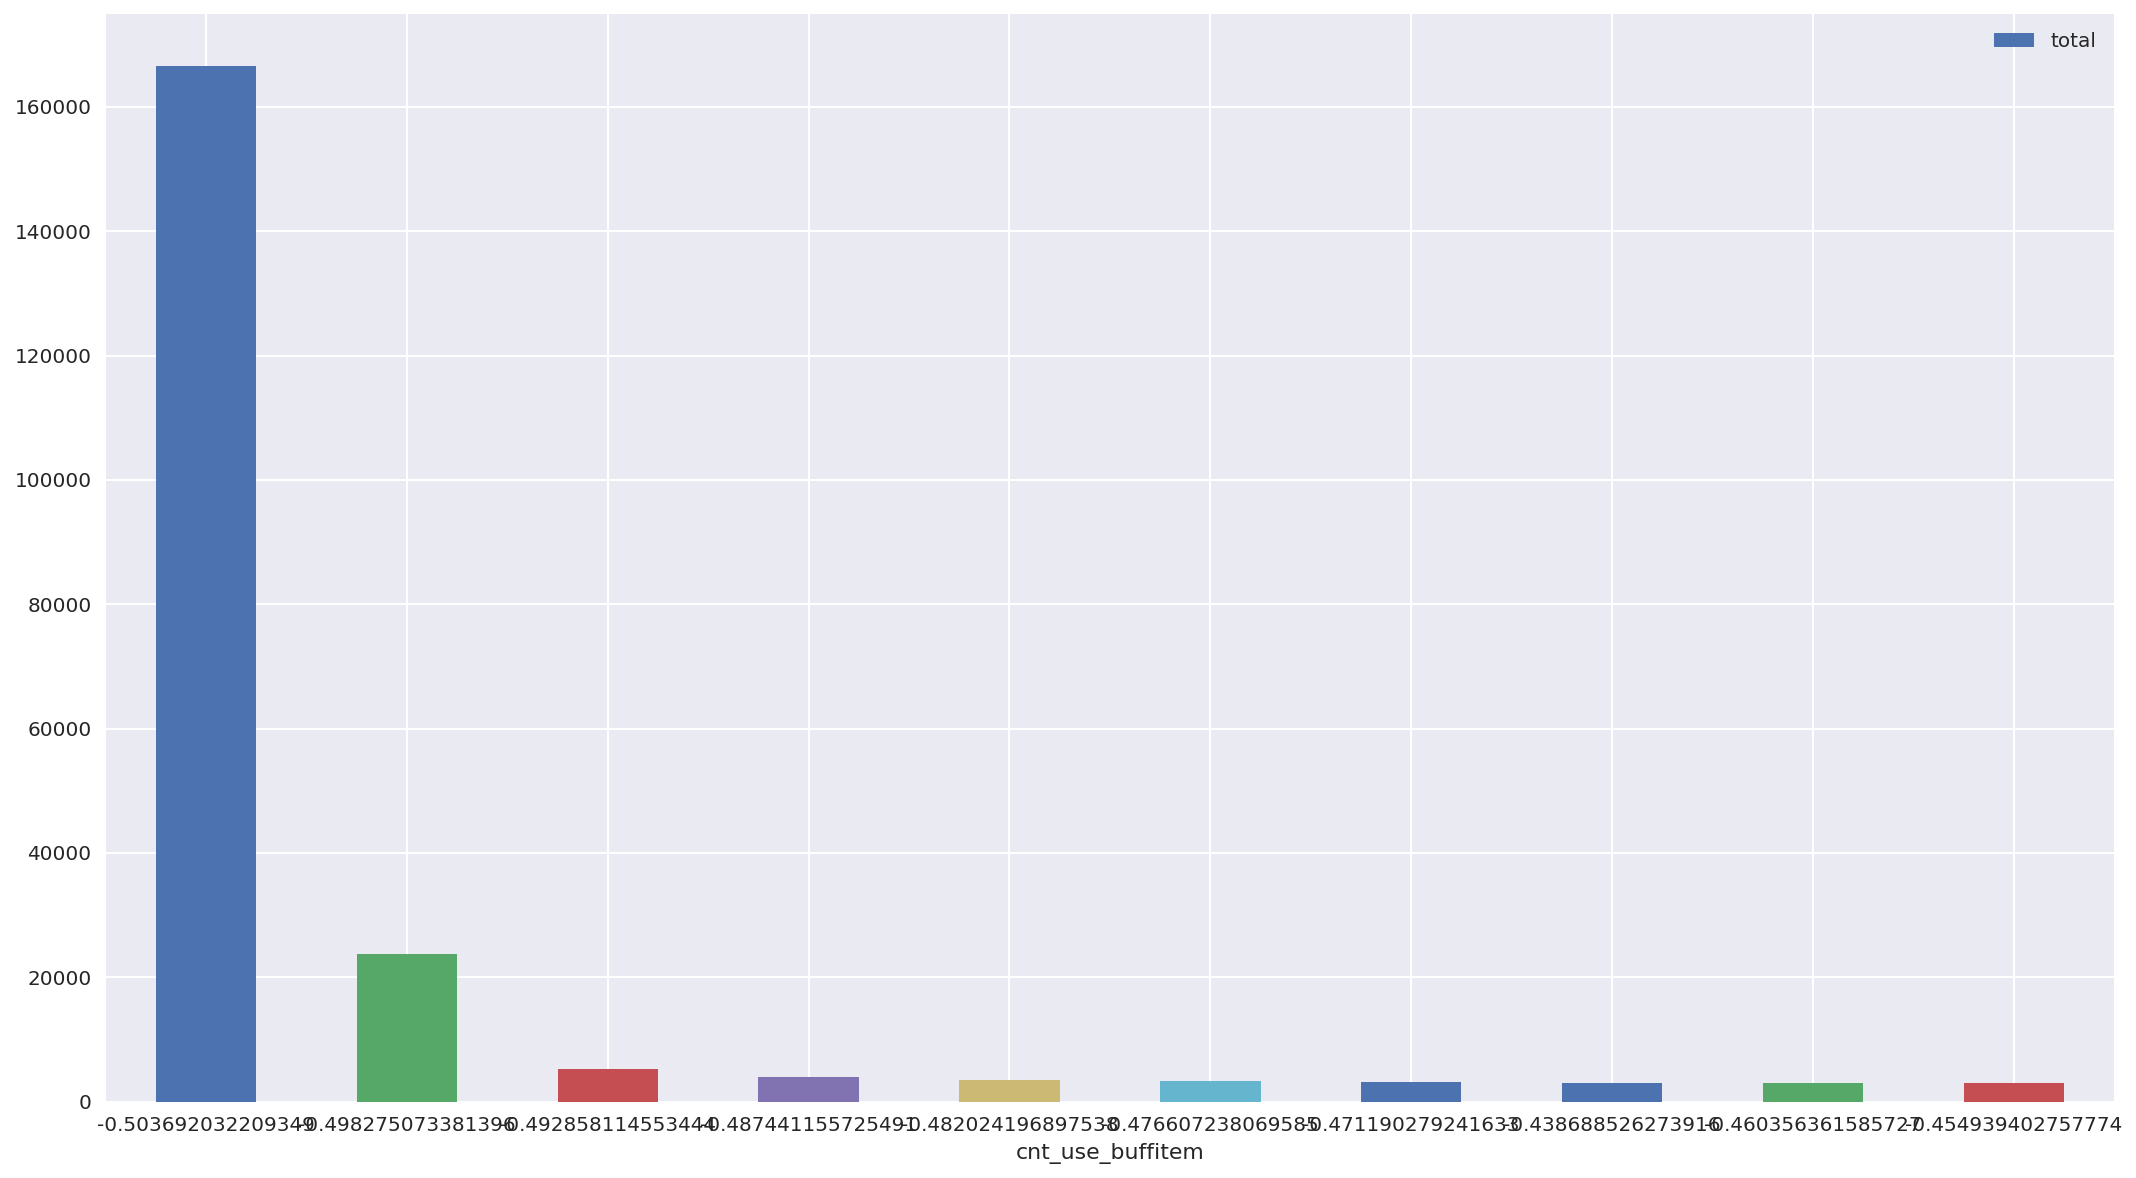

col :  gathering_cnt


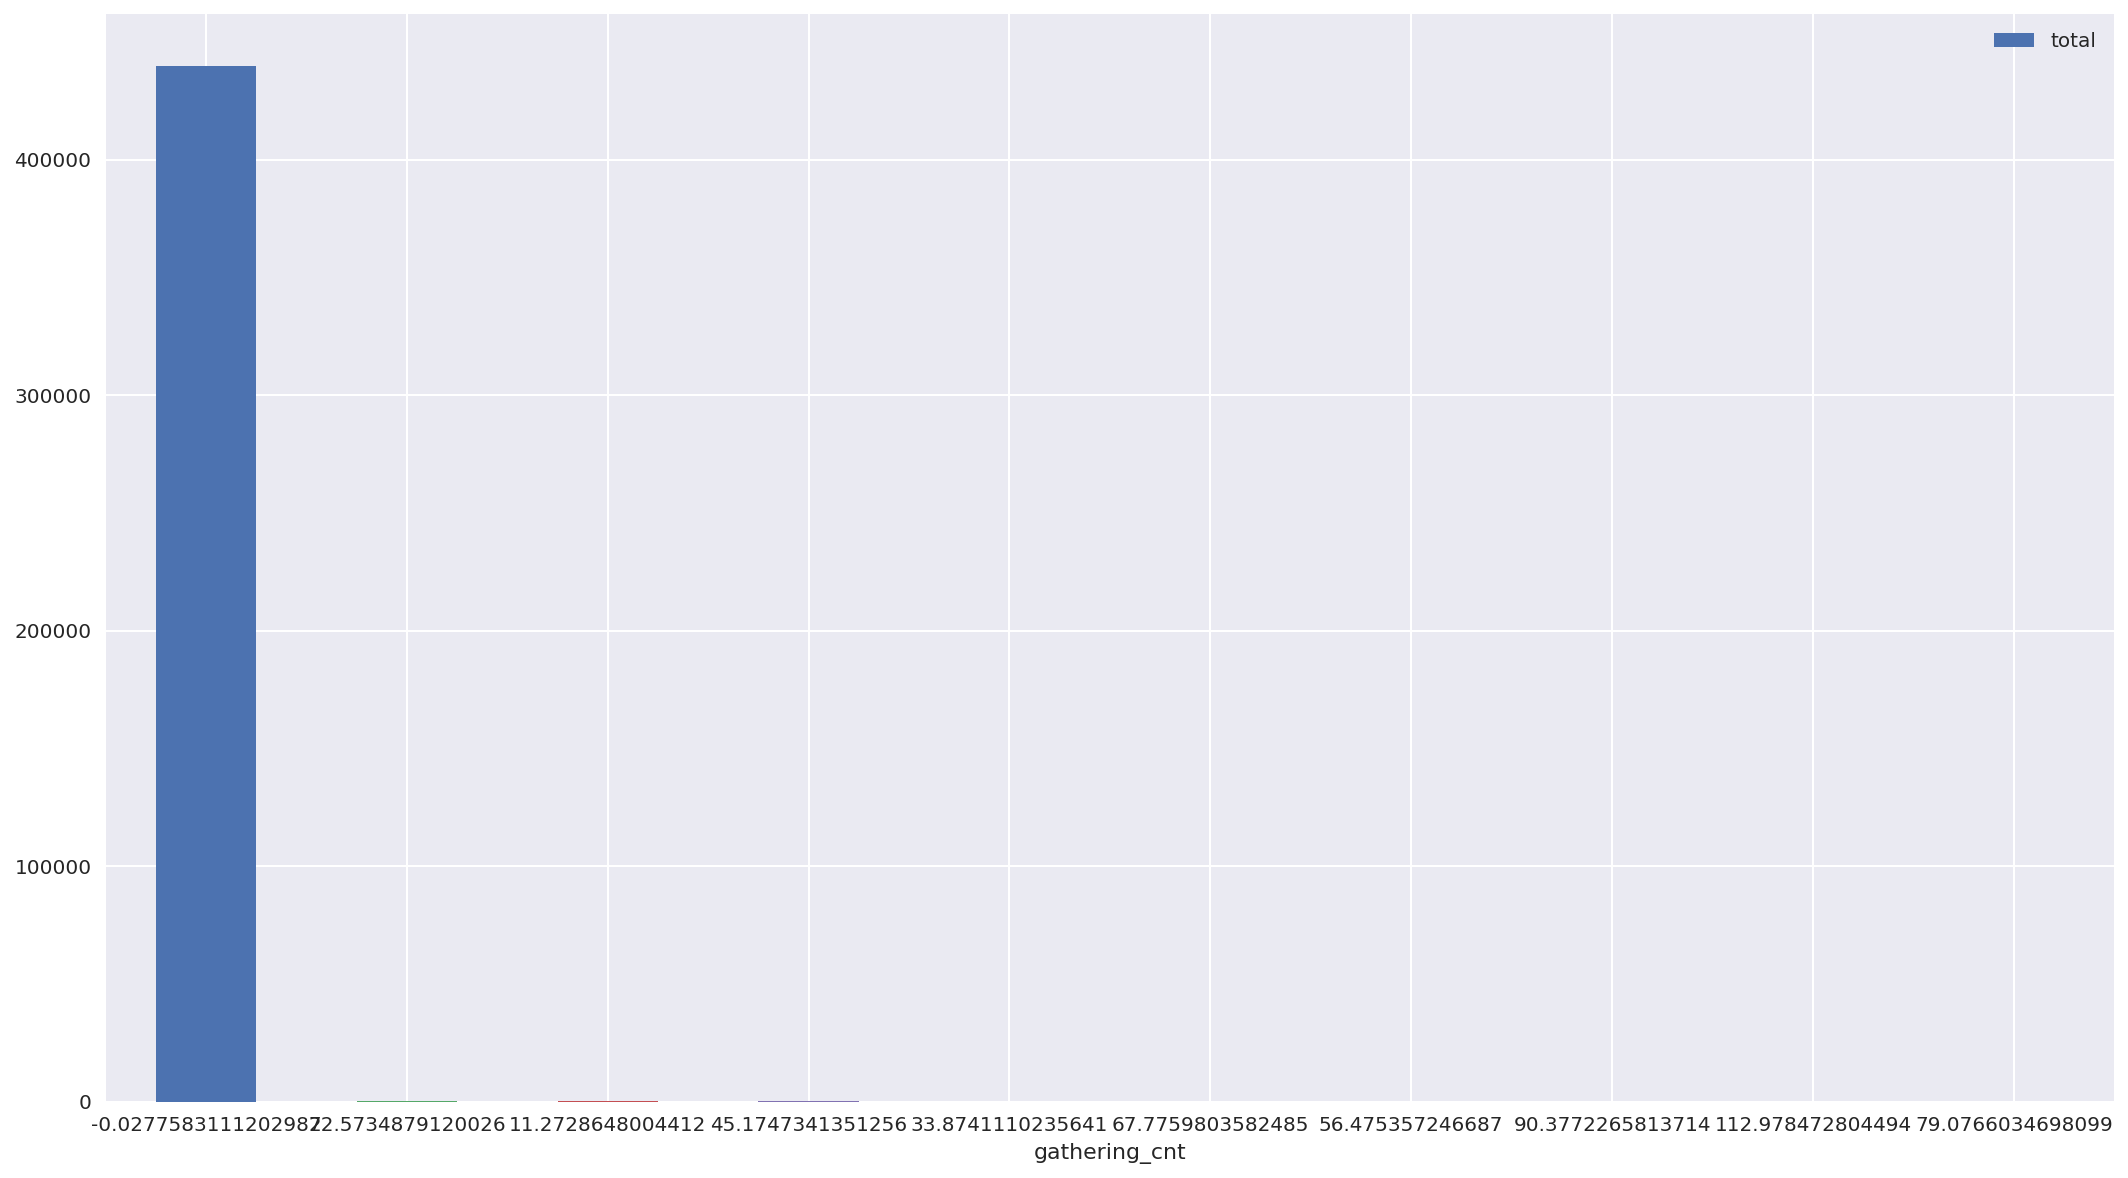

col :  making_cnt


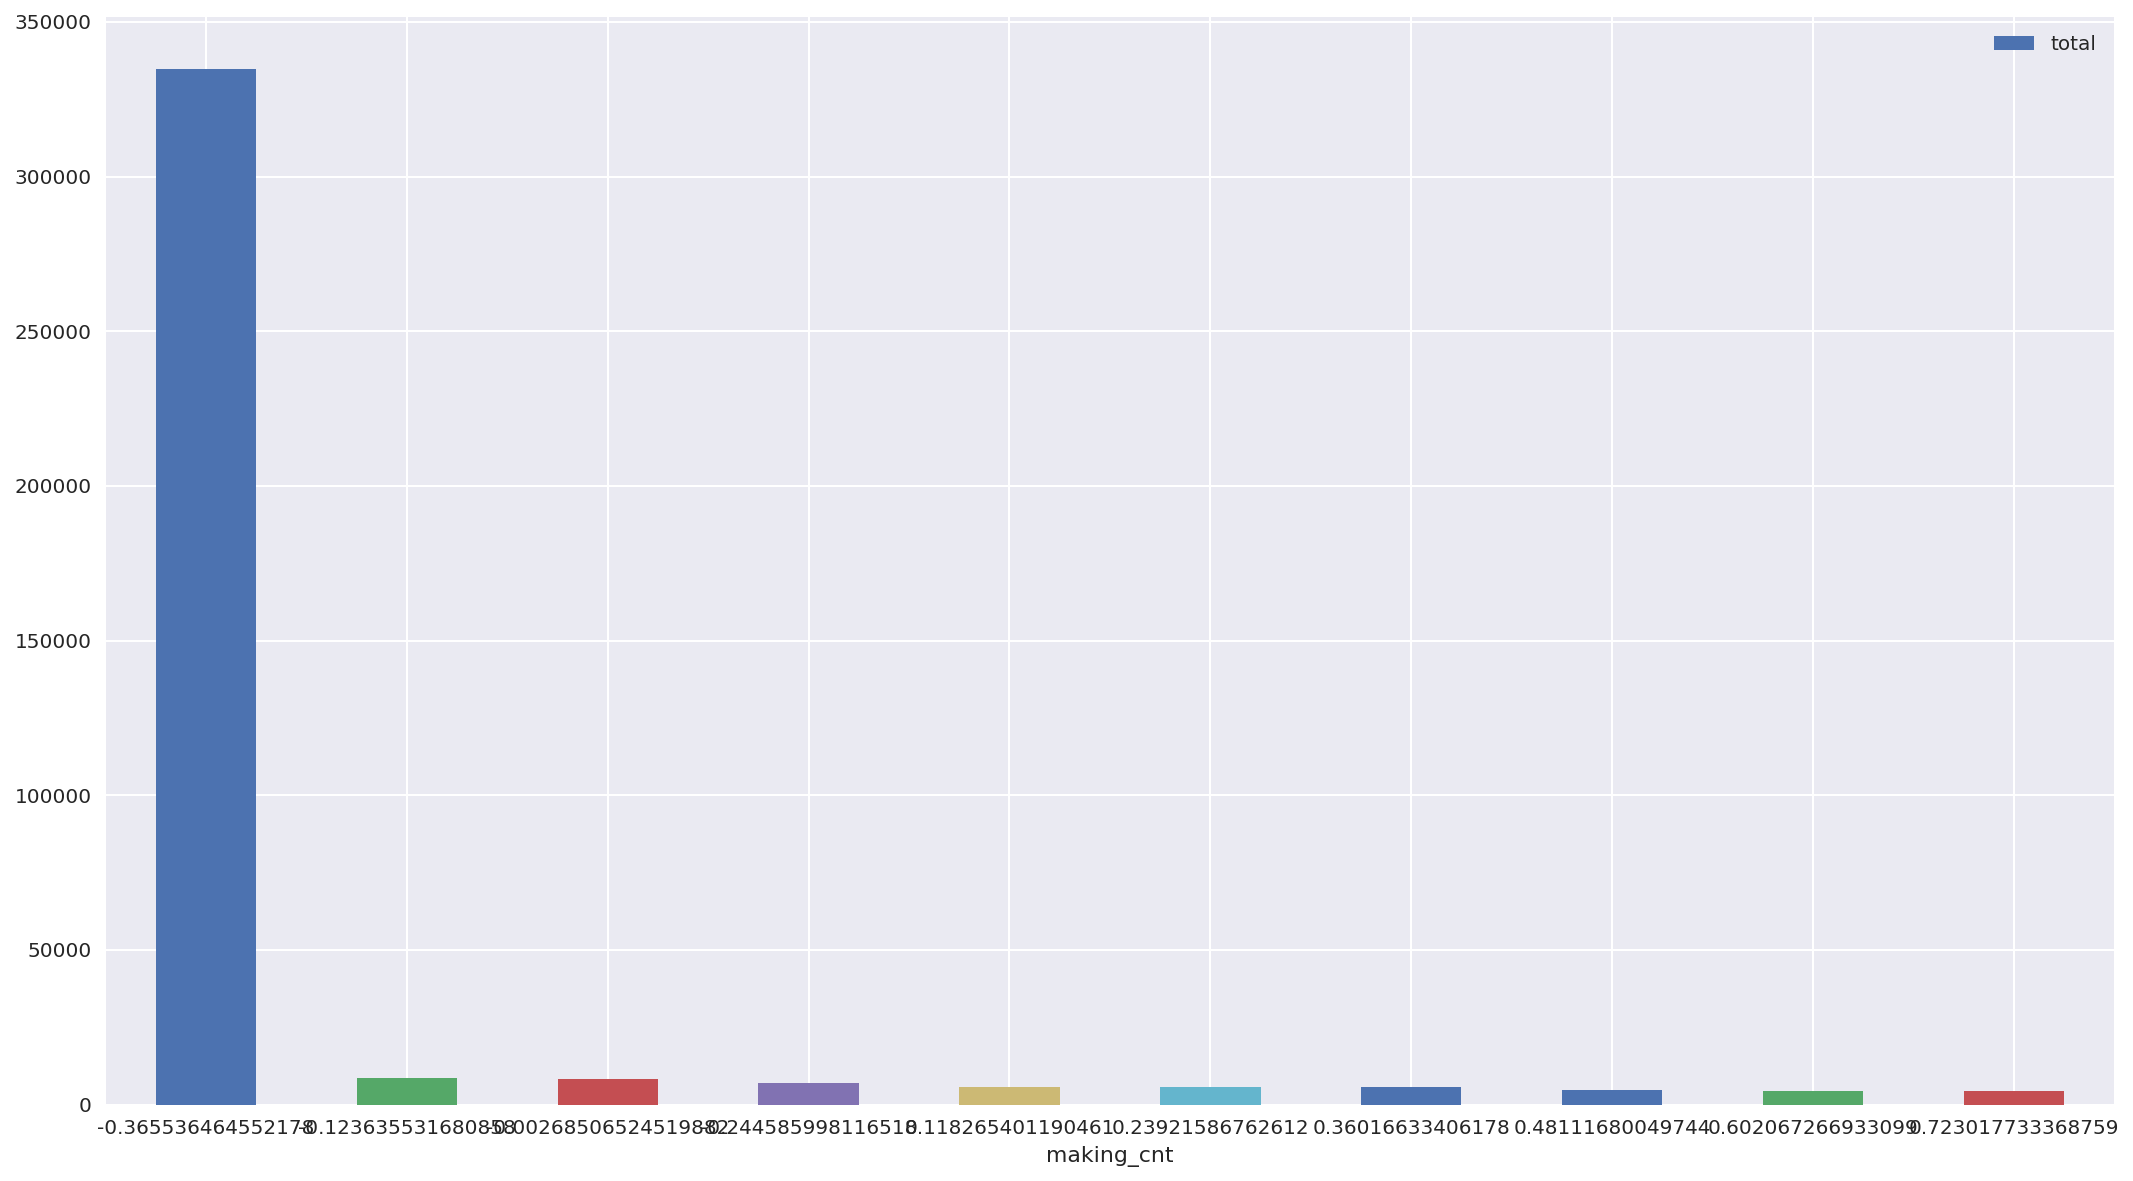

CPU times: user 17.4 s, sys: 523 ms, total: 17.9 s
Wall time: 2min 4s


In [88]:
%%time
skip_cols = ['acc_id', 'play_time', 'game_combat_time', 'npc_exp', 'item_hongmun', 'quest_exp', 'quest_hongmun', 'game_combat_time', 'get_money']
for col in train_activity_df.columns:
    if col in skip_cols:
        continue
    print('='*50)
    print('col : ', col)
    df = select_count_top10(table="train_activity", column=col)[[col, "total"]]
    df.plot(x=col, y="total", kind="bar", rot=0, figsize=(18,10))
    plt.show()